In [1]:
dataset_name = "W14_comb"
df_list = ["BES_Panel","BES_reduced_with_na"]#,"BESnumeric"]

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display, display_html 

import Jupyter_module_loader
from utility import *

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()


global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))

    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )

(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

memory_use(locs = locals().items())

var_type (5692, 13)
           BES_reduced_with_na:   1.9GiB
                     BES_Panel: 506.4MiB
                      var_type:   4.3MiB
             new_old_col_names: 288.1KiB
                cat_dictionary: 144.1KiB
             old_new_col_names: 144.1KiB
             BES_file_manifest:  42.4KiB
                      manifest:   1.7KiB
                           _i2:   1.2KiB
                  gaussian_kde:   1.0KiB


In [67]:
memory_use(locs = locals().items())

           BES_reduced_with_na:   1.9GiB
                         train:   1.6GiB
                     BES_Panel: 506.4MiB
                       weights:   8.4MiB
                      var_type:   4.3MiB
                        target: 761.9KiB
                           _49: 647.9KiB
                          mask: 647.8KiB
             new_old_col_names: 288.1KiB
                cat_dictionary: 144.1KiB


In [4]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [5]:
max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name,BES_Panel)

In [6]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [7]:
def get_base_from_BES(im_var, waves=None, noNans = False):

    if waves:
        wave_list = waves
    else:
        wave_list = [x.replace(im_var,"") for x in BES_Panel.columns if re.match(im_var+"W\d+$",  x)]
    
    immig_vars = [im_var+x for x in wave_list]

    if noNans:
        all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)

        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        max_cat = BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore')[max_range]
        BES_immig = BES_Panel[immig_vars][all_in_dataset]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
    else:
        all_in_dataset = BES_Panel[immig_vars].isnull()
        
        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        max_cat = BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore')[max_range]
        BES_immig = BES_Panel[immig_vars]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
        
        BES_immig[all_in_dataset] = np.nan
        all_in_dataset = ~all_in_dataset
        
        
    return BES_immig, all_in_dataset

def get_base(im_var, waves=None, noNans = False, nan_value = False):
# get df containing all waves of some variable
# specify waves with integers! (makes sorting easier) - crash if you choose waves not present?

    wave_dict = {int(re.match(im_var+"W(\d+)",  x).groups()[0]):x for x in BES_reduced_with_na.columns if re.match(im_var+"W\d+($|_)",  x)}

    if waves:
        immig_vars = [wave_dict[x] for x in sorted(intersection(waves,wave_dict.keys()))]
    else:
        immig_vars = [wave_dict[x] for x in sorted(wave_dict.keys())]

    if noNans:
        all_in_dataset = BES_reduced_with_na[immig_vars].notnull().all(axis=1)
        max_range = BES_reduced_with_na[immig_vars].max().max()
        BES_immig = BES_reduced_with_na[immig_vars][all_in_dataset]\
        .apply(lambda x: x.fillna(x.median())) / max_range
    elif nan_value:
        all_in_dataset = BES_reduced_with_na[immig_vars].notnull().all(axis=1)
        max_range = BES_reduced_with_na[immig_vars].max().max()
        BES_immig = BES_reduced_with_na[immig_vars][all_in_dataset]\
        .apply(lambda x: x.fillna(nan_value)) / max_range
    else:
        all_in_dataset = BES_reduced_with_na[immig_vars].isnull()
        max_range = BES_reduced_with_na[immig_vars].max().max()
        BES_immig = BES_reduced_with_na[immig_vars] / max_range

        all_in_dataset = ~all_in_dataset
        
        
    return BES_immig, all_in_dataset



def get_diff(imvar_list, nan_value = False):
    num = 0
    for im_var in imvar_list:

        print(im_var)
        immig, mask = get_base(im_var, noNans = False, nan_value = nan_value)

        waves_tmp = [re.search("(W\d+)",x).groups()[0] for x in immig.columns]
        replace_wave = ["("+waves_tmp[a]+"->"+waves_tmp[a+1]+")" for a,b in enumerate(immig.columns[1:])]
        temp = [immig.columns[0]]
        temp.extend([re.sub("W\d+",replace_wave[i],x) for i,x in enumerate(immig.columns[1:])])
        immig.columns = temp     
        if num ==0:
            immigDiff = immig.astype('float').diff(axis=1).drop(immig.columns[0],axis=1)
        else:
            immigDiff = pd.concat( [immigDiff, immig.astype('float').diff(axis=1).drop(immig.columns[0],axis=1)], axis=1)
        num = num + 1
        
        assert (immigDiff.max().max()<=1) and (immigDiff.min().min()>=-1)
    return immigDiff

In [7]:
# temp = pd.read_msgpack(data_subfolder + "BES_reduced" + '.msgpack')
# nans = pd.read_msgpack(data_subfolder + "nans" + '.msgpack')
# temp[nans] = np.nan
# globals()[df] = temp[nans]
# del temp, nans

In [8]:
# %%time
# global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
# data_subfolder = BES_data_folder + dataset_name + os.sep

# (manifest, dataset_filename, dataset_description, dataset_citation,
#  dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)
# df="BES_reduced_with_na"
# globals()[df] = pd.read_msgpack(data_subfolder + "BES_reduced" + '.msgpack')
# # globals()[df][pd.read_msgpack(data_subfolder + "nans" + '.msgpack')] = np.nan


In [13]:
# nans = pd.read_msgpack(data_subfolder + "nans" + '.msgpack')

In [14]:
# BES_reduced_with_na.where(nans)

In [15]:
## augment dataset
# pan_dataset_values
# census data
# 

# pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)    

In [16]:
# # http://www.britishelectionstudy.com/data-object/2017-bes-constituency-results-with-census-and-candidate-data/
# BES_census_data = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
# print("BES_census_data", BES_census_data.shape )

# ## SHOULD BE REPLACED WITH pan_dataset_variables reference
# pano_var_dict = {int(x.replace("panoW","")):x for x in BES_Panel.columns if "pano" in x}
# sorted_pano_vars = [ pano_var_dict[x] for x in sorted( pano_var_dict.keys() ) ]

# BES_reduced_with_na["pano"] = BES_Panel[sorted_pano_vars].bfill(axis=1).iloc[:, 0]


# # len()
# census_vars = [x for x in BES_census_data.columns if re.match('c\w',x) ]
# census_vars.append("leaveHanretty")
# census_vars.append("remainHanretty")
# census_vars.append("pano")
# # ConstituencyType
# BES_reduced_with_na = pd.merge(BES_reduced_with_na, BES_census_data[census_vars], how = 'left', on = 'pano')


In [17]:
# import sys, gc

# def sizeof_fmt(num, suffix='B'):
#     ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f%s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f%s%s" % (num, 'Yi', suffix)

# def memory_use(locs = locals().items()):
#     gc.collect()
#     # locals().items()
#     for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locs),
#                              key= lambda x: -x[1])[:10]:
#         print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))
# memory_use()

In [60]:
# [x for x in BES_reduced_with_na.columns if re.match("profile_euref",x)]


In [61]:
# optional_mask_fn(8).sum()

In [12]:
Treatment = "euRefVote_change_shiftsonly_fixed"

### focal variable??

In [13]:
# var_stub = "partyId"
# var_list = [x for x in BES_reduced_with_na.columns if re.match(var_stub+"W\d+_No - none",x)]
# # "partyIdStrength",
# var_stub_list = ["partyId", "partyIdSqueeze",  "generalElectionVote", "ashcroft", "generalElectionCertainty"]
# # base_list = [x for x in BES_reduced_with_na.columns if var_stub in x][0:len(var_list)]
# var_list

In [14]:
var_stub = "euRefVote"
var_list = [x for x in BES_reduced_with_na.columns if re.match(var_stub+"W",x)]
# "partyIdStrength",
# var_stub_list = ["partyId", "partyIdSqueeze",  "generalElectionVote", "ashcroft", "generalElectionCertainty"]
var_stub_list = ["euRefVote"]
# base_list = [x for x in BES_reduced_with_na.columns if var_stub in x][0:len(var_list)]
var_list

['euRefVoteW4_Leave the EU',
 'euRefVoteW10_Leave the EU',
 'euRefVoteW9_Leave the EU',
 'euRefVoteW7_Leave the EU',
 'euRefVoteW6_Leave the EU',
 'euRefVoteW8_Leave the EU',
 'euRefVoteW2_Leave the EU',
 'euRefVoteW13_Leave the EU',
 'euRefVoteW14_Leave the EU',
 'euRefVoteW1_Leave the EU',
 'euRefVoteW11_Leave the EU',
 'euRefVoteW3_Leave the EU',
 'euRefVoteW12_Leave the EU']

In [15]:
imvar_list = [var_stub]

immigDiff = get_diff(imvar_list)

euRefVote


In [16]:
var_stub = "euRefVote"
var_list = [x for x in immigDiff.columns if re.match(var_stub,x)]
var_list
# # "partyIdStrength",
# # var_stub_list = ["partyId", "partyIdSqueeze",  "generalElectionVote", "ashcroft", "generalElectionCertainty"]
# # var_stub_list = ["euRefVote","profile_eurefvote_Leave the EU"]
# var_stub_list = ["immigSelf"]
# # base_list = [x for x in BES_reduced_with_na.columns if var_stub in x][0:len(var_list)]
# var_list

['euRefVote(W1->W2)_Leave the EU',
 'euRefVote(W2->W3)_Leave the EU',
 'euRefVote(W3->W4)_Leave the EU',
 'euRefVote(W4->W6)_Leave the EU',
 'euRefVote(W6->W7)_Leave the EU',
 'euRefVote(W7->W8)_Leave the EU',
 'euRefVote(W8->W9)_Leave the EU',
 'euRefVote(W9->W10)_Leave the EU',
 'euRefVote(W10->W11)_Leave the EU',
 'euRefVote(W11->W12)_Leave the EU',
 'euRefVote(W12->W13)_Leave the EU',
 'euRefVote(W13->W14)_Leave the EU']

In [17]:
# immigDiff

In [18]:
thresh = 0.1 # -> 76 variables
# thresh = 0.05 # -> 65 variables!
# thresh = 0.1 # -> 134 variables
# thresh = 0.5 # -> 134 variables
focal_df = BES_reduced_with_na
focal_df = immigDiff

In [19]:
# %%time



diff_feature_candidate_list = []
ordinalised_vars = var_type[ var_type["type"].apply(lambda x: x in [0, 1, 2, 3, 5, 6])].index
# ordinalised_vars = var_type[ np.logical_and( var_type["type"].apply(lambda x: x in [0, 1, 2, 3, 5, 6]),
#                                              var_type["dataset_name"] == dataset_name )].index
reduced_ordinal_vars = [x for x in new_old_col_names.keys() if new_old_col_names[x] in ordinalised_vars]
vars_present = intersection(reduced_ordinal_vars, BES_reduced_with_na.columns)


for focal_var in var_list:
    print(focal_var)
    corr = BES_reduced_with_na[vars_present].corrwith(focal_df[focal_var])
    reduced_corr = corr.sort_values()

    high_corr = reduced_corr[ np.logical_or( reduced_corr< reduced_corr.quantile(thresh) ,
                                             reduced_corr> reduced_corr.quantile(1-thresh) ) ]
    diff_feature_candidate_list.extend(list(high_corr.index))
print(len(diff_feature_candidate_list))

euRefVote(W1->W2)_Leave the EU
euRefVote(W2->W3)_Leave the EU
euRefVote(W3->W4)_Leave the EU
euRefVote(W4->W6)_Leave the EU
euRefVote(W6->W7)_Leave the EU
euRefVote(W7->W8)_Leave the EU
euRefVote(W8->W9)_Leave the EU
euRefVote(W9->W10)_Leave the EU
euRefVote(W10->W11)_Leave the EU
euRefVote(W11->W12)_Leave the EU


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


euRefVote(W12->W13)_Leave the EU
euRefVote(W13->W14)_Leave the EU
16310


In [20]:
# diff_feature_candidate_list

In [21]:
temp  = [x for x in diff_feature_candidate_list if re.search("W\d+",x)]
temp2 = [x for x in temp if not re.search("(W\d+){2}",x)]
temp3 = [re.match("([a-zA-Z0-9_]+?)(W\d+){1}",x).groups(0)[0] if re.match("([a-zA-Z0-9_]+)(W\d+){1}",x) else x for x in temp2 ]
imvar_list = list(set(temp3))
auto_gen = imvar_list

In [22]:
auto_gen

['ptvGrn',
 'selfOccOrgSizeLast',
 'labPartnerGreen',
 'responsibleCrimeConservatives',
 'candChoice2',
 'referendumContact_none',
 'regretsIHaveAFewEU',
 'partySiteOth',
 'twitterInfof2f',
 'ukipLookAfterMC',
 'scotSNP',
 'warmMC',
 'discussantEthnicity1',
 'partyIdSqueeze',
 'generalElectionVote',
 'localElectionVote',
 'partyContactOthRemain',
 'achieveReduceImmigUKIP',
 'lrgreens',
 'labPriorities_immig',
 'leaveVoteUKIPCon',
 'labPriorities_crime',
 'winConstituencySNP',
 'gor',
 'ethno1',
 'tryReduceImmigUKIP',
 'discussantEthnicity2',
 'winConstituencyLab',
 'labPriorities2_immig',
 'moreParl_2',
 'welfarePreference',
 'empathy9',
 'moreParl_8',
 'likeAlanJohnson',
 'partyContactStrongerIn',
 'childBenefitsRepatriate',
 'al1',
 'partyContactGreen_6',
 'profile_religion',
 'propMPWC',
 'partyContactLD_6',
 'euKnow4',
 'resourceAccess3_99',
 'conPartnerLD',
 'warmEastern',
 'responsibleImmigLibDems',
 'mpSecondJob4',
 'snpFear',
 'certaintyUKRemain',
 'immigLab',
 'likeFarage',
 'savings',
 'noChanceCoalitionUKIP',
 'allSourceIncome_6',
 'warmGreece',
 'resourceAccess3_4',
 'motive1',
 'certaintyEULab',
 'cspl5',
 'likeRudd',
 'scotReferendumIntention',
 'cspl1',
 'EUIntegrationLD',
 'earlyElecSupport',
 'voteMethodEurope_3',
 'selfOccSupervise',
 'labFear',
 'generalElectionVotePost',
 'tryReduceInequalityGrn',
 'enviroProtection',
 'warmSpain',
 'likeMcDonnell',
 'partyId',
 'childvalues_2',
 'friendsEU',
 'tryReduceImmigCon',
 'cooperateRUKGBP',
 'redistLab',
 'grnAngry',
 'deficitReduce',
 'partySiteUKIP',
 'askVoteDiscuss3',
 'natSecuritySelf',
 'sickElderlyInHouse',
 'discussantturnoutName3',
 'resourceAccess2_111',
 'singlePartyEffective',
 'dv2w2',
 'resourceAccess3_1',
 'euExpRef',
 'pidMyParty',
 'resourceAccess1_5',
 'partyContactLab_7',
 'generalElectionCertainty',
 'secondHome',
 'generalElectionCertaintySq',
 'efficacyEnjoyVote',
 'conLookAfterWC',
 'campaigninfoLeave',
 'conFear',
 'labCandCorbynite',
 'EUMIICategory',
 'govtHandleImmig',
 'payoffsizeB2',
 'responsibleCostLiveScotGovt',
 'winConstituencyCon',
 'tryReduceInequalityLab',
 'localTurnoutRetro',
 'noChanceCoalitionNone',
 'discussantsSameAddress_222',
 'creditLeave_1',
 'polPreferToFight',
 'warmAsian',
 'preferMPWomen',
 'referendumContact_6',
 'changeView',
 'allSourceIncome_5',
 'fbInfof2f',
 'allSourceIncome_4',
 'discussantturnoutName2',
 'pccTurnout',
 'mapdefined_7',
 'motive2',
 'leftRight',
 'effectsEUNHS',
 'ukipPride',
 'certaintyScotIndependence',
 'csplPunishWrongs',
 'discussantEthnicity3',
 'effectsEUImmigration',
 'populism5',
 'askVoteOther',
 'euroTurnoutRetro',
 'ldPriorities_school',
 'immigSelf',
 'ukipGovTrust',
 'discrimChristians',
 'ethno3',
 'successReduceInequalityLD',
 'warmWhite',
 'effectsEUUnemployment',
 'natSecurityUKIP',
 'payoffsizeA1',
 'scotFairShare',
 'howToReduceDeficit',
 'labPriorities_none',
 'conLookAfterBA',
 'likeNuttall',
 'euSources_111',
 'tolUncertain1',
 'partyContactCon',
 'ukipPriorities_school',
 'certaintyRedistCon',
 'negotiationSpecifics_3',
 'euMIISmall',
 'ptvCon',
 'mpSecondJob5',
 'ldLookAfterMC',
 'responsibleEconConservatives',
 'euLeaveBigBusiness',
 'selfRedistCertain',
 'discussantVoteName2',
 'miilabel',
 'partyContactLab_4',
 'localEcon1520Yr',
 'taxSpendGreen',
 'EUIntegrationCon',
 'resourceAccess3_3',
 'mii_cat',
 'likeMay',
 'energyPriceCap',
 'cabinetSupport',
 'partyContactLD',
 'conPriorities2_natsec',
 'britBornHere',
 'ldPriorities_crime',
 'dutyStrong',
 'belongGroup_2',
 'motherCountryBorn',
 'partyContactLD_4',
 'partydiffconlab',
 'labLookAfterUnemp',
 'inequalityChangeLarger',
 'efficacyNotUnderstand',
 'ptvUKIP',
 'parliamentSupport',
 'tolUncertain3',
 'spendMost4',
 'tryReduceInequalityLD',
 'ukipPriorities2_immig',
 'aom4',
 'euKnow3',
 'discussantClassName1',
 'womenJobs',
 'responsibleCrimeNone',
 'groupempathy4',
 'labHandleImmig',
 'partyContactLab_6',
 'lr1',
 'socialDistLD',
 'responsibleImmigNone',
 'likeBennett',
 'majorityPartyCon',
 'abroadCountry_2',

In [23]:
imvar_list = auto_gen

immigDiff = get_diff(imvar_list)

ptvGrn
selfOccOrgSizeLast
labPartnerGreen
responsibleCrimeConservatives
candChoice2
referendumContact_none
regretsIHaveAFewEU
partySiteOth
twitterInfof2f
ukipLookAfterMC
scotSNP
warmMC
discussantEthnicity1
partyIdSqueeze
generalElectionVote
localElectionVote
partyContactOthRemain
achieveReduceImmigUKIP
lrgreens
labPriorities_immig
leaveVoteUKIPCon
labPriorities_crime
winConstituencySNP
gor
ethno1
tryReduceImmigUKIP
discussantEthnicity2
winConstituencyLab
labPriorities2_immig
moreParl_2
welfarePreference
empathy9
moreParl_8
likeAlanJohnson
partyContactStrongerIn
childBenefitsRepatriate
al1
partyContactGreen_6
profile_religion
propMPWC
partyContactLD_6
euKnow4
resourceAccess3_99
conPartnerLD
warmEastern
responsibleImmigLibDems
mpSecondJob4
snpFear
certaintyUKRemain
immigLab
likeFarage
savings
noChanceCoalitionUKIP
allSourceIncome_6
warmGreece
resourceAccess3_4
motive1
certaintyEULab
cspl5
likeRudd
scotReferendumIntention
cspl1
EUIntegrationLD
earlyElecSupport
voteMethodEurope_3
selfOccSu

conPriorities2_crime
britRespectLaw
responsibleDebtLiberalDems
approveScotGovt
finlit2
labSupport
locus1
spendLeast3
ukipPriorities_immig
forcedSubjClass
tryReduceImmigLab
changeEducation
scotIndepJoinEU
groupempathy3
partyContactUKIP_2
ldTone
discussPolDaysD3
ukipHope
ukipNone
homeAmtb
wcVmc2
likeMiliband
resourceAccess1_3
achieveReduceImmigCon
certaintyUKLeave
immigEcon
partySiteGreen
redistGreen
propMPYoung
ukipPriorities2_none
likeLab
snpLookAfterWC
britishness
spendMost6
UKsovereigntyPost
payoffsizeB5
csplImproveStandards
discrimWhite
accessMedia
participation_6
discussantApprovalVoteName3
creditLeave_4
immigContributeTake
satDemEU
accessFixComputer
gayEquality
responsibleEconScottishGovt
education
relationshipName3
conGovTrust
pidPraiseGood
likeBatten
polForTheRich
britChristian
eesEUIntegrationLab
scotElectionVoteConst
discussPolDays
ptvGrnExp
ldAngry
radical
empathy7
handleMIICon
happyLeave
ldPriorities_immig
efficacyEU
grnHope
regSatisfaction
responsibleImmigScottishGovt
labUn

In [24]:
# lr_pos =  [x for x in BES_reduced_with_na.columns if re.match("lrCon|lrLab",x)]
# lr_pos.remove('lrConW10__Right')
# lr_pos

In [25]:
# immigDiff

In [26]:
# immigDiff = BES_reduced_with_na[lr_pos].diff(axis=1)[lr_pos[1::2]]

In [27]:
# lrLab-lrCon

In [28]:
# var_stub = "partyId"
# var_list = [x for x in BES_reduced_with_na.columns if re.match(var_stub+"W\d+_No - none",x)]
# # "partyIdStrength",
# var_stub_list = ["partyId", "partyIdSqueeze",  "generalElectionVote", "ashcroft", "generalElectionCertainty"]
# # base_list = [x for x in BES_reduced_with_na.columns if var_stub in x][0:len(var_list)]
# var_list

In [29]:
# party_id_none_delta = BES_reduced_with_na[var_list].astype('float').diff(axis=1).drop(var_list[0],axis=1)
# party_id_none_delta
# var_list = var_list[1:]
# var_list


In [30]:
# var_list = immigDiff.columns
# var_stub_list = ['lrLab','lrCon']

In [31]:
# var_list.remove('partydiffconlabW5__There is not much difference between them')
# var_list = var_list[-2:]

In [32]:
# BES_Panel['happyEULeaveW11'].notnull().sum()

In [33]:
# BES_reduced_with_na['euRefVoteW13_Leave the EU'] = BES_Panel["euRefVoteW13"].cat.codes
# BES_reduced_with_na['euRefVoteW13_Leave the EU'] = BES_reduced_with_na['euRefVoteW13_Leave the EU'].replace(2, np.nan).replace(3, np.nan).replace(-1, np.nan)

# BES_reduced_with_na['euRefVoteW11_Leave the EU'] = BES_Panel["euRefVoteW11"].cat.codes
# BES_reduced_with_na['euRefVoteW11_Leave the EU'] = BES_reduced_with_na['euRefVoteW11_Leave the EU'].replace(2, np.nan).replace(3, np.nan).replace(-1, np.nan)

# BES_reduced_with_na['generalElectionVoteW10__Conservative'] = (BES_Panel['generalElectionVoteW10']=="Conservative")
# BES_reduced_with_na.loc[BES_Panel['generalElectionVoteW10'].isnull(),'generalElectionVoteW10__Conservative'] = np.nan

# BES_reduced_with_na['generalElectionVoteW11__Conservative'] = BES_Panel['generalElectionVoteW11']=="Conservative"
# BES_reduced_with_na.loc[BES_Panel['generalElectionVoteW11'].isnull(),'generalElectionVoteW11__Conservative'] = np.nan

# BES_reduced_with_na['generalElectionVoteW13__Conservative'] = BES_Panel['generalElectionVoteW13']=="Conservative"
# BES_reduced_with_na.loc[BES_Panel['generalElectionVoteW11'].isnull(),'generalElectionVoteW11__Conservative'] = np.nan

In [1]:
# var_list

In [35]:
# var_list = ['euRefDoOverW13_Yes']
# mask = immigDiff["polAttention(W7->W8)__Pay a great deal of attention"].notnull()
# immigDiff["polAttention(W7->W8)__Pay a great deal of attention"] = np.random.randn(immigDiff["polAttention(W7->W8)__Pay a great deal of attention"].size)
# immigDiff["polAttention(W7->W8)__Pay a great deal of attention"][~mask] = np.nan

In [36]:
# [x for x in BES_reduced_with_na.columns if "euRefVote" in x]

In [76]:
train.shape

(49325, 121)

9

In [17]:
def shap_outputs(shap_values, train, target_var, output_subfolder, dependence_plots = False, threshold = .1, min_features = 30):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
    # can't have more top features than there are features!
    n_top_features = min( train.shape[1], n_top_features)
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    fig.suptitle(target_var);
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + name.replace("/","_").replace(">","")[0:30] + ".png", bbox_inches='tight')
            count = count + 1

In [8]:
memory_use(locs = locals().items())

           BES_reduced_with_na:   1.9GiB
                     BES_Panel: 506.4MiB
                       weights:   8.4MiB
                      var_type:   4.3MiB
             new_old_col_names: 288.1KiB
                cat_dictionary: 144.1KiB
             old_new_col_names: 144.1KiB
             BES_file_manifest:  42.4KiB
                           _ii:   3.7KiB
                           _i6:   3.7KiB


In [12]:
def get_wave_no(var):
    return int( re.search( 'W(\d+)($|_|\))', target_var ).groups()[0] )

def get_other_wave_pattern(wave_no, max_wave, num_to_wave):
    wave_seq = [num_to_wave[x] for x in range(1,max_wave+1) if (x>wave_no) or (x<wave_no) ]
    return "("+"|".join(wave_seq) +")" +"([^0-9-]|$)"

def remove_sublist(lst, sublist):
    # remove sublist from lst
    return list(set(lst) - set(sublist))

In [13]:
# df.apply()


In [52]:
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if len(target.value_counts())>10:
        stratify = pd.qcut(target,q=10,duplicates='drop').cat.codes
    else:
        target_index = target.value_counts().sort_index().index
        target_dict = {target_index[k]:k for k in range(0,len(target_index))}        
        stratify = target.apply(lambda x: target_dict[x])
    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=stratify )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=stratify)

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)

In [65]:
# split data into train and test sets
# fit, validate and find overfitting limit
seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

objective = 'binary:logistic' # logistic regression for binary classification, output probability
eval_metric = 'error' # Binary classification error rate
# eval_metric = 'rmse' # Binary classification error rate
eval_metric = 'softmax'

alg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=.85,
       colsample_bytree=.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, n_estimators=2000,
       n_jobs=3, objective='binary:logistic', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=.75)


# alg = XGBRegressor(
#  learning_rate =0.01,
#  n_estimators= 200,
#  max_depth=3,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.75,
#  colsample_bytree=0.9,
#  colsample_bylevel=.85,
#  objective= objective,
#  scale_pos_weight=1.0,
#  reg_alpha=0,
#  reg_lambda=1,
#  njobs=3,
#  seed=seed**2)




In [67]:
BES_reduced_with_na[ search(BES_reduced_with_na, 'bestPM') ]['bestPMW12_Jeremy Corbyn'].value_counts()

0.0    16495
1.0     7879
Name: bestPMW12_Jeremy Corbyn, dtype: int64

In [7]:
search(BES_reduced_with_na,"corbyn",case_sensitive=False)

likeCorbynW7__Strongly like                       28788
lrCorbynW7__Right                                 24854
likeCorbynW8__Strongly like                       31377
lrCorbynW8__Right                                  4938
likeCorbynW9__Strongly like                       28432
likeCorbynW10__Strongly like                      27784
integrityCorbynW10__Complete integrity             6432
competentCorbynW10__A great deal of competence     6545
likeCorbynW11__Strongly like                      28858
likeCorbynW12__Strongly like                      32400
lrCorbynW12__Right                                27806
likeCorbynW13__Strongly like                      29752
integrityCorbynW13__Complete integrity            14309
competentCorbynW13__A great deal of competence    14310
likeCorbynW14__Strongly like                      29228
bestPMW10_Jeremy Corbyn                           18699
bestPMW7_Jeremy Corbyn                            16238
bestPMW8_Jeremy Corbyn                          

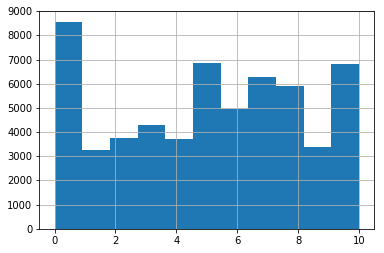

In [16]:
max_like_corbyn = BES_reduced_with_na[search(BES_reduced_with_na,"likeCorbyn").index].max(axis=1)
max_like_corbyn.hist(bins=11)


In [68]:
search(BES_reduced_with_na,"likeCorbyn").index

likeCorbynW7__Strongly like     28788
likeCorbynW8__Strongly like     31377
likeCorbynW9__Strongly like     28432
likeCorbynW10__Strongly like    27784
likeCorbynW11__Strongly like    28858
likeCorbynW12__Strongly like    32400
likeCorbynW13__Strongly like    29752
likeCorbynW14__Strongly like    29228
dtype: int64

In [9]:
search(BES_Panel,"bestPM",case_sensitive=False)

bestPMW7     30895
bestPMW8     33502
bestPMW10    30237
bestPMW11    30956
bestPMW12    34394
dtype: int64

In [72]:
ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

likeCorbyn


likeCorbyn(W7->W8)__Strongly like      22264
likeCorbyn(W8->W9)__Strongly like      25378
likeCorbyn(W9->W10)__Strongly like     17716
likeCorbyn(W10->W11)__Strongly like    19896
likeCorbyn(W11->W12)__Strongly like    23325
likeCorbyn(W12->W13)__Strongly like    24750
likeCorbyn(W13->W14)__Strongly like    18977
dtype: int64

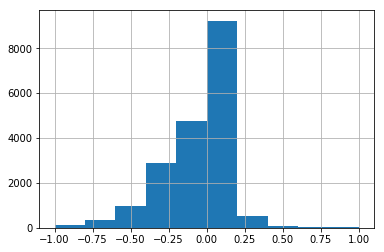

In [85]:
ImmigDiff[ImmigDiff.columns[-1]].hist()

In [91]:
BES_Panel["profile_eurefvote"]

0                 Leave the EU
1                 Leave the EU
2                 Leave the EU
3                          NaN
4                          NaN
5                 Leave the EU
6        Stay/remain in the EU
7                 Leave the EU
8        Stay/remain in the EU
9        Stay/remain in the EU
10                Leave the EU
11                         NaN
12                         NaN
13                Leave the EU
14                Leave the EU
15                         NaN
16                Leave the EU
17       Stay/remain in the EU
18       Stay/remain in the EU
19                         NaN
20                         NaN
21       Stay/remain in the EU
22                Leave the EU
23       Stay/remain in the EU
24                         NaN
25                         NaN
26                         NaN
27                         NaN
28                Leave the EU
29       Stay/remain in the EU
                 ...          
73673             Leave the EU
73674   

In [26]:
(BES_reduced_with_na["profile_gross_personal__£100,000 and over"][(BES_Panel["profile_eurefvote"]=="Leave the EU")]>=3.0).value_counts()

False    15553
True      7725
Name: profile_gross_personal__£100,000 and over, dtype: int64

In [33]:
Treatment = "Hich_vs_LowInc_Leavers"
var_stub = "profile_gross"

var_list = ['profile_gross_personal__£100,000 and over']
var_stub_list = [var_stub, "profile_education_age","workingStatus","profile_work_stat",]

# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = True
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return (BES_Panel["profile_eurefvote"]=="Leave the EU")



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    
    return (BES_reduced_with_na["profile_gross_personal__£100,000 and over"]>=3.0)

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.01,
 n_estimators= 200,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



In [92]:
Treatment = "likeCorbyn_changes"
var_stub = "likeCorbyn"

var_list = [x for x in BES_reduced_with_na.columns if re.match(var_stub,x)]
var_stub_list = [var_stub,"likeLab","bestPM"]

ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

var_list = ImmigDiff.columns

optional_mask = True
sample_wts = True
drop_other_waves = True


# default no wave
def optional_mask_fn(wave=[]):
    if wave:
        return (BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0)&(ImmigDiff[ImmigDiff.columns[-1]]<=0)&(BES_Panel["profile_eurefvote"]=="Stay/remain in the EU")



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    
    return ImmigDiff[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.01,
 n_estimators= 200,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



likeCorbyn


In [68]:
Treatment = "bestPMW12"
var_stub = "bestPMW12"

var_list = [x for x in BES_reduced_with_na.columns if re.match(var_stub,x)]
var_stub_list = [var_stub]

var_list


# default no wave
def optional_mask_fn(wave=[]):
    if wave:
        return 1



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]





In [11]:
Treatment = "profile_newspaper"
var_stub = "profile_newspaper"

var_list = [var_stub]


['profile_newspaperW10',
 'profile_newspaperW11',
 'profile_newspaperW13',
 'profile_newspaper']

In [15]:
Treatment = "generalElectionVoteW12"
var_stub = "generalElectionVoteW12"

var_list = [x for x in BES_Panel.columns if re.match(var_stub,x)]
var_stub_list = [var_stub]

objective = 'multi:softmax'
eval_metric = 'mlogloss'

## SUPER SLOW!
## hits memory problem in shap

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

optional_mask = False
sample_wts = False
drop_other_waves = False
    
alg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=.85,
       colsample_bytree=.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, n_estimators=20,
       n_jobs=3, objective=objective, random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=.75,
       num_class = len( BES_Panel["generalElectionVoteW12"].cat.categories )
                   )

# # default no wave
def optional_mask_fn(wave=[]):
    if wave:
        return 1



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
#     if drop_other_waves:
#         # drop variables from other waves
#         other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
#         keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
#     # drop key variables
#     keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list]#[mask]


def create_target(target_var):
    
    return BES_Panel[target_var]#.cat.codes



var_list

['generalElectionVoteW12']

In [78]:
Treatment = "Sov_vs_imm"
var_stub = "euMIISmallW\d_Sovereignty"

var_list = [x for x in BES_reduced_with_na.columns if re.match(var_stub,x)]
var_stub_list = ["euMIISmallW","EUMIICategory","small_mii_cat","mii_cat"]

optional_mask = True



objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1
    
# alg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel= 0.825,
#        colsample_bytree=0.7, gamma=0.65, learning_rate=0.2, 
#        max_depth=1, min_child_weight=4, n_estimators=900,
#        n_jobs=3, objective=objective, random_state=seed,
#        scale_pos_weight=1,
#        subsample=.7
#                    )

alg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel= 0.825,
       colsample_bytree=0.6, gamma=0.7, learning_rate=0.125, 
       max_depth=1, min_child_weight=6.0, n_estimators=781,
       n_jobs=3, objective=objective, random_state=seed,
       scale_pos_weight=1,
       subsample=.5 )

# {'colsample_bytree': [0.6000000000000001],
#    'gamma': [0.7000000000000001],
#    'learning_rate': [0.125],
#    'max_depth': [0],
#    'min_child_weight': [6.0],
#    'n_estimators': [781],
#    'subsample': [0.5]}
var_list

# default no wave
def optional_mask_fn(wave=[]):
    if wave:
        return (BES_reduced_with_na['profile_eurefvote_Leave the EU']==1.0) & \
            (BES_reduced_with_na[[ re.sub('\d+',str(wave),x) for x in ['euMIISmallW7_Immigration','euMIISmallW7_Sovereignty/EU bureaucracy'] ]]==1.0).any(axis=1)


def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]




In [89]:
BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure_|profile_gross_household_"+\
                           "|profile_gross_personal_|age")].notnull()[BES_reduced_with_na["profile_eurefvote_Leave the EU"].notnull()].sum().sort_values()
# profile_gross_household__£150,000 and over
# profile_gross_personal__£100,000 and over
# |edlevelW8W9W10__Postgrad, ageW8

# # homeamtb, homeAmtb, profile_house_tenure, profile_work_stat, mainSourceIncome, edlevel, savingsAmtb

profile_work_typeW2_W4_Clerical/junior managerial/professional/administrator (e.g. office worker, student doctor, sales person, clerk, secretar     4019
profile_work_typeW2_W4_Professional or higher technical work / higher managerial - work that requires at least degree-level qualifications (e.g     4019
profile_work_typeW2_W4_Manager or Senior Administrator / intermediate managerial / professional (e.g. company director, finance manager, person     4019
mortgagePaymentW14__100.0                                                                                                                           5456
prPreferenceW9_That every party's percentage of seats in parliament is the same as their percentage of the vote                                     5692
buyHomeFutureW14_Yes, I will be able to buy with a mortgage                                                                                         5880
integrityFarageW10__Complete integrity                                            

In [90]:
# BES_reduced_with_na["profile_eurefvote_Leave the EU"].value_counts()

In [91]:
Treatment = "euRef_by_I&W"
var_stub = "profile_eurefvote_Leave the EU"

var_list = [x for x in BES_reduced_with_na.columns if re.match(var_stub,x)]
var_stub_list = ["profile_eurefvote","euRefVote"]

optional_mask = False
sample_wts = False
drop_other_waves = False


objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1
    

alg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=.85,
       colsample_bytree=.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, n_estimators=2000,
       n_jobs=3, objective=objective, random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=.75
                   )

var_list

# default no wave
def optional_mask_fn(wave=[]):
    return 1


def create_train(drop_other_waves):
#     keep_list = BES_reduced_with_na.columns
    
#     if drop_other_waves:
#         # drop variables from other waves
#         other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
#         keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
#     # drop key variables
#     keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
# profile_gross_household__£150,000 and over
# profile_gross_personal__£100,000 and over 
    keep_list = ["profile_gross_household__£150,000 and over", "profile_gross_personal__£100,000 and over"]
    keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure|profile_gross|profile_house_tenure|profile_work_stat|mainSourceIncome|edlevel")].notnull().sum().index)
    keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure_|profile_gross_household_"+\
                           "|profile_gross_personal_|age")])
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]




In [99]:
cleaned_ages = pd.read_msgpack(BES_small_data_files+"cleaned_ages" )
BES_reduced_with_na["cleaned_ages"] = cleaned_ages
# cleaned_ages

In [100]:
Treatment = "AgePrediction_with_cleaned_ages"
var_stub = "Age"

var_list = ["cleaned_ages"]
var_stub_list = ['ageW1', 'ageW7', 'ageW8', 'ageW9', 'ageW11', 'ageW12', 'ageW13',
       'ageW14', 'age', 'Age','ageGroup__66+']

optional_mask = False
sample_wts = False
drop_other_waves = False


objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1
    

alg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=.85,
       colsample_bytree=.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, n_estimators=2000,
       n_jobs=3, objective=objective, random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=.75
                   )

var_list

# default no wave
def optional_mask_fn(wave=[]):
    return 1


def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
#     if drop_other_waves:
#         # drop variables from other waves
#         other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
#         keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
#     # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
# profile_gross_household__£150,000 and over
# profile_gross_personal__£100,000 and over 
#     keep_list = ["profile_gross_household__£150,000 and over", "profile_gross_personal__£100,000 and over"]
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure|profile_gross|profile_house_tenure|profile_work_stat|mainSourceIncome|edlevel")].notnull().sum().index)
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure_|profile_gross_household_"+\
#                            "|profile_gross_personal_|age")])
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var].apply(lambda x: min(x,89))




In [33]:
search(BES_reduced_with_na , "profile_euref")

profile_eurefvote_Leave the EU    49325
profile_eurefturnout_Yes          55064
dtype: int64

In [32]:
search(BES_reduced_with_na , "housing_|profile_house_tenure")

housing_Own the leasehold/freehold outright                                                                     30635
housing_Buying leasehold/freehold on a mortgage                                                                 30635
housing_Rented from private landlord                                                                            30635
housing_Rented from local authority                                                                             30635
housing_It belongs to a Housing Association                                                                     30635
profile_house_tenureW10_Own outright                                                                            29715
profile_house_tenureW10_Own with a mortgage                                                                     29715
profile_house_tenureW10_Rent from a private landlord                                                            29715
profile_house_tenureW10_Rent from a housing association 

In [87]:
search(BES_reduced_with_na , "profile_house_tenure_|^Age$", case_sensitive=True)

Age                                                                                                        39142
profile_house_tenure_Own outright                                                                          54998
profile_house_tenure_Own with a mortgage                                                                   54998
profile_house_tenure_Rent from a private landlord                                                          54998
profile_house_tenure_Rent from a housing association                                                       54998
profile_house_tenure_Rent from my local authority                                                          54998
profile_house_tenure_Neither I live rent-free with my parents, family or friends                           54998
profile_house_tenure_Neither I live with my parents, family or friends but pay some rent to them           54998
profile_house_tenure_Own (part-own) through shared ownership scheme (i.e. pay part mortgage, par

In [88]:
Treatment = "euRef_pred_by_housing_and_age"
var_stub = "profile_eurefvote_Leave the EU"

var_list = [var_stub]
var_stub_list = [var_stub]

optional_mask = False
sample_wts = False
drop_other_waves = False


objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1
    

alg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=.85,
       colsample_bytree=.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, n_estimators=2000,
       n_jobs=3, objective=objective, random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=.75
                   )

var_list

# default no wave
def optional_mask_fn(wave=[]):
    return 1


def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    keep_list = search(BES_reduced_with_na , "profile_house_tenure_|^Age$", case_sensitive=True).index
    
#     if drop_other_waves:
#         # drop variables from other waves
#         other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
#         keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
#     # drop key variables
#     keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
# profile_gross_household__£150,000 and over
# profile_gross_personal__£100,000 and over 
#     keep_list = ["profile_gross_household__£150,000 and over", "profile_gross_personal__£100,000 and over"]
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure|profile_gross|profile_house_tenure|profile_work_stat|mainSourceIncome|edlevel")].notnull().sum().index)
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure_|profile_gross_household_"+\
#                            "|profile_gross_personal_|age")])
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]#.apply(lambda x: min(x,89))




In [53]:
Treatment = "profile_newspaper_multi"
var_stub = "profile_newspaper"

var_list = [var_stub]
var_stub_list = [var_stub,"newspaper"]

# objective = 'multi:softmax'
# eval_metric = 'mlogloss'

objective = 'multi:softmax'
eval_metric = "merror"

## SUPER SLOW!
## hits memory problem in shap

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

optional_mask = False
sample_wts = False
drop_other_waves = False
    
alg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=.85,
       colsample_bytree=.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, n_estimators=3,
       n_jobs=3, objective=objective, random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=.75)
# ,
#        num_class = len( BES_Panel[var_stub].cat.categories )
#                    )

drop_list = ["None","The Scotsman","The Western Mail","The Herald (Glasgow)","Other Newspaper","Other local daily morning newspaper"]
broadsheet_list = ["The Guardian", "The Daily Telegraph", "The Independent", "The Times", "The Financial Times"]

# # default no wave
def optional_mask_fn(wave=None):
    if wave is None:
        return BES_Panel[target_var].apply(lambda x: x not in drop_list)



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
#     if drop_other_waves:
#         # drop variables from other waves
#         other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
#         keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    return BES_Panel[target_var].cat.codes
#     return BES_Panel[target_var].apply(lambda x: x in broadsheet_list).astype('int')



var_list

['profile_newspaper']

In [8]:
BES_reduced_with_na["amalgamated_climateChange"] = amalgamate_waves(BES_reduced_with_na,"climateChange")
BES_reduced_with_na["amalgamated_enviroprotection"] = amalgamate_waves(BES_reduced_with_na,"enviroProtection")
BES_reduced_with_na["amalgamated_enviroGrowth"] = amalgamate_waves(BES_reduced_with_na,"enviroGrowth")

Amalgamating variables: 
{7: 'climateChangeW7__Climate not changing', 10: 'climateChangeW10__Climate not changing', 11: 'climateChangeW11__Climate not changing'}


In [78]:
Treatment = "ClimateChange"
var_stub = "amalgamated_climateChange"

var_list = [var_stub]
var_stub_list = [var_stub,"climateChange", "enviroGrowth","enviroProtection",
                 "Bennett","grn","Grn","Lucas","handleMIIGrn","amalgamated",
                 "Green","green"]

optional_mask = False
sample_wts = False
drop_other_waves = False


objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1
    

alg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=.85,
       colsample_bytree=.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, n_estimators=100,
       n_jobs=3, objective=objective, random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=.75
                   )

var_list

# default no wave
def optional_mask_fn(wave=[]):
    return 1


def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
#     keep_list = search(BES_reduced_with_na , "profile_house_tenure_|^Age$", case_sensitive=True).index
    
#     if drop_other_waves:
#         # drop variables from other waves
#         other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
#         keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
# profile_gross_household__£150,000 and over
# profile_gross_personal__£100,000 and over 
#     keep_list = ["profile_gross_household__£150,000 and over", "profile_gross_personal__£100,000 and over"]
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure|profile_gross|profile_house_tenure|profile_work_stat|mainSourceIncome|edlevel")].notnull().sum().index)
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure_|profile_gross_household_"+\
#                            "|profile_gross_personal_|age")])
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]#.apply(lambda x: min(x,89))




In [60]:
Treatment = "enviroProtection"
var_stub = "amalgamated_enviroprotection"

var_list = [var_stub]
var_stub_list = [var_stub,"climateChange", "enviroGrowth","enviroProtection",
                 "Bennett","grn","Grn","Lucas","handleMIIGrn","amalgamated",
                 "Green","green"]
optional_mask = False
sample_wts = False
drop_other_waves = False


objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1
    

alg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=.85,
       colsample_bytree=.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, n_estimators=100,
       n_jobs=3, objective=objective, random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=.75
                   )

var_list

# default no wave
def optional_mask_fn(wave=[]):
    return 1


def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
#     keep_list = search(BES_reduced_with_na , "profile_house_tenure_|^Age$", case_sensitive=True).index
    
#     if drop_other_waves:
#         # drop variables from other waves
#         other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
#         keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
# profile_gross_household__£150,000 and over
# profile_gross_personal__£100,000 and over 
#     keep_list = ["profile_gross_household__£150,000 and over", "profile_gross_personal__£100,000 and over"]
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure|profile_gross|profile_house_tenure|profile_work_stat|mainSourceIncome|edlevel")].notnull().sum().index)
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure_|profile_gross_household_"+\
#                            "|profile_gross_personal_|age")])
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]#.apply(lambda x: min(x,89))




In [70]:
Treatment = "enviroGrowth"
var_stub = "amalgamated_enviroGrowth"

var_list = [var_stub]
var_stub_list = [var_stub,"climateChange", "enviroGrowth","enviroProtection",
                 "Bennett","grn","Grn","Lucas","handleMIIGrn","amalgamated",
                 "Green","green"]

optional_mask = False
sample_wts = False
drop_other_waves = False


objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1
    

alg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=.85,
       colsample_bytree=.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, n_estimators=100,
       n_jobs=3, objective=objective, random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=.75
                   )

var_list

# default no wave
def optional_mask_fn(wave=[]):
    return 1


def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
#     keep_list = search(BES_reduced_with_na , "profile_house_tenure_|^Age$", case_sensitive=True).index
    
#     if drop_other_waves:
#         # drop variables from other waves
#         other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
#         keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
# profile_gross_household__£150,000 and over
# profile_gross_personal__£100,000 and over 
#     keep_list = ["profile_gross_household__£150,000 and over", "profile_gross_personal__£100,000 and over"]
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure|profile_gross|profile_house_tenure|profile_work_stat|mainSourceIncome|edlevel")].notnull().sum().index)
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure_|profile_gross_household_"+\
#                            "|profile_gross_personal_|age")])
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]#.apply(lambda x: min(x,89))




In [61]:
gc.collect()

15311

[0]	validation_0-rmse:0.58722
Will train until validation_0-rmse hasn't improved in 10.0 rounds.
[1]	validation_0-rmse:0.585848
[2]	validation_0-rmse:0.584498
[3]	validation_0-rmse:0.583125
[4]	validation_0-rmse:0.581829
[5]	validation_0-rmse:0.580559
[6]	validation_0-rmse:0.579291
[7]	validation_0-rmse:0.578073
[8]	validation_0-rmse:0.576859
[9]	validation_0-rmse:0.575638
[10]	validation_0-rmse:0.574461
[11]	validation_0-rmse:0.573309
[12]	validation_0-rmse:0.572131
[13]	validation_0-rmse:0.570998
[14]	validation_0-rmse:0.569919
[15]	validation_0-rmse:0.56884
[16]	validation_0-rmse:0.567786
[17]	validation_0-rmse:0.566762
[18]	validation_0-rmse:0.56566
[19]	validation_0-rmse:0.564649
[20]	validation_0-rmse:0.563656
[21]	validation_0-rmse:0.562653
[22]	validation_0-rmse:0.561698
[23]	validation_0-rmse:0.560753
[24]	validation_0-rmse:0.559787
[25]	validation_0-rmse:0.558835
[26]	validation_0-rmse:0.55793
[27]	validation_0-rmse:0.55706
[28]	validation_0-rmse:0.556172
[29]	validation_0-rm

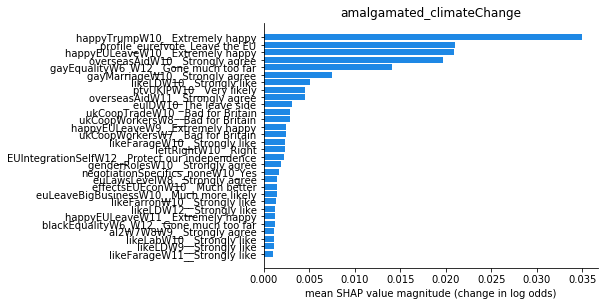

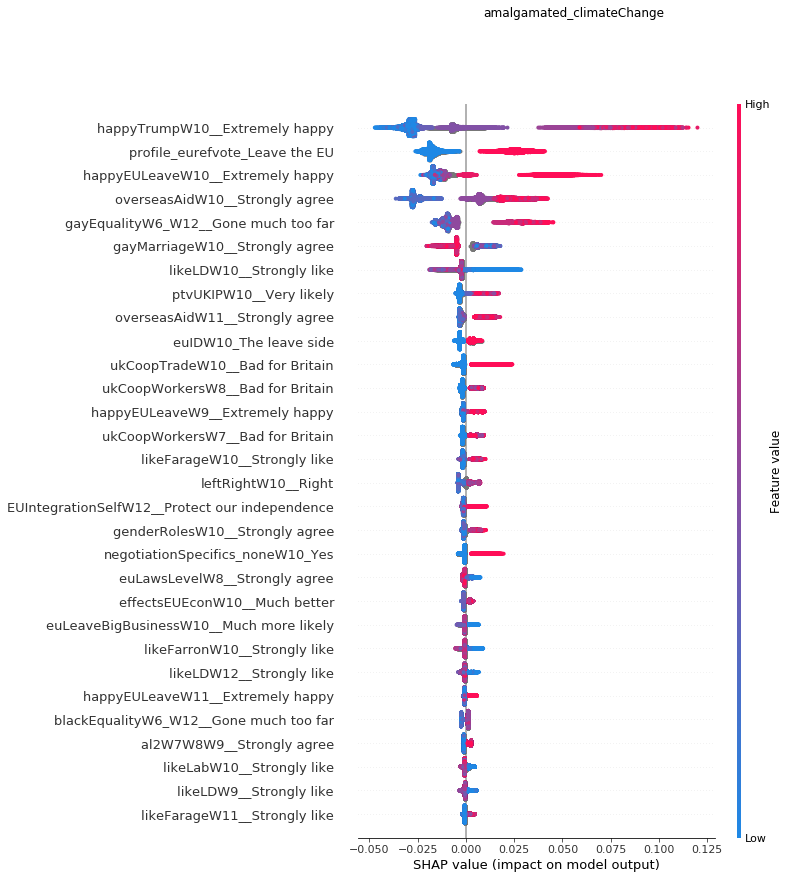

Wall time: 4min 51s


In [79]:
%%time
# for target_var,base_var in zip(var_list,base_list):
treatment_subfolder = create_subdir(BES_output_folder,"xgb_regr"+Treatment)

for target_var in var_list:
    if sample_wts:
        wave_no = get_wave_no( target_var )
        weight_var = num_to_weight[wave_no]    
        print( target_var, wave_no )
    
    target = create_target(target_var)
    mask   = target.notnull()
    if optional_mask & sample_wts:
        mask = mask&optional_mask_fn(wave_no)
    else:
        mask = mask&optional_mask_fn()
    target = target[mask]
    
    if sum(mask) < minimum_sample:
        continue
    
    train = create_train(drop_other_waves)
    
    output_subfolder = create_subdir(treatment_subfolder,target_var)

    
    if sample_wts:
        sample_weights = weights[weight_var][mask]
        print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
        sample_weights = sample_weights.fillna(sample_weights.median())
    else:
        sample_weights = None
#         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
#         # fit to full dataset at non-overfitting level
#         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
#     else:

    get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights=sample_weights )
    # fit to full dataset at non-overfitting level
    alg.fit(train, target, verbose = True, sample_weight = sample_weights)


#################

    shap_values = shap.TreeExplainer(alg).shap_values(train);
    
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        print("hit problem!")
        shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

    shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1, min_features = 30)


In [75]:
gc.collect()

42

In [105]:
keep_list = BES_reduced_with_na.columns

keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
# keep_list

In [106]:
pred_ages = alg.predict(BES_reduced_with_na[keep_list])

In [111]:
pred_ages = pd.DataFrame(pred_ages,columns=["pred_ages"])
pred_ages.to_msgpack(BES_small_data_files+"pred_ages" )

In [25]:
len( [x for x in train.columns if re.match("ukip|UKIP|euref|euRef|eu",x)])
train.shape
300/6851

0.04378922784994891

In [ ]:
# likeLab, bestPM
# generalElectionVote, ptvLab

In [96]:
# shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1, min_features = 30)

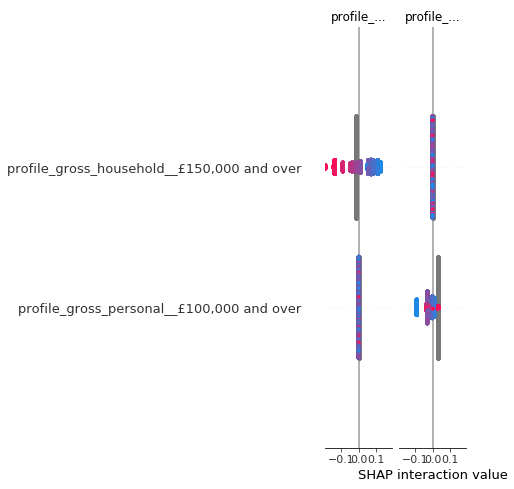

In [64]:
# # shap_values = shap.TreeExplainer(alg).shap_values(train);
# shap_interaction_values = shap.TreeExplainer(alg).shap_interaction_values(train)
# shap.summary_plot(shap_interaction_values, train)


In [ ]:
# WORKS but makes page slow!
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[::130,:],train.iloc[::130,:])

In [70]:
# lr, mcw, ss

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 200,
 max_depth=3,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=1,
 reg_lambda=100,
 njobs=3,
 seed=seed**2)

X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                     target, test_size=test_size,
                                                     random_state=seed, stratify=round(target) )

eval_set = [(X_test, y_test)]

sample_weight = X_train[weight_var].values
sample_weight_eval_set = X_test[weight_var].values
X_train.drop(weight_var, axis=1, inplace=True)
X_test.drop(weight_var, axis=1, inplace=True)

param_test1 ={
 'min_child_weight':[1,6],
 'learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
 'subsample':[.8, .75],
}

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)

gsearch1 = GridSearchCV(estimator = alg,
                        param_grid = param_test1,
                        scoring='r2', #'r2'
                        n_jobs=4, 
                        iid=False,
                        cv=skf,
                        verbose=True)

gsearch1.fit(X_train, y_train, eval_metric='rmse',
        early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
        verbose=True, sample_weight= sample_weight)

display(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:  2.2min finished


[0]	validation_0-rmse:0.498485
Will train until validation_0-rmse hasn't improved in 20.0 rounds.
[1]	validation_0-rmse:0.497161
[2]	validation_0-rmse:0.495783
[3]	validation_0-rmse:0.494419
[4]	validation_0-rmse:0.493166
[5]	validation_0-rmse:0.491863
[6]	validation_0-rmse:0.490867
[7]	validation_0-rmse:0.489868
[8]	validation_0-rmse:0.488858
[9]	validation_0-rmse:0.487766
[10]	validation_0-rmse:0.486907
[11]	validation_0-rmse:0.485976
[12]	validation_0-rmse:0.484926
[13]	validation_0-rmse:0.484175
[14]	validation_0-rmse:0.483328
[15]	validation_0-rmse:0.482605
[16]	validation_0-rmse:0.481957
[17]	validation_0-rmse:0.481268
[18]	validation_0-rmse:0.480465
[19]	validation_0-rmse:0.479854
[20]	validation_0-rmse:0.479218
[21]	validation_0-rmse:0.478535
[22]	validation_0-rmse:0.478049
[23]	validation_0-rmse:0.477426
[24]	validation_0-rmse:0.476776
[25]	validation_0-rmse:0.476157
[26]	validation_0-rmse:0.475672
[27]	validation_0-rmse:0.475031
[28]	validation_0-rmse:0.474474
[29]	validation

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C

{'mean_fit_time': array([7.24741475, 7.66377171, 7.48009451, 7.4984289 , 7.19474483,
        7.60276818, 7.465427  , 6.9643983 , 6.75371957, 7.16907676,
        6.95339775, 7.10940663, 6.89639449, 7.12740787, 6.88372715,
        6.81572318, 6.73638511, 6.92806284, 6.7977221 , 6.81238969,
        6.71338399, 6.26802516, 7.05373669, 6.00767692]),
 'std_fit_time': array([0.08402072, 0.35027736, 0.21193084, 0.15789704, 0.02776657,
        0.21301654, 0.62516667, 0.0700182 , 0.02469058, 0.20789381,
        0.06497043, 0.18358787, 0.09509827, 0.10044485, 0.11109888,
        0.05700804, 0.06207343, 0.01515205, 0.06600533, 0.08703382,
        0.04699899, 1.04728152, 0.37625942, 1.05212988]),
 'mean_score_time': array([0.03733524, 0.04100227, 0.03333529, 0.03200181, 0.03533546,
        0.03500199, 0.03266859, 0.03266859, 0.03266851, 0.03333529,
        0.03433537, 0.03200189, 0.03266851, 0.03200181, 0.03300174,
        0.03266851, 0.03500215, 0.03333529, 0.03300182, 0.03500199,
        0.032335

{'learning_rate': 0.04, 'min_child_weight': 1, 'subsample': 0.75}

0.1641235151483538

In [62]:
### xgboost_tuner
# https://github.com/cwerner87/xgboost-tuner

from xgboost_tuner.tuner import tune_xgb_params

# train = X.values
# label = rounded_targets

# metric_sklearn = ‘neg_mean_squared_error’ or 'remse'
# estimator_cls = xgb.XGBClassifier, xgb.XGBRegressor


# Tune the parameters incrementally and limit the range for colsample_bytree and subsample
best_params, history = tune_xgb_params(
    cv_folds = 3,
    label = target,
    metric_sklearn = 'neg_mean_squared_error',
    metric_xgb = "rmse",
    n_jobs = 4,
    objective = 'reg:linear',
    random_state = seed,
    strategy = 'incremental',
    train = train,
    init_colsample_bytree = 0.9,
    init_gamma = 0.0,
    init_max_depth = 3,
    init_min_child_weight  = 1,
    init_subsample = 0.75,
    learning_rates = [0.03,.04,.05],
)

[0]	train-rmse:0.497144+6.08331e-05	test-rmse:0.497818+0.000292193
[1]	train-rmse:0.494301+0.000139045	test-rmse:0.49545+0.000314938
[2]	train-rmse:0.491724+0.000204943	test-rmse:0.49354+0.000512929
[3]	train-rmse:0.489185+0.000241751	test-rmse:0.491277+0.000471619
[4]	train-rmse:0.486836+0.000259562	test-rmse:0.489383+0.000607157
[5]	train-rmse:0.484573+0.000342245	test-rmse:0.487802+0.000863712
[6]	train-rmse:0.482502+0.000399881	test-rmse:0.486272+0.00102169
[7]	train-rmse:0.480602+0.000548731	test-rmse:0.484854+0.00106231
[8]	train-rmse:0.478689+0.000549005	test-rmse:0.483417+0.00107709
[9]	train-rmse:0.476885+0.00051608	test-rmse:0.482045+0.00128936
[10]	train-rmse:0.475152+0.000561471	test-rmse:0.480761+0.00146676
[11]	train-rmse:0.473531+0.000611852	test-rmse:0.479591+0.00152938
[12]	train-rmse:0.471956+0.000548956	test-rmse:0.478455+0.00171126
[13]	train-rmse:0.470417+0.000558394	test-rmse:0.477304+0.00185039
[14]	train-rmse:0.468933+0.000569547	test-rmse:0.476398+0.0020622
[15

[123]	train-rmse:0.40169+0.000634805	test-rmse:0.449926+0.00163249
[124]	train-rmse:0.401347+0.000666019	test-rmse:0.449923+0.00172488
[125]	train-rmse:0.401054+0.00062853	test-rmse:0.449865+0.00174506
[126]	train-rmse:0.400683+0.000615499	test-rmse:0.449781+0.00166399
[127]	train-rmse:0.400331+0.000610755	test-rmse:0.449812+0.00171421
[128]	train-rmse:0.399996+0.000543265	test-rmse:0.449642+0.00173735
[129]	train-rmse:0.39967+0.000549646	test-rmse:0.44964+0.0016838
[130]	train-rmse:0.399386+0.000561967	test-rmse:0.449663+0.00170887
[131]	train-rmse:0.399047+0.000532703	test-rmse:0.449725+0.0017258
[132]	train-rmse:0.398685+0.000528528	test-rmse:0.449731+0.00170655
[133]	train-rmse:0.398279+0.000501243	test-rmse:0.449646+0.00169244
[134]	train-rmse:0.398017+0.000542756	test-rmse:0.44961+0.0016682
[135]	train-rmse:0.397719+0.000534865	test-rmse:0.44953+0.00168958
[136]	train-rmse:0.397376+0.000521864	test-rmse:0.449488+0.00171812
[137]	train-rmse:0.397096+0.000522962	test-rmse:0.449469+

[245]	train-rmse:0.367098+0.00102075	test-rmse:0.448558+0.00145608
[246]	train-rmse:0.366887+0.000978461	test-rmse:0.448553+0.00149559
[247]	train-rmse:0.366601+0.000967354	test-rmse:0.448554+0.00146326
[248]	train-rmse:0.366416+0.00100973	test-rmse:0.448602+0.00148216
[249]	train-rmse:0.36615+0.000991049	test-rmse:0.448502+0.00146387
[250]	train-rmse:0.365911+0.00100072	test-rmse:0.448503+0.00155194
[251]	train-rmse:0.365682+0.00104839	test-rmse:0.448452+0.00153608
[252]	train-rmse:0.365444+0.0010256	test-rmse:0.448457+0.00161004
[253]	train-rmse:0.3652+0.00102778	test-rmse:0.448488+0.0015847
[254]	train-rmse:0.365001+0.00102455	test-rmse:0.448475+0.00152963
[255]	train-rmse:0.364799+0.00108571	test-rmse:0.448441+0.00151006
[256]	train-rmse:0.364483+0.00109017	test-rmse:0.448451+0.00154492
[257]	train-rmse:0.364224+0.00113293	test-rmse:0.448475+0.0015106
[258]	train-rmse:0.364014+0.00111902	test-rmse:0.448441+0.00155046
[259]	train-rmse:0.363793+0.00107987	test-rmse:0.448453+0.0015396

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 11.6min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 14.1min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 17.7min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 18.9min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   44.0s
[Parallel(n_jobs=4)]: Done  13 out of  18 | elapsed:   57.8s remaining:   22.2s
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:   59.2s remaining:   11.8s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  1.2min finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   50.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  4.2min finished


Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   28.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:  3.5min finished


Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   28.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   44.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:  3.7min finished


[0]	train-rmse:0.498157+6.62437e-05	test-rmse:0.498552+0.000260671
[1]	train-rmse:0.496308+0.000139333	test-rmse:0.497111+0.000214739
[2]	train-rmse:0.494537+0.000189839	test-rmse:0.495736+0.000286271
[3]	train-rmse:0.492838+0.000246085	test-rmse:0.494429+0.000243608
[4]	train-rmse:0.491208+0.000339918	test-rmse:0.49316+0.00037361
[5]	train-rmse:0.489643+0.000400221	test-rmse:0.492044+0.00058393
[6]	train-rmse:0.488171+0.000422539	test-rmse:0.490813+0.000763348
[7]	train-rmse:0.486682+0.00049199	test-rmse:0.489705+0.000784951
[8]	train-rmse:0.485299+0.000520992	test-rmse:0.488625+0.000876746
[9]	train-rmse:0.484014+0.000580476	test-rmse:0.487753+0.000886955
[10]	train-rmse:0.482741+0.000691065	test-rmse:0.486804+0.000894354
[11]	train-rmse:0.481475+0.000789651	test-rmse:0.485834+0.00100036
[12]	train-rmse:0.480278+0.000779227	test-rmse:0.484959+0.00105789
[13]	train-rmse:0.479076+0.000735585	test-rmse:0.484016+0.00119329
[14]	train-rmse:0.477924+0.000717794	test-rmse:0.483189+0.0013235

[123]	train-rmse:0.424824+0.000744085	test-rmse:0.453092+0.00226002
[124]	train-rmse:0.424586+0.000738601	test-rmse:0.453038+0.00234002
[125]	train-rmse:0.424309+0.000711751	test-rmse:0.452937+0.00231692
[126]	train-rmse:0.424045+0.000724641	test-rmse:0.45286+0.00231889
[127]	train-rmse:0.423793+0.000715731	test-rmse:0.452738+0.00232186
[128]	train-rmse:0.423545+0.000714844	test-rmse:0.452722+0.00234035
[129]	train-rmse:0.423322+0.000728208	test-rmse:0.452656+0.00233479
[130]	train-rmse:0.423044+0.000711179	test-rmse:0.452686+0.00232227
[131]	train-rmse:0.422799+0.000759198	test-rmse:0.452674+0.00237064
[132]	train-rmse:0.422588+0.000752548	test-rmse:0.452588+0.00237088
[133]	train-rmse:0.422388+0.000777233	test-rmse:0.452483+0.00239125
[134]	train-rmse:0.42217+0.00078747	test-rmse:0.452401+0.00235824
[135]	train-rmse:0.42193+0.000774783	test-rmse:0.452282+0.00239326
[136]	train-rmse:0.421656+0.000779427	test-rmse:0.452186+0.00240794
[137]	train-rmse:0.421405+0.000769713	test-rmse:0.45

[245]	train-rmse:0.400128+0.000929678	test-rmse:0.448847+0.00235607
[246]	train-rmse:0.399971+0.000944955	test-rmse:0.44885+0.00238973
[247]	train-rmse:0.399823+0.000950411	test-rmse:0.44884+0.00236343
[248]	train-rmse:0.399659+0.000948041	test-rmse:0.448782+0.00238079
[249]	train-rmse:0.399495+0.000950573	test-rmse:0.44877+0.00242194
[250]	train-rmse:0.399367+0.000958445	test-rmse:0.448765+0.00239142
[251]	train-rmse:0.399189+0.000949588	test-rmse:0.4487+0.00238233
[252]	train-rmse:0.398997+0.000928609	test-rmse:0.448669+0.00239595
[253]	train-rmse:0.398813+0.000926384	test-rmse:0.448654+0.00236794
[254]	train-rmse:0.398653+0.000944992	test-rmse:0.44865+0.00238307
[255]	train-rmse:0.398501+0.000956406	test-rmse:0.448649+0.00243648
[256]	train-rmse:0.39834+0.000957571	test-rmse:0.448654+0.00243947
[257]	train-rmse:0.398183+0.000959916	test-rmse:0.448657+0.00240814
[258]	train-rmse:0.398003+0.000967334	test-rmse:0.448603+0.00238841
[259]	train-rmse:0.397856+0.00095089	test-rmse:0.448613

[55]	train-rmse:0.45573+0.000646363	test-rmse:0.468308+0.00225716
[56]	train-rmse:0.455271+0.000661018	test-rmse:0.468041+0.00228327
[57]	train-rmse:0.454817+0.000690345	test-rmse:0.467697+0.00226237
[58]	train-rmse:0.454363+0.00067649	test-rmse:0.467474+0.00227711
[59]	train-rmse:0.453919+0.000658061	test-rmse:0.467187+0.00221796
[60]	train-rmse:0.453502+0.000639707	test-rmse:0.46695+0.00217845
[61]	train-rmse:0.453085+0.00062786	test-rmse:0.46669+0.00213872
[62]	train-rmse:0.452655+0.000597941	test-rmse:0.46642+0.0021184
[63]	train-rmse:0.452229+0.000613649	test-rmse:0.466204+0.00217252
[64]	train-rmse:0.451846+0.000588965	test-rmse:0.465984+0.00219332
[65]	train-rmse:0.451438+0.000558935	test-rmse:0.465739+0.0021568
[66]	train-rmse:0.45103+0.000570102	test-rmse:0.465532+0.00215924
[67]	train-rmse:0.450633+0.000559718	test-rmse:0.465271+0.002108
[68]	train-rmse:0.450247+0.000556738	test-rmse:0.465035+0.00206711
[69]	train-rmse:0.449868+0.000572536	test-rmse:0.464869+0.00209103
[70]	t

[178]	train-rmse:0.422117+0.000811495	test-rmse:0.452676+0.0024861
[179]	train-rmse:0.421931+0.000830468	test-rmse:0.452643+0.00247489
[180]	train-rmse:0.421746+0.00081491	test-rmse:0.452608+0.00245625
[181]	train-rmse:0.421546+0.000818271	test-rmse:0.452584+0.00247029
[182]	train-rmse:0.421373+0.000834138	test-rmse:0.452541+0.00245114
[183]	train-rmse:0.421189+0.000849398	test-rmse:0.452505+0.00244771
[184]	train-rmse:0.421001+0.000841272	test-rmse:0.452437+0.0024131
[185]	train-rmse:0.420808+0.000815937	test-rmse:0.452401+0.00239698
[186]	train-rmse:0.420629+0.000835666	test-rmse:0.452334+0.00233723
[187]	train-rmse:0.420472+0.000845623	test-rmse:0.452266+0.00230199
[188]	train-rmse:0.420284+0.000822612	test-rmse:0.452211+0.00229531
[189]	train-rmse:0.42009+0.000806328	test-rmse:0.452168+0.00226908
[190]	train-rmse:0.419924+0.000804143	test-rmse:0.452133+0.00225347
[191]	train-rmse:0.419759+0.000805018	test-rmse:0.452118+0.00227195
[192]	train-rmse:0.419579+0.000808855	test-rmse:0.45

[300]	train-rmse:0.403309+0.00094234	test-rmse:0.449196+0.00209925
[301]	train-rmse:0.403172+0.000936532	test-rmse:0.449165+0.00209064
[302]	train-rmse:0.403051+0.000947898	test-rmse:0.449172+0.00209318
[303]	train-rmse:0.402937+0.000953179	test-rmse:0.449172+0.00210004
[304]	train-rmse:0.402805+0.000960677	test-rmse:0.449144+0.00210361
[305]	train-rmse:0.402667+0.000962915	test-rmse:0.44912+0.00206875
[306]	train-rmse:0.402548+0.000957962	test-rmse:0.449113+0.00205572
[307]	train-rmse:0.402435+0.000958443	test-rmse:0.449108+0.00202527
[308]	train-rmse:0.402312+0.000952405	test-rmse:0.449115+0.00200853
[309]	train-rmse:0.402198+0.000956754	test-rmse:0.449108+0.00200598
[310]	train-rmse:0.402079+0.000975488	test-rmse:0.449077+0.00203027
[311]	train-rmse:0.401944+0.000975816	test-rmse:0.449061+0.002053
[312]	train-rmse:0.401804+0.000973785	test-rmse:0.449048+0.00208862
[313]	train-rmse:0.401686+0.000978032	test-rmse:0.44905+0.00212175
[314]	train-rmse:0.401561+0.000974223	test-rmse:0.449

[423]	train-rmse:0.388766+0.00106957	test-rmse:0.448528+0.00218765
[424]	train-rmse:0.38866+0.0010662	test-rmse:0.448532+0.00223418
[425]	train-rmse:0.388579+0.0010435	test-rmse:0.448514+0.00221718
[426]	train-rmse:0.388475+0.00103704	test-rmse:0.448504+0.00223265
[427]	train-rmse:0.388349+0.0010372	test-rmse:0.448495+0.00224538
[428]	train-rmse:0.388247+0.00103996	test-rmse:0.448496+0.00222342
[429]	train-rmse:0.388148+0.00101639	test-rmse:0.448497+0.00222984
[430]	train-rmse:0.388031+0.0010204	test-rmse:0.448515+0.00222281
[431]	train-rmse:0.387928+0.00104092	test-rmse:0.448497+0.00220734
[432]	train-rmse:0.387828+0.00103538	test-rmse:0.448519+0.00218266
[433]	train-rmse:0.387727+0.00102493	test-rmse:0.448525+0.00215003
[434]	train-rmse:0.387634+0.00102808	test-rmse:0.448531+0.00211851
[435]	train-rmse:0.387526+0.00101835	test-rmse:0.448549+0.00211487
[436]	train-rmse:0.387419+0.00100883	test-rmse:0.448553+0.00210417
[437]	train-rmse:0.387317+0.00102199	test-rmse:0.448559+0.00209304


In [63]:
best_params

{'colsample_bytree': 0.9,
 'gamma': 0.0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 6,
 'nthread': 4,
 'objective': 'reg:linear',
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'random_state': 27,
 'n_estimators': 263,
 'reg_alpha': 1,
 'reg_lambda': 100}

In [72]:
history

[({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.05,
   'max_depth': 3,
   'min_child_weight': 1,
   'nthread': 4,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 27,
   'n_estimators': 263},
  0.3632053333333333),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.05,
   'max_depth': 3,
   'min_child_weight': 1,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 27,
   'n_estimators': 263},
  0.4491872584358825),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.05,
   'max_depth': 3,
   'min_child_weight': 6,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 27,
   'n_estimators': 263},
  0.4491872584358825),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.05,
   'max_depth': 3,
   'min_child_weight': 6,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 27,
   'n_estimators': 263},
  0.4487462432332829),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.05,
   'max_depth': 3,
   'min_child_weight': 6,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.8,
   'random_state': 27,
   'n_estimators': 263},
  0.448235590406714),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.05,
   'max_depth': 3,
   'min_child_weight': 6,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.8,
   'random_state': 27,
   'n_estimators': 263,
   'reg_alpha': 1},
  0.44821527859219207),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.04,
   'max_depth': 3,
   'min_child_weight': 6,
   'nthread': 4,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.8,
   'random_state': 27,
   'n_estimators': 263,
   'reg_alpha': 1,
   'reg_lambda': 100},
  0.3973706666666666),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.03,
   'max_depth': 3,
   'min_child_weight': 6,
   'nthread': 4,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.8,
   'random_state': 27,
   'n_estimators': 413,
   'reg_alpha': 1,
   'reg_lambda': 100},
  0.3900406666666667)]

In [ ]:
# lr, mcw, ss


alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 200,
 max_depth=3,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=1,
 reg_lambda=100,
 njobs=3,
 seed=seed**2)

In [34]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [35]:
# def score(params):
#     num_round = int(params['n_estimators'])
#     del params['n_estimators']
#     dtrain = xgboost.DMatrix(X_train, label=y_train)
#     dvalid = xgboost.DMatrix(X_val, label=y_val)
#     watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
#     gbm_model = xgboost.train(params, 
#                               dtrain, 
#                               num_round,
#                               evals=watchlist,
#                               verbose_eval=False)
#     predictions = gbm_model.predict(dvalid, ntree_limit=gbm_model.best_iteration)
#     print(gini_normalized(y_val, np.array(predictions)))
#     loss = 1 - gini_normalized(y_val, np.array(predictions))
#     return {'loss': loss, 'status': STATUS_OK}
 

In [67]:
get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                          sample_weights=sample_weights )

[0]	validation_0-rmse:0.497566
Will train until validation_0-rmse hasn't improved in 26.0 rounds.
[1]	validation_0-rmse:0.494937
[2]	validation_0-rmse:0.49206
[3]	validation_0-rmse:0.489773
[4]	validation_0-rmse:0.487909
[5]	validation_0-rmse:0.48654
[6]	validation_0-rmse:0.485164
[7]	validation_0-rmse:0.484203
[8]	validation_0-rmse:0.483205
[9]	validation_0-rmse:0.482522
[10]	validation_0-rmse:0.481698
[11]	validation_0-rmse:0.480235
[12]	validation_0-rmse:0.479526
[13]	validation_0-rmse:0.478882
[14]	validation_0-rmse:0.477909
[15]	validation_0-rmse:0.476721
[16]	validation_0-rmse:0.475948
[17]	validation_0-rmse:0.475363
[18]	validation_0-rmse:0.474171
[19]	validation_0-rmse:0.472926
[20]	validation_0-rmse:0.472447
[21]	validation_0-rmse:0.471774
[22]	validation_0-rmse:0.471145
[23]	validation_0-rmse:0.47129
[24]	validation_0-rmse:0.470393
[25]	validation_0-rmse:0.469888
[26]	validation_0-rmse:0.469683
[27]	validation_0-rmse:0.469011
[28]	validation_0-rmse:0.468855
[29]	validation_0-

In [44]:
def score(space):
    seed = 27
    test_size = 0.33
#     minimum_sample = 100
    early_stoppping_fraction = .1



    alg = XGBRegressor(
     learning_rate =space['learning_rate'],
     n_estimators= space['n_estimators'],
     max_depth=space['max_depth'],
     min_child_weight=space['min_child_weight'],
     gamma=space['gamma'],
     subsample=space['subsample'],
     colsample_bytree=space['colsample_bytree'],
     colsample_bylevel=.85,
     objective= 'reg:linear',
     scale_pos_weight=1.0,
     reg_alpha=0,
     reg_lambda=1,
     njobs=3,
     seed=seed**2)
    
    eval_metric = 'rmse'

    get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric,  sample_weights )
    
    print("SCORE:", alg.best_score)

    return{'loss':alg.best_score, 'status': STATUS_OK }


In [45]:
def optimize(evals, cores, trials, optimizer = tpe.suggest, random_state=0):

    space = {
        'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, dtype=int)),
        'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'colsample_bylevel': hp.quniform('colsample_bylevel', 0.5, 1, 0.05),
    }    
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=evals, trials = trials)
    return best

In [46]:
# %%time
trials = Trials()
cores = 4
n = 100
# start = time.time()
best_param = optimize(evals = n,
                      optimizer=tpe.suggest,
                      cores = cores,
                      trials = trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
# end = time.time()
# print('Time elapsed to optimize {0} executions: {1}'.format(n,end - start))
# s

[0]	validation_0-rmse:0.486886
Will train until validation_0-rmse hasn't improved in 89.9 rounds.
[1]	validation_0-rmse:0.480635
[2]	validation_0-rmse:0.477081
[3]	validation_0-rmse:0.474708
[4]	validation_0-rmse:0.473812
[5]	validation_0-rmse:0.471262
[6]	validation_0-rmse:0.468874
[7]	validation_0-rmse:0.468295
[8]	validation_0-rmse:0.466633
[9]	validation_0-rmse:0.466823
[10]	validation_0-rmse:0.466264
[11]	validation_0-rmse:0.466812
[12]	validation_0-rmse:0.466343
[13]	validation_0-rmse:0.465706
[14]	validation_0-rmse:0.465461
[15]	validation_0-rmse:0.466125
[16]	validation_0-rmse:0.466292
[17]	validation_0-rmse:0.46746
[18]	validation_0-rmse:0.468177
[19]	validation_0-rmse:0.468035
[20]	validation_0-rmse:0.468223
[21]	validation_0-rmse:0.467755
[22]	validation_0-rmse:0.468138
[23]	validation_0-rmse:0.468064
[24]	validation_0-rmse:0.468449
[25]	validation_0-rmse:0.468479
[26]	validation_0-rmse:0.468658
[27]	validation_0-rmse:0.469379
[28]	validation_0-rmse:0.469571
[29]	validation_

[20]	validation_0-rmse:0.480207
[21]	validation_0-rmse:0.4801
[22]	validation_0-rmse:0.479839
[23]	validation_0-rmse:0.480102
[24]	validation_0-rmse:0.480097
[25]	validation_0-rmse:0.480074
[26]	validation_0-rmse:0.479986
[27]	validation_0-rmse:0.480489
[28]	validation_0-rmse:0.480487
[29]	validation_0-rmse:0.480395
[30]	validation_0-rmse:0.480262
[31]	validation_0-rmse:0.480492
[32]	validation_0-rmse:0.480358
[33]	validation_0-rmse:0.480358
[34]	validation_0-rmse:0.479944
[35]	validation_0-rmse:0.480234
[36]	validation_0-rmse:0.480229
[37]	validation_0-rmse:0.480029
[38]	validation_0-rmse:0.480026
[39]	validation_0-rmse:0.48013
[40]	validation_0-rmse:0.480022
[41]	validation_0-rmse:0.47988
[42]	validation_0-rmse:0.479871
[43]	validation_0-rmse:0.479868
[44]	validation_0-rmse:0.479875
[45]	validation_0-rmse:0.480146
[46]	validation_0-rmse:0.480223
[47]	validation_0-rmse:0.480219
[48]	validation_0-rmse:0.480506
[49]	validation_0-rmse:0.480507
[50]	validation_0-rmse:0.480508
[51]	validat

[1]	validation_0-rmse:0.500607
[2]	validation_0-rmse:0.504636
[3]	validation_0-rmse:0.506717
[4]	validation_0-rmse:0.51097
[5]	validation_0-rmse:0.516885
[6]	validation_0-rmse:0.515617
[7]	validation_0-rmse:0.518094
[8]	validation_0-rmse:0.520104
[9]	validation_0-rmse:0.521367
[10]	validation_0-rmse:0.523002
[11]	validation_0-rmse:0.524776
[12]	validation_0-rmse:0.524388
[13]	validation_0-rmse:0.525177
[14]	validation_0-rmse:0.525647
[15]	validation_0-rmse:0.525719
[16]	validation_0-rmse:0.526879
[17]	validation_0-rmse:0.527089
[18]	validation_0-rmse:0.527226
[19]	validation_0-rmse:0.527129
[20]	validation_0-rmse:0.527184
[21]	validation_0-rmse:0.527754
[22]	validation_0-rmse:0.52782
[23]	validation_0-rmse:0.528548
[24]	validation_0-rmse:0.528337
[25]	validation_0-rmse:0.528462
[26]	validation_0-rmse:0.528125
[27]	validation_0-rmse:0.528215
[28]	validation_0-rmse:0.527506
[29]	validation_0-rmse:0.527505
[30]	validation_0-rmse:0.528229
[31]	validation_0-rmse:0.528719
[32]	validation_0-r

[22]	validation_0-rmse:0.468431
[23]	validation_0-rmse:0.468612
[24]	validation_0-rmse:0.46815
[25]	validation_0-rmse:0.468172
[26]	validation_0-rmse:0.469203
[27]	validation_0-rmse:0.468636
[28]	validation_0-rmse:0.469809
[29]	validation_0-rmse:0.469823
[30]	validation_0-rmse:0.469434
[31]	validation_0-rmse:0.470574
[32]	validation_0-rmse:0.471141
[33]	validation_0-rmse:0.471495
[34]	validation_0-rmse:0.471763
[35]	validation_0-rmse:0.471771
[36]	validation_0-rmse:0.472522
[37]	validation_0-rmse:0.472749
[38]	validation_0-rmse:0.472744
[39]	validation_0-rmse:0.472672
[40]	validation_0-rmse:0.473002
[41]	validation_0-rmse:0.473614
[42]	validation_0-rmse:0.473581
[43]	validation_0-rmse:0.474263
[44]	validation_0-rmse:0.474559
[45]	validation_0-rmse:0.475631
[46]	validation_0-rmse:0.474602
[47]	validation_0-rmse:0.474485
[48]	validation_0-rmse:0.47433
[49]	validation_0-rmse:0.474075
[50]	validation_0-rmse:0.474397
[51]	validation_0-rmse:0.474178
[52]	validation_0-rmse:0.474181
[53]	valid

[173]	validation_0-rmse:0.448657
[174]	validation_0-rmse:0.448673
[175]	validation_0-rmse:0.448657
[176]	validation_0-rmse:0.448658
[177]	validation_0-rmse:0.448658
[178]	validation_0-rmse:0.448749
[179]	validation_0-rmse:0.448749
[180]	validation_0-rmse:0.44875
[181]	validation_0-rmse:0.44875
[182]	validation_0-rmse:0.44875
[183]	validation_0-rmse:0.448756
[184]	validation_0-rmse:0.448757
[185]	validation_0-rmse:0.448757
[186]	validation_0-rmse:0.448752
[187]	validation_0-rmse:0.448724
[188]	validation_0-rmse:0.448723
[189]	validation_0-rmse:0.448724
[190]	validation_0-rmse:0.448637
[191]	validation_0-rmse:0.448636
[192]	validation_0-rmse:0.448637
[193]	validation_0-rmse:0.448636
[194]	validation_0-rmse:0.448635
[195]	validation_0-rmse:0.448635
[196]	validation_0-rmse:0.448636
[197]	validation_0-rmse:0.448637
[198]	validation_0-rmse:0.448636
[199]	validation_0-rmse:0.448635
[200]	validation_0-rmse:0.448635
[201]	validation_0-rmse:0.448632
[202]	validation_0-rmse:0.448663
[203]	validat

[25]	validation_0-rmse:0.460688
[26]	validation_0-rmse:0.460247
[27]	validation_0-rmse:0.459703
[28]	validation_0-rmse:0.458902
[29]	validation_0-rmse:0.45862
[30]	validation_0-rmse:0.458321
[31]	validation_0-rmse:0.457487
[32]	validation_0-rmse:0.456924
[33]	validation_0-rmse:0.456458
[34]	validation_0-rmse:0.456075
[35]	validation_0-rmse:0.455911
[36]	validation_0-rmse:0.455268
[37]	validation_0-rmse:0.45491
[38]	validation_0-rmse:0.454781
[39]	validation_0-rmse:0.454403
[40]	validation_0-rmse:0.454203
[41]	validation_0-rmse:0.454164
[42]	validation_0-rmse:0.453696
[43]	validation_0-rmse:0.453715
[44]	validation_0-rmse:0.453381
[45]	validation_0-rmse:0.453103
[46]	validation_0-rmse:0.453155
[47]	validation_0-rmse:0.453019
[48]	validation_0-rmse:0.452786
[49]	validation_0-rmse:0.452826
[50]	validation_0-rmse:0.452751
[51]	validation_0-rmse:0.452605
[52]	validation_0-rmse:0.452475
[53]	validation_0-rmse:0.452218
[54]	validation_0-rmse:0.452107
[55]	validation_0-rmse:0.45203
[56]	valida

[87]	validation_0-rmse:0.489695
[88]	validation_0-rmse:0.489695
[89]	validation_0-rmse:0.489633
[90]	validation_0-rmse:0.489633
[91]	validation_0-rmse:0.489633
[92]	validation_0-rmse:0.489633
[93]	validation_0-rmse:0.489633
[94]	validation_0-rmse:0.489633
[95]	validation_0-rmse:0.489633
[96]	validation_0-rmse:0.489633
[97]	validation_0-rmse:0.489633
[98]	validation_0-rmse:0.489633
[99]	validation_0-rmse:0.489633
[100]	validation_0-rmse:0.489633
Stopping. Best iteration:
[4]	validation_0-rmse:0.487517

MSE: 0.24, MAE: 0.41, EV: 0.04, R2: 0.04
SCORE: 0.487517
[0]	validation_0-rmse:0.481601
Will train until validation_0-rmse hasn't improved in 22.900000000000002 rounds.
[1]	validation_0-rmse:0.473073
[2]	validation_0-rmse:0.471229
[3]	validation_0-rmse:0.46756
[4]	validation_0-rmse:0.464816
[5]	validation_0-rmse:0.462413
[6]	validation_0-rmse:0.46055
[7]	validation_0-rmse:0.460952
[8]	validation_0-rmse:0.460634
[9]	validation_0-rmse:0.460399
[10]	validation_0-rmse:0.461951
[11]	validation

[2]	validation_0-rmse:0.478233
[3]	validation_0-rmse:0.476381
[4]	validation_0-rmse:0.473874
[5]	validation_0-rmse:0.47197
[6]	validation_0-rmse:0.470573
[7]	validation_0-rmse:0.469509
[8]	validation_0-rmse:0.468269
[9]	validation_0-rmse:0.467423
[10]	validation_0-rmse:0.46609
[11]	validation_0-rmse:0.466099
[12]	validation_0-rmse:0.465803
[13]	validation_0-rmse:0.464875
[14]	validation_0-rmse:0.464443
[15]	validation_0-rmse:0.463832
[16]	validation_0-rmse:0.463505
[17]	validation_0-rmse:0.463506
[18]	validation_0-rmse:0.463406
[19]	validation_0-rmse:0.463109
[20]	validation_0-rmse:0.462846
[21]	validation_0-rmse:0.462912
[22]	validation_0-rmse:0.462912
[23]	validation_0-rmse:0.462912
[24]	validation_0-rmse:0.463038
[25]	validation_0-rmse:0.463038
[26]	validation_0-rmse:0.463038
[27]	validation_0-rmse:0.463039
[28]	validation_0-rmse:0.463039
[29]	validation_0-rmse:0.463039
[30]	validation_0-rmse:0.463039
[31]	validation_0-rmse:0.46275
[32]	validation_0-rmse:0.46275
[33]	validation_0-rm

Stopping. Best iteration:
[154]	validation_0-rmse:0.461126

MSE: 0.21, MAE: 0.41, EV: 0.15, R2: 0.15
SCORE: 0.461126
[0]	validation_0-rmse:0.484633
Will train until validation_0-rmse hasn't improved in 88.4 rounds.
[1]	validation_0-rmse:0.476058
[2]	validation_0-rmse:0.477207
[3]	validation_0-rmse:0.476727
[4]	validation_0-rmse:0.476795
[5]	validation_0-rmse:0.475737
[6]	validation_0-rmse:0.474973
[7]	validation_0-rmse:0.475557
[8]	validation_0-rmse:0.475746
[9]	validation_0-rmse:0.475747
[10]	validation_0-rmse:0.475747
[11]	validation_0-rmse:0.475385
[12]	validation_0-rmse:0.474899
[13]	validation_0-rmse:0.474702
[14]	validation_0-rmse:0.474703
[15]	validation_0-rmse:0.474703
[16]	validation_0-rmse:0.474072
[17]	validation_0-rmse:0.473755
[18]	validation_0-rmse:0.473755
[19]	validation_0-rmse:0.473755
[20]	validation_0-rmse:0.473755
[21]	validation_0-rmse:0.473697
[22]	validation_0-rmse:0.473489
[23]	validation_0-rmse:0.473499
[24]	validation_0-rmse:0.473461
[25]	validation_0-rmse:0.4

[130]	validation_0-rmse:0.446232
[131]	validation_0-rmse:0.446157
[132]	validation_0-rmse:0.446161
[133]	validation_0-rmse:0.446117
[134]	validation_0-rmse:0.446177
[135]	validation_0-rmse:0.446002
[136]	validation_0-rmse:0.446014
[137]	validation_0-rmse:0.445861
[138]	validation_0-rmse:0.44583
[139]	validation_0-rmse:0.445804
[140]	validation_0-rmse:0.445705
[141]	validation_0-rmse:0.445715
[142]	validation_0-rmse:0.445738
[143]	validation_0-rmse:0.445751
[144]	validation_0-rmse:0.445668
[145]	validation_0-rmse:0.44579
[146]	validation_0-rmse:0.445731
[147]	validation_0-rmse:0.445736
[148]	validation_0-rmse:0.445735
[149]	validation_0-rmse:0.445813
[150]	validation_0-rmse:0.445671
[151]	validation_0-rmse:0.44545
[152]	validation_0-rmse:0.445409
[153]	validation_0-rmse:0.445229
[154]	validation_0-rmse:0.445204
[155]	validation_0-rmse:0.445098
[156]	validation_0-rmse:0.445107
[157]	validation_0-rmse:0.44511
[158]	validation_0-rmse:0.445124
[159]	validation_0-rmse:0.445101
[160]	validati

[41]	validation_0-rmse:0.452012
[42]	validation_0-rmse:0.451891
[43]	validation_0-rmse:0.45188
[44]	validation_0-rmse:0.451887
[45]	validation_0-rmse:0.451906
[46]	validation_0-rmse:0.452203
[47]	validation_0-rmse:0.452231
[48]	validation_0-rmse:0.452633
[49]	validation_0-rmse:0.452821
[50]	validation_0-rmse:0.452882
[51]	validation_0-rmse:0.452717
[52]	validation_0-rmse:0.452648
[53]	validation_0-rmse:0.452868
[54]	validation_0-rmse:0.453106
[55]	validation_0-rmse:0.453409
[56]	validation_0-rmse:0.453618
[57]	validation_0-rmse:0.453774
[58]	validation_0-rmse:0.453864
[59]	validation_0-rmse:0.454056
[60]	validation_0-rmse:0.454136
[61]	validation_0-rmse:0.453933
[62]	validation_0-rmse:0.453595
[63]	validation_0-rmse:0.453707
[64]	validation_0-rmse:0.453584
[65]	validation_0-rmse:0.453788
[66]	validation_0-rmse:0.453755
[67]	validation_0-rmse:0.453557
[68]	validation_0-rmse:0.453533
[69]	validation_0-rmse:0.453464
[70]	validation_0-rmse:0.453559
[71]	validation_0-rmse:0.453611
[72]	vali

[113]	validation_0-rmse:0.471593
[114]	validation_0-rmse:0.4715
[115]	validation_0-rmse:0.471359
[116]	validation_0-rmse:0.471211
[117]	validation_0-rmse:0.471151
[118]	validation_0-rmse:0.471017
[119]	validation_0-rmse:0.470885
[120]	validation_0-rmse:0.470728
[121]	validation_0-rmse:0.470621
[122]	validation_0-rmse:0.470517
[123]	validation_0-rmse:0.470367
[124]	validation_0-rmse:0.470251
[125]	validation_0-rmse:0.470181
[126]	validation_0-rmse:0.470052
[127]	validation_0-rmse:0.469955
[128]	validation_0-rmse:0.469797
[129]	validation_0-rmse:0.469694
[130]	validation_0-rmse:0.469549
[131]	validation_0-rmse:0.469484
[132]	validation_0-rmse:0.469364
[133]	validation_0-rmse:0.469261
[134]	validation_0-rmse:0.469184
[135]	validation_0-rmse:0.469066
[136]	validation_0-rmse:0.468937
[137]	validation_0-rmse:0.468806
[138]	validation_0-rmse:0.46876
[139]	validation_0-rmse:0.46866
[140]	validation_0-rmse:0.46852
[141]	validation_0-rmse:0.468409
[142]	validation_0-rmse:0.468365
[143]	validatio

[362]	validation_0-rmse:0.454928
[363]	validation_0-rmse:0.454881
[364]	validation_0-rmse:0.454827
[365]	validation_0-rmse:0.454776
[366]	validation_0-rmse:0.454727
[367]	validation_0-rmse:0.454665
[368]	validation_0-rmse:0.454626
[369]	validation_0-rmse:0.45458
[370]	validation_0-rmse:0.454521
[371]	validation_0-rmse:0.454496
[372]	validation_0-rmse:0.454431
[373]	validation_0-rmse:0.454422
[374]	validation_0-rmse:0.454355
[375]	validation_0-rmse:0.45428
[376]	validation_0-rmse:0.454245
[377]	validation_0-rmse:0.454218
[378]	validation_0-rmse:0.454192
[379]	validation_0-rmse:0.454123
[380]	validation_0-rmse:0.454103
[381]	validation_0-rmse:0.454037
[382]	validation_0-rmse:0.453979
[383]	validation_0-rmse:0.453948
[384]	validation_0-rmse:0.45391
[385]	validation_0-rmse:0.453855
[386]	validation_0-rmse:0.453843
[387]	validation_0-rmse:0.4538
[388]	validation_0-rmse:0.453791
[389]	validation_0-rmse:0.453721
[390]	validation_0-rmse:0.453692
[391]	validation_0-rmse:0.453601
[392]	validatio

[611]	validation_0-rmse:0.448601
[612]	validation_0-rmse:0.448599
[613]	validation_0-rmse:0.4486
[614]	validation_0-rmse:0.44857
[615]	validation_0-rmse:0.448542
[616]	validation_0-rmse:0.448564
[617]	validation_0-rmse:0.448549
[618]	validation_0-rmse:0.448548
[619]	validation_0-rmse:0.44848
[620]	validation_0-rmse:0.448469
[621]	validation_0-rmse:0.448475
[622]	validation_0-rmse:0.44846
[623]	validation_0-rmse:0.448461
[624]	validation_0-rmse:0.448414
[625]	validation_0-rmse:0.448417
[626]	validation_0-rmse:0.448398
[627]	validation_0-rmse:0.448416
[628]	validation_0-rmse:0.44839
[629]	validation_0-rmse:0.448389
[630]	validation_0-rmse:0.448355
[631]	validation_0-rmse:0.448356
[632]	validation_0-rmse:0.448318
[633]	validation_0-rmse:0.448314
[634]	validation_0-rmse:0.448318
[635]	validation_0-rmse:0.448312
[636]	validation_0-rmse:0.448267
[637]	validation_0-rmse:0.448266
[638]	validation_0-rmse:0.448268
[639]	validation_0-rmse:0.448211
[640]	validation_0-rmse:0.448233
[641]	validation

[45]	validation_0-rmse:0.461735
[46]	validation_0-rmse:0.461905
[47]	validation_0-rmse:0.461902
[48]	validation_0-rmse:0.461914
[49]	validation_0-rmse:0.461913
[50]	validation_0-rmse:0.461912
[51]	validation_0-rmse:0.461916
[52]	validation_0-rmse:0.461914
[53]	validation_0-rmse:0.461866
[54]	validation_0-rmse:0.461868
[55]	validation_0-rmse:0.461702
[56]	validation_0-rmse:0.461702
[57]	validation_0-rmse:0.461697
[58]	validation_0-rmse:0.461699
[59]	validation_0-rmse:0.4617
[60]	validation_0-rmse:0.461699
[61]	validation_0-rmse:0.461696
Stopping. Best iteration:
[21]	validation_0-rmse:0.461533

MSE: 0.21, MAE: 0.41, EV: 0.15, R2: 0.15
SCORE: 0.461533
[0]	validation_0-rmse:0.486283
Will train until validation_0-rmse hasn't improved in 39.2 rounds.
[1]	validation_0-rmse:0.479833
[2]	validation_0-rmse:0.477579
[3]	validation_0-rmse:0.472077
[4]	validation_0-rmse:0.470364
[5]	validation_0-rmse:0.468811
[6]	validation_0-rmse:0.466064
[7]	validation_0-rmse:0.466375
[8]	validation_0-rmse:0.465

[95]	validation_0-rmse:0.451271
[96]	validation_0-rmse:0.451228
[97]	validation_0-rmse:0.451094
[98]	validation_0-rmse:0.451006
[99]	validation_0-rmse:0.450908
[100]	validation_0-rmse:0.450866
[101]	validation_0-rmse:0.450827
[102]	validation_0-rmse:0.450646
[103]	validation_0-rmse:0.450501
[104]	validation_0-rmse:0.450428
[105]	validation_0-rmse:0.450356
[106]	validation_0-rmse:0.450309
[107]	validation_0-rmse:0.450302
[108]	validation_0-rmse:0.45017
[109]	validation_0-rmse:0.450054
[110]	validation_0-rmse:0.449996
[111]	validation_0-rmse:0.449931
[112]	validation_0-rmse:0.449865
[113]	validation_0-rmse:0.449803
[114]	validation_0-rmse:0.44968
[115]	validation_0-rmse:0.4496
[116]	validation_0-rmse:0.449535
[117]	validation_0-rmse:0.449503
[118]	validation_0-rmse:0.449439
[119]	validation_0-rmse:0.449291
[120]	validation_0-rmse:0.449244
[121]	validation_0-rmse:0.449148
[122]	validation_0-rmse:0.449113
[123]	validation_0-rmse:0.449131
[124]	validation_0-rmse:0.449095
[125]	validation_0-

[345]	validation_0-rmse:0.446142
[346]	validation_0-rmse:0.446142
[347]	validation_0-rmse:0.446142
[348]	validation_0-rmse:0.446142
[349]	validation_0-rmse:0.446142
[350]	validation_0-rmse:0.446142
[351]	validation_0-rmse:0.446142
[352]	validation_0-rmse:0.446142
[353]	validation_0-rmse:0.446142
[354]	validation_0-rmse:0.446142
[355]	validation_0-rmse:0.446142
[356]	validation_0-rmse:0.446142
[357]	validation_0-rmse:0.446117
[358]	validation_0-rmse:0.446117
[359]	validation_0-rmse:0.446117
[360]	validation_0-rmse:0.446117
[361]	validation_0-rmse:0.446117
[362]	validation_0-rmse:0.446117
[363]	validation_0-rmse:0.4461
[364]	validation_0-rmse:0.4461
[365]	validation_0-rmse:0.446103
[366]	validation_0-rmse:0.446103
[367]	validation_0-rmse:0.446102
[368]	validation_0-rmse:0.446117
[369]	validation_0-rmse:0.446117
[370]	validation_0-rmse:0.446064
[371]	validation_0-rmse:0.446064
[372]	validation_0-rmse:0.446064
[373]	validation_0-rmse:0.446064
[374]	validation_0-rmse:0.446064
[375]	validati

[250]	validation_0-rmse:0.446784
[251]	validation_0-rmse:0.446784
[252]	validation_0-rmse:0.446789
[253]	validation_0-rmse:0.446789
[254]	validation_0-rmse:0.446757
[255]	validation_0-rmse:0.446731
[256]	validation_0-rmse:0.446705
[257]	validation_0-rmse:0.446704
[258]	validation_0-rmse:0.446666
[259]	validation_0-rmse:0.446666
[260]	validation_0-rmse:0.446648
[261]	validation_0-rmse:0.446602
[262]	validation_0-rmse:0.446578
[263]	validation_0-rmse:0.446578
[264]	validation_0-rmse:0.446578
[265]	validation_0-rmse:0.446596
MSE: 0.20, MAE: 0.41, EV: 0.20, R2: 0.20
SCORE: 0.446578
[0]	validation_0-rmse:0.493297
Will train until validation_0-rmse hasn't improved in 98.7 rounds.
[1]	validation_0-rmse:0.490098
[2]	validation_0-rmse:0.484662
[3]	validation_0-rmse:0.481769
[4]	validation_0-rmse:0.478059
[5]	validation_0-rmse:0.477373
[6]	validation_0-rmse:0.476429
[7]	validation_0-rmse:0.475404
[8]	validation_0-rmse:0.472681
[9]	validation_0-rmse:0.47025
[10]	validation_0-rmse:0.4689
[11]	vali

[13]	validation_0-rmse:0.481684
[14]	validation_0-rmse:0.48198
[15]	validation_0-rmse:0.481894
[16]	validation_0-rmse:0.481894
[17]	validation_0-rmse:0.482182
[18]	validation_0-rmse:0.482182
[19]	validation_0-rmse:0.481668
[20]	validation_0-rmse:0.481195
[21]	validation_0-rmse:0.481195
[22]	validation_0-rmse:0.481195
[23]	validation_0-rmse:0.481154
[24]	validation_0-rmse:0.481152
[25]	validation_0-rmse:0.481151
[26]	validation_0-rmse:0.481024
[27]	validation_0-rmse:0.481339
[28]	validation_0-rmse:0.48134
[29]	validation_0-rmse:0.481341
[30]	validation_0-rmse:0.481342
[31]	validation_0-rmse:0.481341
[32]	validation_0-rmse:0.481341
[33]	validation_0-rmse:0.481272
[34]	validation_0-rmse:0.481273
[35]	validation_0-rmse:0.481272
[36]	validation_0-rmse:0.48141
[37]	validation_0-rmse:0.481409
[38]	validation_0-rmse:0.481409
[39]	validation_0-rmse:0.48141
[40]	validation_0-rmse:0.48141
[41]	validation_0-rmse:0.481411
[42]	validation_0-rmse:0.481411
[43]	validation_0-rmse:0.481411
[44]	validati

[39]	validation_0-rmse:0.452809
[40]	validation_0-rmse:0.452808
[41]	validation_0-rmse:0.452589
[42]	validation_0-rmse:0.45232
[43]	validation_0-rmse:0.452304
[44]	validation_0-rmse:0.452255
[45]	validation_0-rmse:0.452054
[46]	validation_0-rmse:0.452212
[47]	validation_0-rmse:0.45193
[48]	validation_0-rmse:0.451838
[49]	validation_0-rmse:0.451744
[50]	validation_0-rmse:0.451602
[51]	validation_0-rmse:0.451685
[52]	validation_0-rmse:0.451597
[53]	validation_0-rmse:0.451423
[54]	validation_0-rmse:0.451486
[55]	validation_0-rmse:0.451387
[56]	validation_0-rmse:0.451453
[57]	validation_0-rmse:0.45157
[58]	validation_0-rmse:0.451579
[59]	validation_0-rmse:0.451671
[60]	validation_0-rmse:0.451649
[61]	validation_0-rmse:0.451797
[62]	validation_0-rmse:0.451901
[63]	validation_0-rmse:0.452037
[64]	validation_0-rmse:0.452038
[65]	validation_0-rmse:0.452037
[66]	validation_0-rmse:0.451888
[67]	validation_0-rmse:0.451712
[68]	validation_0-rmse:0.451709
[69]	validation_0-rmse:0.451724
[70]	valida

[155]	validation_0-rmse:0.449398
[156]	validation_0-rmse:0.449518
[157]	validation_0-rmse:0.449593
[158]	validation_0-rmse:0.449591
[159]	validation_0-rmse:0.449499
[160]	validation_0-rmse:0.449637
[161]	validation_0-rmse:0.449523
[162]	validation_0-rmse:0.449622
[163]	validation_0-rmse:0.449777
[164]	validation_0-rmse:0.449781
Stopping. Best iteration:
[88]	validation_0-rmse:0.445056

MSE: 0.20, MAE: 0.40, EV: 0.19, R2: 0.19
SCORE: 0.445056
[0]	validation_0-rmse:0.48977
Will train until validation_0-rmse hasn't improved in 87.30000000000001 rounds.
[1]	validation_0-rmse:0.484195
[2]	validation_0-rmse:0.479043
[3]	validation_0-rmse:0.475825
[4]	validation_0-rmse:0.474281
[5]	validation_0-rmse:0.471391
[6]	validation_0-rmse:0.467372
[7]	validation_0-rmse:0.465647
[8]	validation_0-rmse:0.464245
[9]	validation_0-rmse:0.462544
[10]	validation_0-rmse:0.460789
[11]	validation_0-rmse:0.459544
[12]	validation_0-rmse:0.458811
[13]	validation_0-rmse:0.457927
[14]	validation_0-rmse:0.45689
[15]	v

[96]	validation_0-rmse:0.451329
[97]	validation_0-rmse:0.451622
[98]	validation_0-rmse:0.451373
[99]	validation_0-rmse:0.451586
[100]	validation_0-rmse:0.45206
[101]	validation_0-rmse:0.452497
[102]	validation_0-rmse:0.45262
[103]	validation_0-rmse:0.4527
[104]	validation_0-rmse:0.453374
[105]	validation_0-rmse:0.453803
[106]	validation_0-rmse:0.453551
Stopping. Best iteration:
[34]	validation_0-rmse:0.449202

MSE: 0.21, MAE: 0.40, EV: 0.18, R2: 0.18
SCORE: 0.449202
[0]	validation_0-rmse:0.490707
Will train until validation_0-rmse hasn't improved in 75.3 rounds.
[1]	validation_0-rmse:0.485016
[2]	validation_0-rmse:0.480487
[3]	validation_0-rmse:0.477184
[4]	validation_0-rmse:0.474585
[5]	validation_0-rmse:0.472694
[6]	validation_0-rmse:0.469391
[7]	validation_0-rmse:0.467318
[8]	validation_0-rmse:0.4654
[9]	validation_0-rmse:0.463358
[10]	validation_0-rmse:0.462029
[11]	validation_0-rmse:0.461425
[12]	validation_0-rmse:0.460314
[13]	validation_0-rmse:0.459227
[14]	validation_0-rmse:0.4

[16]	validation_0-rmse:0.469544
[17]	validation_0-rmse:0.470017
[18]	validation_0-rmse:0.470246
[19]	validation_0-rmse:0.470337
[20]	validation_0-rmse:0.470265
[21]	validation_0-rmse:0.470033
[22]	validation_0-rmse:0.470133
[23]	validation_0-rmse:0.470134
[24]	validation_0-rmse:0.470003
[25]	validation_0-rmse:0.470053
[26]	validation_0-rmse:0.46994
[27]	validation_0-rmse:0.470316
[28]	validation_0-rmse:0.470463
[29]	validation_0-rmse:0.469934
[30]	validation_0-rmse:0.470317
[31]	validation_0-rmse:0.470555
[32]	validation_0-rmse:0.470553
[33]	validation_0-rmse:0.470439
[34]	validation_0-rmse:0.470441
[35]	validation_0-rmse:0.470436
[36]	validation_0-rmse:0.470435
[37]	validation_0-rmse:0.470435
[38]	validation_0-rmse:0.470435
[39]	validation_0-rmse:0.470434
[40]	validation_0-rmse:0.470635
[41]	validation_0-rmse:0.470732
[42]	validation_0-rmse:0.470375
[43]	validation_0-rmse:0.470376
[44]	validation_0-rmse:0.470377
[45]	validation_0-rmse:0.470375
[46]	validation_0-rmse:0.470513
[47]	vali

[66]	validation_0-rmse:0.449331
[67]	validation_0-rmse:0.449291
[68]	validation_0-rmse:0.448816
[69]	validation_0-rmse:0.448855
[70]	validation_0-rmse:0.448932
[71]	validation_0-rmse:0.448983
[72]	validation_0-rmse:0.448933
[73]	validation_0-rmse:0.448971
[74]	validation_0-rmse:0.448982
[75]	validation_0-rmse:0.44903
[76]	validation_0-rmse:0.44894
[77]	validation_0-rmse:0.448695
[78]	validation_0-rmse:0.448838
[79]	validation_0-rmse:0.44895
[80]	validation_0-rmse:0.448617
[81]	validation_0-rmse:0.448168
[82]	validation_0-rmse:0.44825
[83]	validation_0-rmse:0.447998
[84]	validation_0-rmse:0.448047
[85]	validation_0-rmse:0.447911
[86]	validation_0-rmse:0.447683
[87]	validation_0-rmse:0.447706
[88]	validation_0-rmse:0.447463
[89]	validation_0-rmse:0.447517
[90]	validation_0-rmse:0.447541
[91]	validation_0-rmse:0.447224
[92]	validation_0-rmse:0.446905
[93]	validation_0-rmse:0.44659
[94]	validation_0-rmse:0.446599
[95]	validation_0-rmse:0.446521
[96]	validation_0-rmse:0.446669
[97]	validati

[89]	validation_0-rmse:0.44862
[90]	validation_0-rmse:0.4486
[91]	validation_0-rmse:0.448617
[92]	validation_0-rmse:0.448318
[93]	validation_0-rmse:0.448376
[94]	validation_0-rmse:0.448345
[95]	validation_0-rmse:0.447993
[96]	validation_0-rmse:0.44766
[97]	validation_0-rmse:0.44731
[98]	validation_0-rmse:0.447357
[99]	validation_0-rmse:0.447399
[100]	validation_0-rmse:0.447437
[101]	validation_0-rmse:0.447444
[102]	validation_0-rmse:0.447351
[103]	validation_0-rmse:0.447412
[104]	validation_0-rmse:0.447098
[105]	validation_0-rmse:0.446978
[106]	validation_0-rmse:0.446823
[107]	validation_0-rmse:0.4468
[108]	validation_0-rmse:0.446635
[109]	validation_0-rmse:0.446658
[110]	validation_0-rmse:0.446681
[111]	validation_0-rmse:0.44663
[112]	validation_0-rmse:0.446695
[113]	validation_0-rmse:0.446476
[114]	validation_0-rmse:0.446124
[115]	validation_0-rmse:0.445922
[116]	validation_0-rmse:0.445911
[117]	validation_0-rmse:0.445833
[118]	validation_0-rmse:0.445473
[119]	validation_0-rmse:0.445

[3]	validation_0-rmse:0.4871
[4]	validation_0-rmse:0.485208
[5]	validation_0-rmse:0.483914
[6]	validation_0-rmse:0.48269
[7]	validation_0-rmse:0.481197
[8]	validation_0-rmse:0.479641
[9]	validation_0-rmse:0.478848
[10]	validation_0-rmse:0.47771
[11]	validation_0-rmse:0.47636
[12]	validation_0-rmse:0.475331
[13]	validation_0-rmse:0.474536
[14]	validation_0-rmse:0.473403
[15]	validation_0-rmse:0.472822
[16]	validation_0-rmse:0.471757
[17]	validation_0-rmse:0.471298
[18]	validation_0-rmse:0.470355
[19]	validation_0-rmse:0.46993
[20]	validation_0-rmse:0.468923
[21]	validation_0-rmse:0.468279
[22]	validation_0-rmse:0.467654
[23]	validation_0-rmse:0.466998
[24]	validation_0-rmse:0.466518
[25]	validation_0-rmse:0.4657
[26]	validation_0-rmse:0.464981
[27]	validation_0-rmse:0.464551
[28]	validation_0-rmse:0.464109
[29]	validation_0-rmse:0.463762
[30]	validation_0-rmse:0.463519
[31]	validation_0-rmse:0.462641
[32]	validation_0-rmse:0.462366
[33]	validation_0-rmse:0.461547
[34]	validation_0-rmse:

[256]	validation_0-rmse:0.442984
[257]	validation_0-rmse:0.442977
[258]	validation_0-rmse:0.442979
[259]	validation_0-rmse:0.442922
[260]	validation_0-rmse:0.442765
[261]	validation_0-rmse:0.44281
[262]	validation_0-rmse:0.442823
[263]	validation_0-rmse:0.442791
[264]	validation_0-rmse:0.442841
[265]	validation_0-rmse:0.442719
[266]	validation_0-rmse:0.442737
[267]	validation_0-rmse:0.442676
[268]	validation_0-rmse:0.442777
[269]	validation_0-rmse:0.442661
[270]	validation_0-rmse:0.442578
[271]	validation_0-rmse:0.442477
[272]	validation_0-rmse:0.44242
[273]	validation_0-rmse:0.442521
[274]	validation_0-rmse:0.442596
[275]	validation_0-rmse:0.442526
[276]	validation_0-rmse:0.442664
[277]	validation_0-rmse:0.442671
[278]	validation_0-rmse:0.442671
[279]	validation_0-rmse:0.442606
[280]	validation_0-rmse:0.442572
[281]	validation_0-rmse:0.44258
[282]	validation_0-rmse:0.442647
[283]	validation_0-rmse:0.442598
[284]	validation_0-rmse:0.442518
[285]	validation_0-rmse:0.442729
[286]	validat

[181]	validation_0-rmse:0.445087
[182]	validation_0-rmse:0.445234
[183]	validation_0-rmse:0.445077
[184]	validation_0-rmse:0.444979
[185]	validation_0-rmse:0.445159
[186]	validation_0-rmse:0.444903
[187]	validation_0-rmse:0.444953
[188]	validation_0-rmse:0.44493
[189]	validation_0-rmse:0.444887
[190]	validation_0-rmse:0.44479
[191]	validation_0-rmse:0.444761
[192]	validation_0-rmse:0.444667
[193]	validation_0-rmse:0.444763
[194]	validation_0-rmse:0.444705
[195]	validation_0-rmse:0.444515
[196]	validation_0-rmse:0.444381
[197]	validation_0-rmse:0.444014
[198]	validation_0-rmse:0.443874
[199]	validation_0-rmse:0.443953
[200]	validation_0-rmse:0.444067
[201]	validation_0-rmse:0.443951
[202]	validation_0-rmse:0.44396
[203]	validation_0-rmse:0.444042
[204]	validation_0-rmse:0.443708
[205]	validation_0-rmse:0.443759
[206]	validation_0-rmse:0.443831
[207]	validation_0-rmse:0.443923
[208]	validation_0-rmse:0.443769
[209]	validation_0-rmse:0.443778
[210]	validation_0-rmse:0.443615
[211]	validat

[185]	validation_0-rmse:0.444349
[186]	validation_0-rmse:0.444155
[187]	validation_0-rmse:0.444155
[188]	validation_0-rmse:0.444171
[189]	validation_0-rmse:0.443985
[190]	validation_0-rmse:0.443933
[191]	validation_0-rmse:0.443829
[192]	validation_0-rmse:0.443747
[193]	validation_0-rmse:0.443826
[194]	validation_0-rmse:0.443771
[195]	validation_0-rmse:0.443878
[196]	validation_0-rmse:0.44383
[197]	validation_0-rmse:0.443826
[198]	validation_0-rmse:0.443825
[199]	validation_0-rmse:0.44389
[200]	validation_0-rmse:0.443842
[201]	validation_0-rmse:0.443647
[202]	validation_0-rmse:0.443795
[203]	validation_0-rmse:0.443795
[204]	validation_0-rmse:0.443801
[205]	validation_0-rmse:0.44386
[206]	validation_0-rmse:0.443754
[207]	validation_0-rmse:0.443832
[208]	validation_0-rmse:0.443707
[209]	validation_0-rmse:0.443739
[210]	validation_0-rmse:0.443606
[211]	validation_0-rmse:0.443684
[212]	validation_0-rmse:0.44363
[213]	validation_0-rmse:0.443471
[214]	validation_0-rmse:0.443343
[215]	validati

[171]	validation_0-rmse:0.447148
[172]	validation_0-rmse:0.447171
[173]	validation_0-rmse:0.447243
[174]	validation_0-rmse:0.447337
[175]	validation_0-rmse:0.447268
[176]	validation_0-rmse:0.447188
[177]	validation_0-rmse:0.447135
[178]	validation_0-rmse:0.446912
[179]	validation_0-rmse:0.44679
[180]	validation_0-rmse:0.446863
[181]	validation_0-rmse:0.446859
[182]	validation_0-rmse:0.446897
[183]	validation_0-rmse:0.446758
[184]	validation_0-rmse:0.446793
[185]	validation_0-rmse:0.4469
[186]	validation_0-rmse:0.446733
[187]	validation_0-rmse:0.446594
[188]	validation_0-rmse:0.446585
[189]	validation_0-rmse:0.446437
[190]	validation_0-rmse:0.446327
[191]	validation_0-rmse:0.446306
[192]	validation_0-rmse:0.446279
[193]	validation_0-rmse:0.445998
[194]	validation_0-rmse:0.445935
[195]	validation_0-rmse:0.4457
[196]	validation_0-rmse:0.44573
[197]	validation_0-rmse:0.445443
[198]	validation_0-rmse:0.445398
[199]	validation_0-rmse:0.445448
[200]	validation_0-rmse:0.445471
[201]	validation

Will train until validation_0-rmse hasn't improved in 11.0 rounds.
[1]	validation_0-rmse:0.491671
[2]	validation_0-rmse:0.488294
[3]	validation_0-rmse:0.48506
[4]	validation_0-rmse:0.481315
[5]	validation_0-rmse:0.479581
[6]	validation_0-rmse:0.477015
[7]	validation_0-rmse:0.473944
[8]	validation_0-rmse:0.472499
[9]	validation_0-rmse:0.469626
[10]	validation_0-rmse:0.468801
[11]	validation_0-rmse:0.467841
[12]	validation_0-rmse:0.466959
[13]	validation_0-rmse:0.465835
[14]	validation_0-rmse:0.464988
[15]	validation_0-rmse:0.463349
[16]	validation_0-rmse:0.462114
[17]	validation_0-rmse:0.461326
[18]	validation_0-rmse:0.460175
[19]	validation_0-rmse:0.459499
[20]	validation_0-rmse:0.458398
[21]	validation_0-rmse:0.457989
[22]	validation_0-rmse:0.457173
[23]	validation_0-rmse:0.457162
[24]	validation_0-rmse:0.456838
[25]	validation_0-rmse:0.456132
[26]	validation_0-rmse:0.455274
[27]	validation_0-rmse:0.454938
[28]	validation_0-rmse:0.454109
[29]	validation_0-rmse:0.453813
[30]	validation

[23]	validation_0-rmse:0.455803
[24]	validation_0-rmse:0.456027
[25]	validation_0-rmse:0.455735
[26]	validation_0-rmse:0.455636
[27]	validation_0-rmse:0.455509
[28]	validation_0-rmse:0.455039
[29]	validation_0-rmse:0.455034
[30]	validation_0-rmse:0.454803
[31]	validation_0-rmse:0.454564
[32]	validation_0-rmse:0.454339
[33]	validation_0-rmse:0.453969
[34]	validation_0-rmse:0.453722
[35]	validation_0-rmse:0.453509
[36]	validation_0-rmse:0.453256
[37]	validation_0-rmse:0.45304
[38]	validation_0-rmse:0.453157
[39]	validation_0-rmse:0.453029
[40]	validation_0-rmse:0.452978
[41]	validation_0-rmse:0.453213
[42]	validation_0-rmse:0.453393
[43]	validation_0-rmse:0.453393
[44]	validation_0-rmse:0.453703
[45]	validation_0-rmse:0.453479
[46]	validation_0-rmse:0.453431
[47]	validation_0-rmse:0.453615
[48]	validation_0-rmse:0.453559
[49]	validation_0-rmse:0.453558
[50]	validation_0-rmse:0.453264
[51]	validation_0-rmse:0.453537
[52]	validation_0-rmse:0.453487
[53]	validation_0-rmse:0.453375
[54]	vali

[129]	validation_0-rmse:0.445545
[130]	validation_0-rmse:0.445378
[131]	validation_0-rmse:0.445455
[132]	validation_0-rmse:0.445352
[133]	validation_0-rmse:0.445185
[134]	validation_0-rmse:0.445277
[135]	validation_0-rmse:0.445416
[136]	validation_0-rmse:0.445456
[137]	validation_0-rmse:0.445512
[138]	validation_0-rmse:0.445551
[139]	validation_0-rmse:0.445737
[140]	validation_0-rmse:0.445834
[141]	validation_0-rmse:0.44598
[142]	validation_0-rmse:0.445958
[143]	validation_0-rmse:0.445857
[144]	validation_0-rmse:0.445964
[145]	validation_0-rmse:0.44634
[146]	validation_0-rmse:0.44632
[147]	validation_0-rmse:0.446536
[148]	validation_0-rmse:0.44639
[149]	validation_0-rmse:0.446456
[150]	validation_0-rmse:0.446273
Stopping. Best iteration:
[115]	validation_0-rmse:0.444856

MSE: 0.20, MAE: 0.40, EV: 0.20, R2: 0.20
SCORE: 0.444856
[0]	validation_0-rmse:0.49219
Will train until validation_0-rmse hasn't improved in 48.300000000000004 rounds.
[1]	validation_0-rmse:0.487821
[2]	validation_0-rm

[98]	validation_0-rmse:0.446908
[99]	validation_0-rmse:0.446837
[100]	validation_0-rmse:0.446772
[101]	validation_0-rmse:0.446579
[102]	validation_0-rmse:0.446469
[103]	validation_0-rmse:0.446259
[104]	validation_0-rmse:0.446263
[105]	validation_0-rmse:0.446305
[106]	validation_0-rmse:0.446173
[107]	validation_0-rmse:0.446166
[108]	validation_0-rmse:0.446152
[109]	validation_0-rmse:0.446204
[110]	validation_0-rmse:0.446338
[111]	validation_0-rmse:0.44638
[112]	validation_0-rmse:0.446335
[113]	validation_0-rmse:0.446356
[114]	validation_0-rmse:0.446395
[115]	validation_0-rmse:0.446339
[116]	validation_0-rmse:0.446589
[117]	validation_0-rmse:0.446412
[118]	validation_0-rmse:0.446397
[119]	validation_0-rmse:0.446427
[120]	validation_0-rmse:0.44635
[121]	validation_0-rmse:0.44645
[122]	validation_0-rmse:0.446472
[123]	validation_0-rmse:0.446528
[124]	validation_0-rmse:0.446593
[125]	validation_0-rmse:0.446524
[126]	validation_0-rmse:0.446467
[127]	validation_0-rmse:0.446304
[128]	validatio

[63]	validation_0-rmse:0.450528
[64]	validation_0-rmse:0.450396
[65]	validation_0-rmse:0.450172
[66]	validation_0-rmse:0.449934
[67]	validation_0-rmse:0.449962
[68]	validation_0-rmse:0.449804
[69]	validation_0-rmse:0.449814
[70]	validation_0-rmse:0.449816
[71]	validation_0-rmse:0.449853
[72]	validation_0-rmse:0.449671
[73]	validation_0-rmse:0.449454
[74]	validation_0-rmse:0.449394
[75]	validation_0-rmse:0.449355
[76]	validation_0-rmse:0.449193
[77]	validation_0-rmse:0.44924
[78]	validation_0-rmse:0.448953
[79]	validation_0-rmse:0.448806
[80]	validation_0-rmse:0.448572
[81]	validation_0-rmse:0.448294
[82]	validation_0-rmse:0.448162
[83]	validation_0-rmse:0.448047
[84]	validation_0-rmse:0.448124
[85]	validation_0-rmse:0.447847
[86]	validation_0-rmse:0.447706
[87]	validation_0-rmse:0.447736
[88]	validation_0-rmse:0.44769
[89]	validation_0-rmse:0.447648
[90]	validation_0-rmse:0.447693
[91]	validation_0-rmse:0.4477
[92]	validation_0-rmse:0.447409
[93]	validation_0-rmse:0.447314
[94]	validat

[42]	validation_0-rmse:0.454249
[43]	validation_0-rmse:0.45416
[44]	validation_0-rmse:0.454007
[45]	validation_0-rmse:0.453759
[46]	validation_0-rmse:0.453517
[47]	validation_0-rmse:0.453437
[48]	validation_0-rmse:0.453579
[49]	validation_0-rmse:0.453263
[50]	validation_0-rmse:0.452904
[51]	validation_0-rmse:0.452706
[52]	validation_0-rmse:0.452621
[53]	validation_0-rmse:0.452382
[54]	validation_0-rmse:0.452328
[55]	validation_0-rmse:0.452278
[56]	validation_0-rmse:0.452387
[57]	validation_0-rmse:0.452205
[58]	validation_0-rmse:0.452044
[59]	validation_0-rmse:0.451761
[60]	validation_0-rmse:0.451656
[61]	validation_0-rmse:0.451619
[62]	validation_0-rmse:0.451519
[63]	validation_0-rmse:0.451609
[64]	validation_0-rmse:0.451415
[65]	validation_0-rmse:0.451388
[66]	validation_0-rmse:0.451239
[67]	validation_0-rmse:0.451155
[68]	validation_0-rmse:0.451089
[69]	validation_0-rmse:0.451151
[70]	validation_0-rmse:0.451136
[71]	validation_0-rmse:0.451221
[72]	validation_0-rmse:0.451165
[73]	vali

[29]	validation_0-rmse:0.456111
[30]	validation_0-rmse:0.455724
[31]	validation_0-rmse:0.455154
[32]	validation_0-rmse:0.45394
[33]	validation_0-rmse:0.453851
[34]	validation_0-rmse:0.453641
[35]	validation_0-rmse:0.45306
[36]	validation_0-rmse:0.452658
[37]	validation_0-rmse:0.451994
[38]	validation_0-rmse:0.45179
[39]	validation_0-rmse:0.451088
[40]	validation_0-rmse:0.45085
[41]	validation_0-rmse:0.450198
[42]	validation_0-rmse:0.450014
[43]	validation_0-rmse:0.449987
[44]	validation_0-rmse:0.449741
[45]	validation_0-rmse:0.449116
[46]	validation_0-rmse:0.448711
[47]	validation_0-rmse:0.448659
[48]	validation_0-rmse:0.44869
[49]	validation_0-rmse:0.44894
[50]	validation_0-rmse:0.448969
[51]	validation_0-rmse:0.448795
[52]	validation_0-rmse:0.448642
[53]	validation_0-rmse:0.44794
[54]	validation_0-rmse:0.447685
[55]	validation_0-rmse:0.44751
[56]	validation_0-rmse:0.447427
[57]	validation_0-rmse:0.447446
[58]	validation_0-rmse:0.447409
[59]	validation_0-rmse:0.447589
[60]	validation_

Will train until validation_0-rmse hasn't improved in 93.4 rounds.
[1]	validation_0-rmse:0.496402
[2]	validation_0-rmse:0.49452
[3]	validation_0-rmse:0.49294
[4]	validation_0-rmse:0.491572
[5]	validation_0-rmse:0.490649
[6]	validation_0-rmse:0.489247
[7]	validation_0-rmse:0.487914
[8]	validation_0-rmse:0.486931
[9]	validation_0-rmse:0.486142
[10]	validation_0-rmse:0.485221
[11]	validation_0-rmse:0.48467
[12]	validation_0-rmse:0.48377
[13]	validation_0-rmse:0.483082
[14]	validation_0-rmse:0.482632
[15]	validation_0-rmse:0.482057
[16]	validation_0-rmse:0.481502
[17]	validation_0-rmse:0.481016
[18]	validation_0-rmse:0.480367
[19]	validation_0-rmse:0.47997
[20]	validation_0-rmse:0.479336
[21]	validation_0-rmse:0.478837
[22]	validation_0-rmse:0.478455
[23]	validation_0-rmse:0.4777
[24]	validation_0-rmse:0.477274
[25]	validation_0-rmse:0.476391
[26]	validation_0-rmse:0.475855
[27]	validation_0-rmse:0.475678
[28]	validation_0-rmse:0.475403
[29]	validation_0-rmse:0.475176
[30]	validation_0-rms

[252]	validation_0-rmse:0.444592
[253]	validation_0-rmse:0.44456
[254]	validation_0-rmse:0.444525
[255]	validation_0-rmse:0.44452
[256]	validation_0-rmse:0.444394
[257]	validation_0-rmse:0.444293
[258]	validation_0-rmse:0.444374
[259]	validation_0-rmse:0.444328
[260]	validation_0-rmse:0.444357
[261]	validation_0-rmse:0.44438
[262]	validation_0-rmse:0.444334
[263]	validation_0-rmse:0.444266
[264]	validation_0-rmse:0.444224
[265]	validation_0-rmse:0.444309
[266]	validation_0-rmse:0.44425
[267]	validation_0-rmse:0.444215
[268]	validation_0-rmse:0.444289
[269]	validation_0-rmse:0.444292
[270]	validation_0-rmse:0.444228
[271]	validation_0-rmse:0.444216
[272]	validation_0-rmse:0.444121
[273]	validation_0-rmse:0.443992
[274]	validation_0-rmse:0.444013
[275]	validation_0-rmse:0.443892
[276]	validation_0-rmse:0.443849
[277]	validation_0-rmse:0.443886
[278]	validation_0-rmse:0.44378
[279]	validation_0-rmse:0.443724
[280]	validation_0-rmse:0.443691
[281]	validation_0-rmse:0.443667
[282]	validatio

[501]	validation_0-rmse:0.441382
[502]	validation_0-rmse:0.441396
[503]	validation_0-rmse:0.44138
[504]	validation_0-rmse:0.441348
[505]	validation_0-rmse:0.441358
[506]	validation_0-rmse:0.441331
[507]	validation_0-rmse:0.441412
[508]	validation_0-rmse:0.441362
[509]	validation_0-rmse:0.441342
[510]	validation_0-rmse:0.441492
[511]	validation_0-rmse:0.441621
[512]	validation_0-rmse:0.441686
[513]	validation_0-rmse:0.441666
[514]	validation_0-rmse:0.441744
[515]	validation_0-rmse:0.441758
[516]	validation_0-rmse:0.441785
[517]	validation_0-rmse:0.441695
[518]	validation_0-rmse:0.441698
[519]	validation_0-rmse:0.441749
[520]	validation_0-rmse:0.441661
[521]	validation_0-rmse:0.441682
[522]	validation_0-rmse:0.441665
[523]	validation_0-rmse:0.441601
[524]	validation_0-rmse:0.441644
[525]	validation_0-rmse:0.441701
[526]	validation_0-rmse:0.441667
[527]	validation_0-rmse:0.44165
[528]	validation_0-rmse:0.441598
[529]	validation_0-rmse:0.44153
[530]	validation_0-rmse:0.441498
[531]	validat

[1]	validation_0-rmse:0.496211
[2]	validation_0-rmse:0.494128
[3]	validation_0-rmse:0.492359
[4]	validation_0-rmse:0.490857
[5]	validation_0-rmse:0.489732
[6]	validation_0-rmse:0.488731
[7]	validation_0-rmse:0.487682
[8]	validation_0-rmse:0.486845
[9]	validation_0-rmse:0.485953
[10]	validation_0-rmse:0.485076
[11]	validation_0-rmse:0.484254
[12]	validation_0-rmse:0.483338
[13]	validation_0-rmse:0.48263
[14]	validation_0-rmse:0.482153
[15]	validation_0-rmse:0.481641
[16]	validation_0-rmse:0.481022
[17]	validation_0-rmse:0.480359
[18]	validation_0-rmse:0.479756
[19]	validation_0-rmse:0.479447
[20]	validation_0-rmse:0.478803
[21]	validation_0-rmse:0.478222
[22]	validation_0-rmse:0.477621
[23]	validation_0-rmse:0.477193
[24]	validation_0-rmse:0.476774
[25]	validation_0-rmse:0.475983
[26]	validation_0-rmse:0.475552
[27]	validation_0-rmse:0.475327
[28]	validation_0-rmse:0.474817
[29]	validation_0-rmse:0.474423
[30]	validation_0-rmse:0.473955
[31]	validation_0-rmse:0.473267
[32]	validation_0-

[254]	validation_0-rmse:0.4445
[255]	validation_0-rmse:0.444506
[256]	validation_0-rmse:0.444345
[257]	validation_0-rmse:0.444289
[258]	validation_0-rmse:0.444368
[259]	validation_0-rmse:0.444313
[260]	validation_0-rmse:0.444231
[261]	validation_0-rmse:0.444206
[262]	validation_0-rmse:0.44424
[263]	validation_0-rmse:0.444137
[264]	validation_0-rmse:0.444154
[265]	validation_0-rmse:0.44408
[266]	validation_0-rmse:0.444087
[267]	validation_0-rmse:0.44409
[268]	validation_0-rmse:0.444146
[269]	validation_0-rmse:0.444126
[270]	validation_0-rmse:0.444023
[271]	validation_0-rmse:0.444047
[272]	validation_0-rmse:0.443904
[273]	validation_0-rmse:0.444001
[274]	validation_0-rmse:0.443913
[275]	validation_0-rmse:0.443914
[276]	validation_0-rmse:0.443732
[277]	validation_0-rmse:0.443771
[278]	validation_0-rmse:0.443631
[279]	validation_0-rmse:0.44357
[280]	validation_0-rmse:0.443535
[281]	validation_0-rmse:0.443557
[282]	validation_0-rmse:0.443587
[283]	validation_0-rmse:0.443563
[284]	validation

[503]	validation_0-rmse:0.443089
[504]	validation_0-rmse:0.443114
[505]	validation_0-rmse:0.443132
[506]	validation_0-rmse:0.443073
[507]	validation_0-rmse:0.443081
[508]	validation_0-rmse:0.443077
[509]	validation_0-rmse:0.443172
[510]	validation_0-rmse:0.443098
[511]	validation_0-rmse:0.443123
[512]	validation_0-rmse:0.443189
[513]	validation_0-rmse:0.443216
[514]	validation_0-rmse:0.443258
[515]	validation_0-rmse:0.443243
[516]	validation_0-rmse:0.443285
[517]	validation_0-rmse:0.443216
[518]	validation_0-rmse:0.443228
[519]	validation_0-rmse:0.443188
[520]	validation_0-rmse:0.443135
[521]	validation_0-rmse:0.443116
[522]	validation_0-rmse:0.44315
[523]	validation_0-rmse:0.443078
[524]	validation_0-rmse:0.443114
[525]	validation_0-rmse:0.442957
[526]	validation_0-rmse:0.442851
[527]	validation_0-rmse:0.44279
[528]	validation_0-rmse:0.442779
[529]	validation_0-rmse:0.442791
[530]	validation_0-rmse:0.442881
[531]	validation_0-rmse:0.442789
[532]	validation_0-rmse:0.442717
[533]	valida

[217]	validation_0-rmse:0.461106
[218]	validation_0-rmse:0.461083
[219]	validation_0-rmse:0.460943
[220]	validation_0-rmse:0.460904
[221]	validation_0-rmse:0.460774
[222]	validation_0-rmse:0.460709
[223]	validation_0-rmse:0.460628
[224]	validation_0-rmse:0.460505
[225]	validation_0-rmse:0.460447
[226]	validation_0-rmse:0.460422
[227]	validation_0-rmse:0.460337
[228]	validation_0-rmse:0.460239
[229]	validation_0-rmse:0.460189
[230]	validation_0-rmse:0.460192
[231]	validation_0-rmse:0.460088
[232]	validation_0-rmse:0.460027
[233]	validation_0-rmse:0.459978
[234]	validation_0-rmse:0.459923
[235]	validation_0-rmse:0.459884
[236]	validation_0-rmse:0.45985
[237]	validation_0-rmse:0.459739
[238]	validation_0-rmse:0.459728
[239]	validation_0-rmse:0.45963
[240]	validation_0-rmse:0.459571
[241]	validation_0-rmse:0.459522
[242]	validation_0-rmse:0.45947
[243]	validation_0-rmse:0.459442
[244]	validation_0-rmse:0.459337
[245]	validation_0-rmse:0.459287
[246]	validation_0-rmse:0.459261
[247]	validat

[467]	validation_0-rmse:0.449842
[468]	validation_0-rmse:0.449812
[469]	validation_0-rmse:0.44974
[470]	validation_0-rmse:0.449749
[471]	validation_0-rmse:0.449746
[472]	validation_0-rmse:0.449751
[473]	validation_0-rmse:0.449731
[474]	validation_0-rmse:0.44968
[475]	validation_0-rmse:0.449612
[476]	validation_0-rmse:0.449567
[477]	validation_0-rmse:0.449501
[478]	validation_0-rmse:0.449524
[479]	validation_0-rmse:0.449467
[480]	validation_0-rmse:0.44945
[481]	validation_0-rmse:0.449454
[482]	validation_0-rmse:0.449449
[483]	validation_0-rmse:0.449424
[484]	validation_0-rmse:0.449355
[485]	validation_0-rmse:0.449316
[486]	validation_0-rmse:0.449266
[487]	validation_0-rmse:0.44924
[488]	validation_0-rmse:0.4492
[489]	validation_0-rmse:0.449157
[490]	validation_0-rmse:0.449184
[491]	validation_0-rmse:0.449185
[492]	validation_0-rmse:0.449187
[493]	validation_0-rmse:0.449146
[494]	validation_0-rmse:0.449077
[495]	validation_0-rmse:0.448995
[496]	validation_0-rmse:0.448994
[497]	validation

[54]	validation_0-rmse:0.458471
[55]	validation_0-rmse:0.458293
[56]	validation_0-rmse:0.458026
[57]	validation_0-rmse:0.457624
[58]	validation_0-rmse:0.457411
[59]	validation_0-rmse:0.457172
[60]	validation_0-rmse:0.456923
[61]	validation_0-rmse:0.456405
[62]	validation_0-rmse:0.456264
[63]	validation_0-rmse:0.456101
[64]	validation_0-rmse:0.456132
[65]	validation_0-rmse:0.45593
[66]	validation_0-rmse:0.455768
[67]	validation_0-rmse:0.455531
[68]	validation_0-rmse:0.455224
[69]	validation_0-rmse:0.455094
[70]	validation_0-rmse:0.454774
[71]	validation_0-rmse:0.454817
[72]	validation_0-rmse:0.454475
[73]	validation_0-rmse:0.454525
[74]	validation_0-rmse:0.45439
[75]	validation_0-rmse:0.454169
[76]	validation_0-rmse:0.454089
[77]	validation_0-rmse:0.45403
[78]	validation_0-rmse:0.453822
[79]	validation_0-rmse:0.453699
[80]	validation_0-rmse:0.453666
[81]	validation_0-rmse:0.453154
[82]	validation_0-rmse:0.453083
[83]	validation_0-rmse:0.453077
[84]	validation_0-rmse:0.452819
[85]	valida

[167]	validation_0-rmse:0.454603
[168]	validation_0-rmse:0.454497
[169]	validation_0-rmse:0.454435
[170]	validation_0-rmse:0.454403
[171]	validation_0-rmse:0.45425
[172]	validation_0-rmse:0.454118
[173]	validation_0-rmse:0.454094
[174]	validation_0-rmse:0.454061
[175]	validation_0-rmse:0.454016
[176]	validation_0-rmse:0.453915
[177]	validation_0-rmse:0.453802
[178]	validation_0-rmse:0.45366
[179]	validation_0-rmse:0.453548
[180]	validation_0-rmse:0.453461
[181]	validation_0-rmse:0.453432
[182]	validation_0-rmse:0.453391
[183]	validation_0-rmse:0.453274
[184]	validation_0-rmse:0.453249
[185]	validation_0-rmse:0.453166
[186]	validation_0-rmse:0.4531
[187]	validation_0-rmse:0.453024
[188]	validation_0-rmse:0.452988
[189]	validation_0-rmse:0.452968
[190]	validation_0-rmse:0.452951
[191]	validation_0-rmse:0.452926
[192]	validation_0-rmse:0.452886
[193]	validation_0-rmse:0.452828
[194]	validation_0-rmse:0.452793
[195]	validation_0-rmse:0.45263
[196]	validation_0-rmse:0.452533
[197]	validatio

[417]	validation_0-rmse:0.444279
[418]	validation_0-rmse:0.444289
[419]	validation_0-rmse:0.444211
[420]	validation_0-rmse:0.444274
[421]	validation_0-rmse:0.444293
[422]	validation_0-rmse:0.444233
[423]	validation_0-rmse:0.444163
[424]	validation_0-rmse:0.444128
[425]	validation_0-rmse:0.444107
[426]	validation_0-rmse:0.444054
[427]	validation_0-rmse:0.444067
[428]	validation_0-rmse:0.444013
[429]	validation_0-rmse:0.443937
[430]	validation_0-rmse:0.443947
[431]	validation_0-rmse:0.443955
[432]	validation_0-rmse:0.443901
[433]	validation_0-rmse:0.443918
[434]	validation_0-rmse:0.443975
[435]	validation_0-rmse:0.444001
[436]	validation_0-rmse:0.443979
[437]	validation_0-rmse:0.44397
[438]	validation_0-rmse:0.443983
[439]	validation_0-rmse:0.443962
[440]	validation_0-rmse:0.443986
[441]	validation_0-rmse:0.443959
[442]	validation_0-rmse:0.443869
[443]	validation_0-rmse:0.443919
[444]	validation_0-rmse:0.44383
[445]	validation_0-rmse:0.443806
[446]	validation_0-rmse:0.443804
[447]	valida

[57]	validation_0-rmse:0.447828
[58]	validation_0-rmse:0.447786
[59]	validation_0-rmse:0.448047
[60]	validation_0-rmse:0.448024
[61]	validation_0-rmse:0.448081
[62]	validation_0-rmse:0.448192
[63]	validation_0-rmse:0.448301
[64]	validation_0-rmse:0.448103
[65]	validation_0-rmse:0.447874
[66]	validation_0-rmse:0.447874
[67]	validation_0-rmse:0.447672
[68]	validation_0-rmse:0.447821
[69]	validation_0-rmse:0.44786
[70]	validation_0-rmse:0.447825
[71]	validation_0-rmse:0.447725
[72]	validation_0-rmse:0.447679
[73]	validation_0-rmse:0.447688
[74]	validation_0-rmse:0.447961
[75]	validation_0-rmse:0.447982
[76]	validation_0-rmse:0.448057
[77]	validation_0-rmse:0.448092
[78]	validation_0-rmse:0.448308
[79]	validation_0-rmse:0.448368
[80]	validation_0-rmse:0.448466
[81]	validation_0-rmse:0.448317
[82]	validation_0-rmse:0.448277
[83]	validation_0-rmse:0.448502
[84]	validation_0-rmse:0.448594
[85]	validation_0-rmse:0.448615
[86]	validation_0-rmse:0.448615
[87]	validation_0-rmse:0.448738
[88]	vali

[165]	validation_0-rmse:0.447965
[166]	validation_0-rmse:0.447959
[167]	validation_0-rmse:0.447935
[168]	validation_0-rmse:0.447957
[169]	validation_0-rmse:0.447927
[170]	validation_0-rmse:0.447819
[171]	validation_0-rmse:0.447773
[172]	validation_0-rmse:0.447716
[173]	validation_0-rmse:0.447717
[174]	validation_0-rmse:0.447711
[175]	validation_0-rmse:0.447596
[176]	validation_0-rmse:0.447603
[177]	validation_0-rmse:0.447574
[178]	validation_0-rmse:0.447574
[179]	validation_0-rmse:0.447523
[180]	validation_0-rmse:0.4475
[181]	validation_0-rmse:0.44753
[182]	validation_0-rmse:0.447569
[183]	validation_0-rmse:0.447534
[184]	validation_0-rmse:0.447499
[185]	validation_0-rmse:0.4475
[186]	validation_0-rmse:0.447482
[187]	validation_0-rmse:0.447458
[188]	validation_0-rmse:0.447457
[189]	validation_0-rmse:0.447455
[190]	validation_0-rmse:0.447422
[191]	validation_0-rmse:0.447422
[192]	validation_0-rmse:0.447416
[193]	validation_0-rmse:0.447378
[194]	validation_0-rmse:0.447357
[195]	validatio

[2]	validation_0-rmse:0.4836
[3]	validation_0-rmse:0.479961
[4]	validation_0-rmse:0.476954
[5]	validation_0-rmse:0.474311
[6]	validation_0-rmse:0.472608
[7]	validation_0-rmse:0.47085
[8]	validation_0-rmse:0.469259
[9]	validation_0-rmse:0.467542
[10]	validation_0-rmse:0.466089
[11]	validation_0-rmse:0.465572
[12]	validation_0-rmse:0.464893
[13]	validation_0-rmse:0.464287
[14]	validation_0-rmse:0.463836
[15]	validation_0-rmse:0.46346
[16]	validation_0-rmse:0.462785
[17]	validation_0-rmse:0.461745
[18]	validation_0-rmse:0.461875
[19]	validation_0-rmse:0.461303
[20]	validation_0-rmse:0.460713
[21]	validation_0-rmse:0.459956
[22]	validation_0-rmse:0.459639
[23]	validation_0-rmse:0.45957
[24]	validation_0-rmse:0.459501
[25]	validation_0-rmse:0.459185
[26]	validation_0-rmse:0.459161
[27]	validation_0-rmse:0.458999
[28]	validation_0-rmse:0.458827
[29]	validation_0-rmse:0.458493
[30]	validation_0-rmse:0.458067
[31]	validation_0-rmse:0.458025
[32]	validation_0-rmse:0.457886
[33]	validation_0-rms

[30]	validation_0-rmse:0.449954
[31]	validation_0-rmse:0.449666
[32]	validation_0-rmse:0.449488
[33]	validation_0-rmse:0.449206
[34]	validation_0-rmse:0.448787
[35]	validation_0-rmse:0.448932
[36]	validation_0-rmse:0.448911
[37]	validation_0-rmse:0.448545
[38]	validation_0-rmse:0.448218
[39]	validation_0-rmse:0.448198
[40]	validation_0-rmse:0.44825
[41]	validation_0-rmse:0.448065
[42]	validation_0-rmse:0.448244
[43]	validation_0-rmse:0.447985
[44]	validation_0-rmse:0.447571
[45]	validation_0-rmse:0.447603
[46]	validation_0-rmse:0.447248
[47]	validation_0-rmse:0.44696
[48]	validation_0-rmse:0.446859
[49]	validation_0-rmse:0.44616
[50]	validation_0-rmse:0.446621
[51]	validation_0-rmse:0.447054
[52]	validation_0-rmse:0.446952
[53]	validation_0-rmse:0.446957
[54]	validation_0-rmse:0.446896
[55]	validation_0-rmse:0.44717
[56]	validation_0-rmse:0.44756
[57]	validation_0-rmse:0.447319
[58]	validation_0-rmse:0.44745
[59]	validation_0-rmse:0.447549
[60]	validation_0-rmse:0.447193
[61]	validatio

[209]	validation_0-rmse:0.445877
[210]	validation_0-rmse:0.445972
[211]	validation_0-rmse:0.445994
[212]	validation_0-rmse:0.445943
[213]	validation_0-rmse:0.445852
[214]	validation_0-rmse:0.44584
[215]	validation_0-rmse:0.445852
[216]	validation_0-rmse:0.445812
[217]	validation_0-rmse:0.445815
[218]	validation_0-rmse:0.445852
[219]	validation_0-rmse:0.445721
[220]	validation_0-rmse:0.445576
[221]	validation_0-rmse:0.445384
[222]	validation_0-rmse:0.445301
[223]	validation_0-rmse:0.445333
[224]	validation_0-rmse:0.445319
[225]	validation_0-rmse:0.445124
[226]	validation_0-rmse:0.445142
[227]	validation_0-rmse:0.445103
[228]	validation_0-rmse:0.445009
[229]	validation_0-rmse:0.445001
[230]	validation_0-rmse:0.445059
[231]	validation_0-rmse:0.444916
[232]	validation_0-rmse:0.444936
[233]	validation_0-rmse:0.445083
[234]	validation_0-rmse:0.445067
[235]	validation_0-rmse:0.445073
[236]	validation_0-rmse:0.445026
[237]	validation_0-rmse:0.444916
[238]	validation_0-rmse:0.444953
[239]	valid

[458]	validation_0-rmse:0.442919
[459]	validation_0-rmse:0.442956
[460]	validation_0-rmse:0.442953
[461]	validation_0-rmse:0.44291
[462]	validation_0-rmse:0.442877
[463]	validation_0-rmse:0.442946
[464]	validation_0-rmse:0.443015
[465]	validation_0-rmse:0.443015
[466]	validation_0-rmse:0.443023
[467]	validation_0-rmse:0.443029
[468]	validation_0-rmse:0.442818
[469]	validation_0-rmse:0.442727
[470]	validation_0-rmse:0.442795
[471]	validation_0-rmse:0.442724
[472]	validation_0-rmse:0.442749
[473]	validation_0-rmse:0.44274
[474]	validation_0-rmse:0.44272
[475]	validation_0-rmse:0.442749
[476]	validation_0-rmse:0.442896
[477]	validation_0-rmse:0.442943
[478]	validation_0-rmse:0.443056
[479]	validation_0-rmse:0.443021
[480]	validation_0-rmse:0.44312
[481]	validation_0-rmse:0.443004
[482]	validation_0-rmse:0.442978
[483]	validation_0-rmse:0.443
[484]	validation_0-rmse:0.443057
[485]	validation_0-rmse:0.443058
[486]	validation_0-rmse:0.442961
[487]	validation_0-rmse:0.442956
[488]	validation_

[90]	validation_0-rmse:0.453066
[91]	validation_0-rmse:0.452987
[92]	validation_0-rmse:0.452986
[93]	validation_0-rmse:0.452971
[94]	validation_0-rmse:0.452854
[95]	validation_0-rmse:0.452868
[96]	validation_0-rmse:0.452897
[97]	validation_0-rmse:0.452714
[98]	validation_0-rmse:0.452801
[99]	validation_0-rmse:0.452755
[100]	validation_0-rmse:0.452709
[101]	validation_0-rmse:0.45281
[102]	validation_0-rmse:0.45273
[103]	validation_0-rmse:0.452687
[104]	validation_0-rmse:0.45269
[105]	validation_0-rmse:0.45274
[106]	validation_0-rmse:0.45263
[107]	validation_0-rmse:0.452489
[108]	validation_0-rmse:0.452432
[109]	validation_0-rmse:0.452431
[110]	validation_0-rmse:0.452634
[111]	validation_0-rmse:0.452565
[112]	validation_0-rmse:0.452564
[113]	validation_0-rmse:0.452566
[114]	validation_0-rmse:0.452415
[115]	validation_0-rmse:0.452349
[116]	validation_0-rmse:0.452463
[117]	validation_0-rmse:0.452358
[118]	validation_0-rmse:0.452354
[119]	validation_0-rmse:0.452354
[120]	validation_0-rmse:0

[120]	validation_0-rmse:0.45215
[121]	validation_0-rmse:0.452229
[122]	validation_0-rmse:0.452231
[123]	validation_0-rmse:0.452231
[124]	validation_0-rmse:0.452231
[125]	validation_0-rmse:0.452232
[126]	validation_0-rmse:0.452229
[127]	validation_0-rmse:0.452227
[128]	validation_0-rmse:0.45223
[129]	validation_0-rmse:0.452227
[130]	validation_0-rmse:0.452226
[131]	validation_0-rmse:0.452226
[132]	validation_0-rmse:0.452227
[133]	validation_0-rmse:0.452224
[134]	validation_0-rmse:0.452225
[135]	validation_0-rmse:0.452223
[136]	validation_0-rmse:0.452221
[137]	validation_0-rmse:0.452223
[138]	validation_0-rmse:0.452225
[139]	validation_0-rmse:0.452227
[140]	validation_0-rmse:0.452226
[141]	validation_0-rmse:0.452225
[142]	validation_0-rmse:0.452226
[143]	validation_0-rmse:0.452223
[144]	validation_0-rmse:0.452223
[145]	validation_0-rmse:0.452226
[146]	validation_0-rmse:0.452228
[147]	validation_0-rmse:0.452227
[148]	validation_0-rmse:0.452227
[149]	validation_0-rmse:0.452228
[150]	valida

[98]	validation_0-rmse:0.448042
[99]	validation_0-rmse:0.448001
[100]	validation_0-rmse:0.447935
[101]	validation_0-rmse:0.447932
[102]	validation_0-rmse:0.447854
[103]	validation_0-rmse:0.447722
[104]	validation_0-rmse:0.447463
[105]	validation_0-rmse:0.447373
[106]	validation_0-rmse:0.447469
[107]	validation_0-rmse:0.447445
[108]	validation_0-rmse:0.447412
[109]	validation_0-rmse:0.447461
[110]	validation_0-rmse:0.447493
[111]	validation_0-rmse:0.447454
[112]	validation_0-rmse:0.447347
[113]	validation_0-rmse:0.447158
[114]	validation_0-rmse:0.446852
[115]	validation_0-rmse:0.446655
[116]	validation_0-rmse:0.446642
[117]	validation_0-rmse:0.446562
[118]	validation_0-rmse:0.446642
[119]	validation_0-rmse:0.446673
[120]	validation_0-rmse:0.446578
[121]	validation_0-rmse:0.446748
[122]	validation_0-rmse:0.446683
[123]	validation_0-rmse:0.446616
[124]	validation_0-rmse:0.446509
[125]	validation_0-rmse:0.446494
[126]	validation_0-rmse:0.446442
[127]	validation_0-rmse:0.44619
[128]	validat

[348]	validation_0-rmse:0.443893
[349]	validation_0-rmse:0.443979
[350]	validation_0-rmse:0.444064
[351]	validation_0-rmse:0.444069
[352]	validation_0-rmse:0.444
[353]	validation_0-rmse:0.444113
[354]	validation_0-rmse:0.444019
[355]	validation_0-rmse:0.443947
[356]	validation_0-rmse:0.443695
[357]	validation_0-rmse:0.443647
[358]	validation_0-rmse:0.443571
[359]	validation_0-rmse:0.443394
[360]	validation_0-rmse:0.443413
[361]	validation_0-rmse:0.443708
[362]	validation_0-rmse:0.443648
[363]	validation_0-rmse:0.443551
[364]	validation_0-rmse:0.443542
[365]	validation_0-rmse:0.443545
[366]	validation_0-rmse:0.443609
[367]	validation_0-rmse:0.4435
[368]	validation_0-rmse:0.443354
[369]	validation_0-rmse:0.443215
[370]	validation_0-rmse:0.443184
[371]	validation_0-rmse:0.443304
[372]	validation_0-rmse:0.443375
[373]	validation_0-rmse:0.443309
[374]	validation_0-rmse:0.443305
[375]	validation_0-rmse:0.443207
[376]	validation_0-rmse:0.44345
[377]	validation_0-rmse:0.443391
[378]	validation

[45]	validation_0-rmse:0.448161
[46]	validation_0-rmse:0.448266
[47]	validation_0-rmse:0.448363
[48]	validation_0-rmse:0.448483
[49]	validation_0-rmse:0.448294
[50]	validation_0-rmse:0.448464
[51]	validation_0-rmse:0.448523
[52]	validation_0-rmse:0.44817
[53]	validation_0-rmse:0.448282
[54]	validation_0-rmse:0.447772
[55]	validation_0-rmse:0.44765
[56]	validation_0-rmse:0.447998
[57]	validation_0-rmse:0.448539
[58]	validation_0-rmse:0.448622
[59]	validation_0-rmse:0.449218
[60]	validation_0-rmse:0.449264
[61]	validation_0-rmse:0.449104
[62]	validation_0-rmse:0.448498
[63]	validation_0-rmse:0.449047
[64]	validation_0-rmse:0.449303
[65]	validation_0-rmse:0.449637
[66]	validation_0-rmse:0.449215
[67]	validation_0-rmse:0.449462
[68]	validation_0-rmse:0.449005
[69]	validation_0-rmse:0.449176
[70]	validation_0-rmse:0.449434
[71]	validation_0-rmse:0.449759
[72]	validation_0-rmse:0.449937
[73]	validation_0-rmse:0.450402
Stopping. Best iteration:
[55]	validation_0-rmse:0.44765

MSE: 0.20, MAE: 

[98]	validation_0-rmse:0.458836
[99]	validation_0-rmse:0.458753
[100]	validation_0-rmse:0.458754
[101]	validation_0-rmse:0.458749
[102]	validation_0-rmse:0.458749
[103]	validation_0-rmse:0.458794
[104]	validation_0-rmse:0.458809
[105]	validation_0-rmse:0.458814
[106]	validation_0-rmse:0.458818
[107]	validation_0-rmse:0.458814
[108]	validation_0-rmse:0.458842
[109]	validation_0-rmse:0.458844
[110]	validation_0-rmse:0.458845
[111]	validation_0-rmse:0.45884
[112]	validation_0-rmse:0.458842
[113]	validation_0-rmse:0.458838
[114]	validation_0-rmse:0.458843
[115]	validation_0-rmse:0.458846
[116]	validation_0-rmse:0.458819
[117]	validation_0-rmse:0.458789
Stopping. Best iteration:
[53]	validation_0-rmse:0.457364

MSE: 0.21, MAE: 0.41, EV: 0.16, R2: 0.16
SCORE: 0.457364
[0]	validation_0-rmse:0.499203
Will train until validation_0-rmse hasn't improved in 82.30000000000001 rounds.
[1]	validation_0-rmse:0.498359
[2]	validation_0-rmse:0.497259
[3]	validation_0-rmse:0.496281
[4]	validation_0-rmse:0

[227]	validation_0-rmse:0.448984
[228]	validation_0-rmse:0.448921
[229]	validation_0-rmse:0.448901
[230]	validation_0-rmse:0.448884
[231]	validation_0-rmse:0.448764
[232]	validation_0-rmse:0.448735
[233]	validation_0-rmse:0.44872
[234]	validation_0-rmse:0.448681
[235]	validation_0-rmse:0.448613
[236]	validation_0-rmse:0.448541
[237]	validation_0-rmse:0.448484
[238]	validation_0-rmse:0.448438
[239]	validation_0-rmse:0.448325
[240]	validation_0-rmse:0.448244
[241]	validation_0-rmse:0.448155
[242]	validation_0-rmse:0.448089
[243]	validation_0-rmse:0.448083
[244]	validation_0-rmse:0.44801
[245]	validation_0-rmse:0.447982
[246]	validation_0-rmse:0.4479
[247]	validation_0-rmse:0.447865
[248]	validation_0-rmse:0.44778
[249]	validation_0-rmse:0.447771
[250]	validation_0-rmse:0.447777
[251]	validation_0-rmse:0.447667
[252]	validation_0-rmse:0.447569
[253]	validation_0-rmse:0.447574
[254]	validation_0-rmse:0.44759
[255]	validation_0-rmse:0.447568
[256]	validation_0-rmse:0.447485
[257]	validation

[477]	validation_0-rmse:0.443856
[478]	validation_0-rmse:0.443917
[479]	validation_0-rmse:0.443904
[480]	validation_0-rmse:0.443828
[481]	validation_0-rmse:0.443781
[482]	validation_0-rmse:0.443808
[483]	validation_0-rmse:0.443812
[484]	validation_0-rmse:0.44383
[485]	validation_0-rmse:0.443872
[486]	validation_0-rmse:0.443833
[487]	validation_0-rmse:0.443807
[488]	validation_0-rmse:0.443789
[489]	validation_0-rmse:0.443808
[490]	validation_0-rmse:0.443778
[491]	validation_0-rmse:0.443791
[492]	validation_0-rmse:0.443771
[493]	validation_0-rmse:0.443718
[494]	validation_0-rmse:0.44368
[495]	validation_0-rmse:0.443705
[496]	validation_0-rmse:0.443709
[497]	validation_0-rmse:0.443759
[498]	validation_0-rmse:0.443766
[499]	validation_0-rmse:0.443785
[500]	validation_0-rmse:0.443859
[501]	validation_0-rmse:0.443842
[502]	validation_0-rmse:0.443809
[503]	validation_0-rmse:0.443792
[504]	validation_0-rmse:0.443829
[505]	validation_0-rmse:0.44384
[506]	validation_0-rmse:0.443825
[507]	validat

[727]	validation_0-rmse:0.442848
[728]	validation_0-rmse:0.44287
[729]	validation_0-rmse:0.442848
[730]	validation_0-rmse:0.442779
[731]	validation_0-rmse:0.442756
[732]	validation_0-rmse:0.442759
[733]	validation_0-rmse:0.442768
[734]	validation_0-rmse:0.442782
[735]	validation_0-rmse:0.442705
[736]	validation_0-rmse:0.442702
[737]	validation_0-rmse:0.442659
[738]	validation_0-rmse:0.442715
[739]	validation_0-rmse:0.442695
[740]	validation_0-rmse:0.442701
[741]	validation_0-rmse:0.44272
[742]	validation_0-rmse:0.442701
[743]	validation_0-rmse:0.44272
[744]	validation_0-rmse:0.442784
[745]	validation_0-rmse:0.442744
[746]	validation_0-rmse:0.442722
[747]	validation_0-rmse:0.442773
[748]	validation_0-rmse:0.442832
[749]	validation_0-rmse:0.442804
[750]	validation_0-rmse:0.442787
[751]	validation_0-rmse:0.442788
[752]	validation_0-rmse:0.442786
[753]	validation_0-rmse:0.442762
[754]	validation_0-rmse:0.442735
[755]	validation_0-rmse:0.442735
[756]	validation_0-rmse:0.442749
[757]	validat

[47]	validation_0-rmse:0.451031
[48]	validation_0-rmse:0.450822
[49]	validation_0-rmse:0.450719
[50]	validation_0-rmse:0.450408
[51]	validation_0-rmse:0.450312
[52]	validation_0-rmse:0.449629
[53]	validation_0-rmse:0.449239
[54]	validation_0-rmse:0.449177
[55]	validation_0-rmse:0.449359
[56]	validation_0-rmse:0.448681
[57]	validation_0-rmse:0.448672
[58]	validation_0-rmse:0.448254
[59]	validation_0-rmse:0.448166
[60]	validation_0-rmse:0.447852
[61]	validation_0-rmse:0.44785
[62]	validation_0-rmse:0.447922
[63]	validation_0-rmse:0.448003
[64]	validation_0-rmse:0.447921
[65]	validation_0-rmse:0.448128
[66]	validation_0-rmse:0.44813
[67]	validation_0-rmse:0.447732
[68]	validation_0-rmse:0.447759
[69]	validation_0-rmse:0.447692
[70]	validation_0-rmse:0.447504
[71]	validation_0-rmse:0.447551
[72]	validation_0-rmse:0.447538
[73]	validation_0-rmse:0.447335
[74]	validation_0-rmse:0.447354
[75]	validation_0-rmse:0.447331
[76]	validation_0-rmse:0.447122
[77]	validation_0-rmse:0.447156
[78]	valid

[143]	validation_0-rmse:0.448632
[144]	validation_0-rmse:0.448632
[145]	validation_0-rmse:0.448597
[146]	validation_0-rmse:0.448633
[147]	validation_0-rmse:0.448645
[148]	validation_0-rmse:0.448645
[149]	validation_0-rmse:0.448675
[150]	validation_0-rmse:0.448698
[151]	validation_0-rmse:0.448671
[152]	validation_0-rmse:0.448701
[153]	validation_0-rmse:0.448655
[154]	validation_0-rmse:0.448662
[155]	validation_0-rmse:0.448641
[156]	validation_0-rmse:0.448566
[157]	validation_0-rmse:0.448566
[158]	validation_0-rmse:0.448566
[159]	validation_0-rmse:0.448552
[160]	validation_0-rmse:0.448552
[161]	validation_0-rmse:0.448518
[162]	validation_0-rmse:0.448503
[163]	validation_0-rmse:0.448519
[164]	validation_0-rmse:0.448527
[165]	validation_0-rmse:0.448492
[166]	validation_0-rmse:0.448492
[167]	validation_0-rmse:0.448492
[168]	validation_0-rmse:0.448492
[169]	validation_0-rmse:0.448492
[170]	validation_0-rmse:0.4485
[171]	validation_0-rmse:0.448541
[172]	validation_0-rmse:0.44854
[173]	validat

[85]	validation_0-rmse:0.457052
[86]	validation_0-rmse:0.456995
[87]	validation_0-rmse:0.457399
[88]	validation_0-rmse:0.457396
[89]	validation_0-rmse:0.457501
[90]	validation_0-rmse:0.457579
[91]	validation_0-rmse:0.45758
[92]	validation_0-rmse:0.457583
[93]	validation_0-rmse:0.457589
[94]	validation_0-rmse:0.457674
[95]	validation_0-rmse:0.457673
[96]	validation_0-rmse:0.457672
[97]	validation_0-rmse:0.457675
[98]	validation_0-rmse:0.457671
[99]	validation_0-rmse:0.45767
[100]	validation_0-rmse:0.457517
[101]	validation_0-rmse:0.457564
[102]	validation_0-rmse:0.457562
[103]	validation_0-rmse:0.457643
[104]	validation_0-rmse:0.457589
[105]	validation_0-rmse:0.457592
Stopping. Best iteration:
[44]	validation_0-rmse:0.455929

MSE: 0.21, MAE: 0.41, EV: 0.16, R2: 0.16
SCORE: 0.455929
[0]	validation_0-rmse:0.493969
Will train until validation_0-rmse hasn't improved in 31.900000000000002 rounds.
[1]	validation_0-rmse:0.488017
[2]	validation_0-rmse:0.484213
[3]	validation_0-rmse:0.481185
[4]

[72]	validation_0-rmse:0.455581
[73]	validation_0-rmse:0.455565
[74]	validation_0-rmse:0.455562
[75]	validation_0-rmse:0.455451
[76]	validation_0-rmse:0.45554
[77]	validation_0-rmse:0.45551
[78]	validation_0-rmse:0.455425
[79]	validation_0-rmse:0.455425
[80]	validation_0-rmse:0.455241
[81]	validation_0-rmse:0.455174
[82]	validation_0-rmse:0.455173
[83]	validation_0-rmse:0.455027
[84]	validation_0-rmse:0.455027
[85]	validation_0-rmse:0.455073
[86]	validation_0-rmse:0.455074
[87]	validation_0-rmse:0.455074
[88]	validation_0-rmse:0.455062
[89]	validation_0-rmse:0.455063
[90]	validation_0-rmse:0.455065
[91]	validation_0-rmse:0.455114
[92]	validation_0-rmse:0.455187
[93]	validation_0-rmse:0.455187
[94]	validation_0-rmse:0.455053
[95]	validation_0-rmse:0.455157
[96]	validation_0-rmse:0.45508
[97]	validation_0-rmse:0.455079
[98]	validation_0-rmse:0.4551
[99]	validation_0-rmse:0.455165
[100]	validation_0-rmse:0.455165
[101]	validation_0-rmse:0.455163
[102]	validation_0-rmse:0.455155
[103]	vali

[107]	validation_0-rmse:0.4495
[108]	validation_0-rmse:0.449497
[109]	validation_0-rmse:0.449422
[110]	validation_0-rmse:0.449412
[111]	validation_0-rmse:0.449406
[112]	validation_0-rmse:0.449352
[113]	validation_0-rmse:0.449332
[114]	validation_0-rmse:0.449218
[115]	validation_0-rmse:0.449113
[116]	validation_0-rmse:0.449059
[117]	validation_0-rmse:0.448983
[118]	validation_0-rmse:0.448911
[119]	validation_0-rmse:0.448994
[120]	validation_0-rmse:0.448933
[121]	validation_0-rmse:0.448936
[122]	validation_0-rmse:0.448888
[123]	validation_0-rmse:0.44893
[124]	validation_0-rmse:0.448919
[125]	validation_0-rmse:0.448897
[126]	validation_0-rmse:0.448845
[127]	validation_0-rmse:0.44871
[128]	validation_0-rmse:0.448728
[129]	validation_0-rmse:0.448688
[130]	validation_0-rmse:0.448614
[131]	validation_0-rmse:0.448613
[132]	validation_0-rmse:0.448549
[133]	validation_0-rmse:0.448375
[134]	validation_0-rmse:0.448365
[135]	validation_0-rmse:0.448322
[136]	validation_0-rmse:0.448315
[137]	validati

[357]	validation_0-rmse:0.446852
[358]	validation_0-rmse:0.446827
[359]	validation_0-rmse:0.446827
[360]	validation_0-rmse:0.446828
[361]	validation_0-rmse:0.44684
[362]	validation_0-rmse:0.446854
[363]	validation_0-rmse:0.446854
[364]	validation_0-rmse:0.446854
[365]	validation_0-rmse:0.446854
[366]	validation_0-rmse:0.446854
[367]	validation_0-rmse:0.446824
[368]	validation_0-rmse:0.446824
[369]	validation_0-rmse:0.446824
[370]	validation_0-rmse:0.446824
[371]	validation_0-rmse:0.446834
[372]	validation_0-rmse:0.446858
[373]	validation_0-rmse:0.446858
[374]	validation_0-rmse:0.446861
[375]	validation_0-rmse:0.446861
[376]	validation_0-rmse:0.446861
[377]	validation_0-rmse:0.446838
[378]	validation_0-rmse:0.446839
[379]	validation_0-rmse:0.446849
[380]	validation_0-rmse:0.446814
[381]	validation_0-rmse:0.446813
[382]	validation_0-rmse:0.446802
[383]	validation_0-rmse:0.446832
[384]	validation_0-rmse:0.446832
[385]	validation_0-rmse:0.446831
[386]	validation_0-rmse:0.446851
[387]	valid

[165]	validation_0-rmse:0.447214
[166]	validation_0-rmse:0.44716
[167]	validation_0-rmse:0.447346
[168]	validation_0-rmse:0.447651
[169]	validation_0-rmse:0.447533
[170]	validation_0-rmse:0.447541
[171]	validation_0-rmse:0.447409
[172]	validation_0-rmse:0.447239
[173]	validation_0-rmse:0.447353
[174]	validation_0-rmse:0.447438
[175]	validation_0-rmse:0.447555
[176]	validation_0-rmse:0.447254
[177]	validation_0-rmse:0.446966
[178]	validation_0-rmse:0.447307
[179]	validation_0-rmse:0.447461
[180]	validation_0-rmse:0.447411
[181]	validation_0-rmse:0.446938
[182]	validation_0-rmse:0.447091
[183]	validation_0-rmse:0.447242
[184]	validation_0-rmse:0.447603
[185]	validation_0-rmse:0.447622
[186]	validation_0-rmse:0.447715
[187]	validation_0-rmse:0.447631
[188]	validation_0-rmse:0.447411
[189]	validation_0-rmse:0.447438
[190]	validation_0-rmse:0.447441
[191]	validation_0-rmse:0.447608
[192]	validation_0-rmse:0.447691
[193]	validation_0-rmse:0.447831
[194]	validation_0-rmse:0.447609
[195]	valid

[208]	validation_0-rmse:0.454732
[209]	validation_0-rmse:0.454731
[210]	validation_0-rmse:0.454731
[211]	validation_0-rmse:0.45473
[212]	validation_0-rmse:0.45455
[213]	validation_0-rmse:0.45455
[214]	validation_0-rmse:0.45455
[215]	validation_0-rmse:0.454548
[216]	validation_0-rmse:0.454548
[217]	validation_0-rmse:0.454548
[218]	validation_0-rmse:0.454548
[219]	validation_0-rmse:0.454548
[220]	validation_0-rmse:0.454705
[221]	validation_0-rmse:0.454704
[222]	validation_0-rmse:0.454703
[223]	validation_0-rmse:0.454703
[224]	validation_0-rmse:0.454703
[225]	validation_0-rmse:0.454703
[226]	validation_0-rmse:0.454704
[227]	validation_0-rmse:0.454704
[228]	validation_0-rmse:0.454704
[229]	validation_0-rmse:0.454704
[230]	validation_0-rmse:0.454704
[231]	validation_0-rmse:0.454704
[232]	validation_0-rmse:0.454704
[233]	validation_0-rmse:0.454703
[234]	validation_0-rmse:0.454704
[235]	validation_0-rmse:0.454704
[236]	validation_0-rmse:0.454705
[237]	validation_0-rmse:0.454704
[238]	validati

MSE: 0.22, MAE: 0.41, EV: 0.11, R2: 0.11
SCORE: 0.470102
[0]	validation_0-rmse:0.498309
Will train until validation_0-rmse hasn't improved in 48.5 rounds.
[1]	validation_0-rmse:0.497025
[2]	validation_0-rmse:0.495653
[3]	validation_0-rmse:0.494482
[4]	validation_0-rmse:0.493262
[5]	validation_0-rmse:0.492196
[6]	validation_0-rmse:0.491376
[7]	validation_0-rmse:0.490468
[8]	validation_0-rmse:0.489823
[9]	validation_0-rmse:0.489276
[10]	validation_0-rmse:0.488391
[11]	validation_0-rmse:0.487831
[12]	validation_0-rmse:0.487136
[13]	validation_0-rmse:0.486555
[14]	validation_0-rmse:0.48592
[15]	validation_0-rmse:0.485307
[16]	validation_0-rmse:0.484787
[17]	validation_0-rmse:0.484231
[18]	validation_0-rmse:0.483687
[19]	validation_0-rmse:0.48326
[20]	validation_0-rmse:0.482733
[21]	validation_0-rmse:0.482269
[22]	validation_0-rmse:0.481782
[23]	validation_0-rmse:0.481304
[24]	validation_0-rmse:0.48089
[25]	validation_0-rmse:0.480241
[26]	validation_0-rmse:0.479887
[27]	validation_0-rmse:0.

[249]	validation_0-rmse:0.447345
[250]	validation_0-rmse:0.447203
[251]	validation_0-rmse:0.447217
[252]	validation_0-rmse:0.447145
[253]	validation_0-rmse:0.447121
[254]	validation_0-rmse:0.447142
[255]	validation_0-rmse:0.447165
[256]	validation_0-rmse:0.44717
[257]	validation_0-rmse:0.447111
[258]	validation_0-rmse:0.447005
[259]	validation_0-rmse:0.446793
[260]	validation_0-rmse:0.446707
[261]	validation_0-rmse:0.446664
[262]	validation_0-rmse:0.446676
[263]	validation_0-rmse:0.446613
[264]	validation_0-rmse:0.446669
[265]	validation_0-rmse:0.446658
[266]	validation_0-rmse:0.446705
[267]	validation_0-rmse:0.446691
[268]	validation_0-rmse:0.446681
[269]	validation_0-rmse:0.446657
[270]	validation_0-rmse:0.446615
[271]	validation_0-rmse:0.446534
[272]	validation_0-rmse:0.446425
[273]	validation_0-rmse:0.446433
[274]	validation_0-rmse:0.446347
[275]	validation_0-rmse:0.446272
[276]	validation_0-rmse:0.446286
[277]	validation_0-rmse:0.446172
[278]	validation_0-rmse:0.446065
[279]	valid

[10]	validation_0-rmse:0.457614
[11]	validation_0-rmse:0.458085
[12]	validation_0-rmse:0.456337
[13]	validation_0-rmse:0.455618
[14]	validation_0-rmse:0.454033
[15]	validation_0-rmse:0.45253
[16]	validation_0-rmse:0.453158
[17]	validation_0-rmse:0.452752
[18]	validation_0-rmse:0.452524
[19]	validation_0-rmse:0.452548
[20]	validation_0-rmse:0.452845
[21]	validation_0-rmse:0.453113
[22]	validation_0-rmse:0.45351
[23]	validation_0-rmse:0.452881
[24]	validation_0-rmse:0.452954
[25]	validation_0-rmse:0.452885
[26]	validation_0-rmse:0.453949
[27]	validation_0-rmse:0.454513
[28]	validation_0-rmse:0.454123
[29]	validation_0-rmse:0.454368
[30]	validation_0-rmse:0.454034
[31]	validation_0-rmse:0.453768
[32]	validation_0-rmse:0.454382
[33]	validation_0-rmse:0.454654
[34]	validation_0-rmse:0.454769
[35]	validation_0-rmse:0.455025
[36]	validation_0-rmse:0.454869
[37]	validation_0-rmse:0.454221
[38]	validation_0-rmse:0.454509
[39]	validation_0-rmse:0.454989
[40]	validation_0-rmse:0.456047
[41]	valid

In [48]:
trials.best_trial

{'state': 2,
 'tid': 42,
 'spec': None,
 'result': {'loss': 0.441046, 'status': 'ok'},
 'misc': {'tid': 42,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [42],
   'gamma': [42],
   'learning_rate': [42],
   'max_depth': [42],
   'min_child_weight': [42],
   'n_estimators': [42],
   'subsample': [42]},
  'vals': {'colsample_bytree': [0.6000000000000001],
   'gamma': [0.7000000000000001],
   'learning_rate': [0.125],
   'max_depth': [0],
   'min_child_weight': [6.0],
   'n_estimators': [781],
   'subsample': [0.5]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2018, 12, 30, 1, 44, 40, 277000),
 'refresh_time': datetime.datetime(2018, 12, 30, 1, 44, 46, 691000)}

In [ ]:
#### add tensorflow and neural net explainers!

In [ ]:
# needs BES_reduced

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
import time

In [ ]:
# warnings - don't know why, online comments suggest just blocking
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
drop_vars = []
drop_vars.extend( [x for x in BES_reduced.columns if "eurefvote" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "euid_" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "happyeuleave" in x.lower() ] )
drop_vars                 

In [ ]:
# [x for x in BES_reduced.columns if "euref" in x.lower()]
y = BES_reduced['euRefVote_Leave the EU']
X = BES_reduced.drop(drop_vars,axis=1)

In [ ]:
from tensorflow.python.keras.utils import to_categorical
y = to_categorical(y)

In [ ]:
start_time = time.time()

early_stopping_monitor = EarlyStopping(patience=3)

n_neurons_layer = 500

# Create the model: model
model = Sequential()

# Add the first hidden layer
input_shape = (X.shape[1],)
model.add( Dense(n_neurons_layer, activation='relu', input_shape = input_shape) )

# Add the second hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the third hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the fourth hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the output layer
no_of_outputs = len(np.unique(y))
model.add( Dense( no_of_outputs , activation='softmax') )

# Compile the model
model.compile( optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Fit the model
model_training = model.fit(X, y, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)

# Create the plot
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

elapsed_time = time.time() - start_time
print(elapsed_time)

In [ ]:
import shap
from shap.explainers.deep import DeepExplainer
from shap.explainers.gradient import GradientExplainer
# e = DeepExplainer(model,X)

In [ ]:
tf.__version__

In [ ]:
%%time
background = X.loc[np.random.choice(X.shape[0], 200, replace=False)]

# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background.values)
# 100: 1.2s
# 500: 16.4s
# 1000: 66s

# same size but larger neural net -> 7 mins

In [ ]:
shap.summary_plot(shap_values[0], background, plot_type='dot')

In [29]:
eurefcorr = BES_reduced_with_na.corrwith(BES_reduced_with_na["profile_eurefvote_Leave the EU"])
eurefcorr.sort_values()

euRefFinalPostW9_Yes                                    -0.473737
euLawsLevelW8__Strongly agree                           -0.427015
bestPMW12_Jeremy Corbyn                                 -0.426421
euUKRichW8__Strongly agree                              -0.422679
satDemEUW9__Very satisfied                              -0.421705
creditLeave_6W9_Yes                                     -0.418926
europeannessW9__Very strongly European                  -0.414238
europeannessW11__Very strongly European                 -0.406890
europeannessW8__Very strongly European                  -0.405208
immigCulturalW8__Enriches cultural life                 -0.393074
immigEconW13__Good for economy                          -0.391046
europeannessW10__Very strongly European                 -0.386257
europeannessW14__Very strongly European                 -0.383990
approveEUW9__Strongly approve                           -0.382175
satDemEUW8__Very satisfied                              -0.381733
euUKRichW7

In [32]:
eurefcorr.drop([x for x in eurefcorr.index if "euRef" in x]).sort_values()

euLawsLevelW8__Strongly agree                           -0.427015
bestPMW12_Jeremy Corbyn                                 -0.426421
euUKRichW8__Strongly agree                              -0.422679
satDemEUW9__Very satisfied                              -0.421705
creditLeave_6W9_Yes                                     -0.418926
europeannessW9__Very strongly European                  -0.414238
europeannessW11__Very strongly European                 -0.406890
europeannessW8__Very strongly European                  -0.405208
immigCulturalW8__Enriches cultural life                 -0.393074
immigEconW13__Good for economy                          -0.391046
europeannessW10__Very strongly European                 -0.386257
europeannessW14__Very strongly European                 -0.383990
approveEUW9__Strongly approve                           -0.382175
satDemEUW8__Very satisfied                              -0.381733
euUKRichW7__Strongly agree                              -0.380728
socialIden

In [33]:
%%time
Sovcorr = BES_reduced_with_na.corrwith(BES_reduced_with_na["euLawsLevelW8__Strongly agree"])
Sovcorr.sort_values()


EUIntegrationSelfW8__Protect our independence          -0.659486
euParlOverRideW8__Strongly agree                       -0.644185
UKsovereigntyW8__Strongly agree                        -0.612591
euUndermineIdentityW8__Strongly agree                  -0.599770
ukCoopMovementW8__Bad for Britain                      -0.593671
effectsEUEconW8__Much better                           -0.572376
happyEULeaveW9__Extremely happy                        -0.566978
EUIntegrationSelfW9__Protect our independence          -0.565935
ukCoopWorkersW8__Bad for Britain                       -0.561525
likeUKIPW8__Strongly like                              -0.546492
effectsEUNHSW8__Much better                            -0.534426
euRedTapeW8__Strongly agree                            -0.534305
effectsEUWorkersW8__Much better                        -0.531734
euIDW12_The leave side                                 -0.522181
euLeaveVoiceW8__Much higher                            -0.521240
effectsEUTradeW8__Much hi

In [35]:
Sovcorr = BES_reduced_with_na.corrwith(BES_reduced_with_na["UKsovereigntyW8__Strongly agree"])
Sovcorr.sort_values()
# UKsovereignty "How much do you agree or disagree that the EU has… Undermined the powers of the UK Parliament"
# immigSelf "Some people think that the UK should allow *many more* immigrants to come to the UK to
#           live and others think that the UK should allow *many fewer* immigrants. Where would you
#           place yourself on this scale?"


echrW8__Strongly agree                                 -0.623543
euLawsLevelW8__Strongly agree                          -0.612591
euUKRichW8__Strongly agree                             -0.601917
immigSelfW8__Allow many more                           -0.578368
approveEUW9__Strongly approve                          -0.565704
euPreventWarW8__Strongly agree                         -0.549970
euCloserW8__Strongly agree                             -0.542856
immigCulturalW8__Enriches cultural life                -0.537796
immigEconW8__Good for economy                          -0.520597
euLeaveBigBusinessW8__Much more likely                 -0.520386
asylumMoreW8__Many more                                -0.504113
euMoreW8__Many more                                    -0.502763
immigSelfW9__Allow many more                           -0.502158
europeannessW8__Very strongly European                 -0.496763
satDemEUW8__Very satisfied                             -0.490473
effectsEUUnemploymentW8__

In [9]:
welshness_cols = [x for x in BES_Panel.columns if "welshness" in x]


In [10]:
[x for x in BES_Panel.columns if "languageSkillsWelsh" in x]

['languageSkillsWelshW8']

In [11]:
welshness_cols = [x for x in BES_Panel.columns if "welshness" in x]
latest_welshness = BES_Panel[welshness_cols].fillna(method="ffill",axis=1)[welshness_cols[-1]]
latest_welshness = latest_welshness.astype(
                    pd.api.types.CategoricalDtype(categories = BES_Panel[welshness_cols[0]].cat.categories) )

In [12]:
englishness_cols = [x for x in BES_Panel.columns if "englishness" in x]
latest_englishness = BES_Panel[englishness_cols].fillna(method="ffill",axis=1)[englishness_cols[-1]]
latest_englishness = latest_englishness.astype(
                    pd.api.types.CategoricalDtype(categories = BES_Panel[englishness_cols[0]].cat.categories) )

In [13]:
britishness_cols = [x for x in BES_Panel.columns if "britishness" in x]
latest_britishness = BES_Panel[britishness_cols].fillna(method="ffill",axis=1)[britishness_cols[-1]]
latest_britishness = latest_britishness.astype(
                    pd.api.types.CategoricalDtype(categories = BES_Panel[britishness_cols[0]].cat.categories) )

In [16]:
euRefVote_cols = [x for x in BES_Panel.columns if re.match("euRefVoteW\d", x)]
# euRefVote_cols
latest_euRefVote = BES_Panel[euRefVote_cols].fillna(method="ffill",axis=1)[euRefVote_cols[-1]]
latest_euRefVote = latest_euRefVote.astype(
                    pd.api.types.CategoricalDtype(categories = BES_Panel[euRefVote_cols[0]].cat.categories) )

49745

In [76]:
BES_Panel['countryOfBirth'].value_counts()

England                                 25181
Scotland                                 5993
Wales                                    2821
Other: European Union member country      703
Other: Rest of world                      694
Other: Commonwealth member country        598
Prefer not to answer                      268
Republic of Ireland                       193
Northern Ireland                          184
Name: countryOfBirth, dtype: int64

In [78]:
WelshResident = (BES_Panel['country']=="Wales")
ScottishResident = (BES_Panel['country']=="Scotland")
EnglishResident = (BES_Panel['country']=="England")
BornInWales = (BES_Panel['countryOfBirth']=="Wales")
BornInWales.name = "BornInWales"
BornInEngland = (BES_Panel['countryOfBirth']=="England")
BornInEngland.name = "BornInEngland"
BornInScotland = (BES_Panel['countryOfBirth']=="Scotland")
BornInScotland.name = "BornInScotland"
BornInBritain = BornInWales|BornInEngland|BornInScotland
BornInBritain.name = "BornInBritain"

print("WelshResident:",WelshResident.sum(),
      "BornInWales:",  BornInWales.sum(),
      "BornInEngland:",BornInEngland.sum(),
     "BornInBritain:",BornInBritain.sum())

WelshResident: 5447 BornInWales: 2821 BornInEngland: 25181 BornInBritain: 33995


In [83]:
pd.crosstab( BES_Panel['euRefVoteW14'][WelshResident], BornInWales[WelshResident],
             values= BES_Panel['wt_new_W14'][WelshResident], aggfunc=sum,
             normalize='columns')*100

BornInWales,False,True
euRefVoteW14,,
Stay/remain in the EU,44.949271,48.755024
Leave the EU,42.775066,43.978919
I would/will not vote,6.196210,2.673487
Don't know,6.079453,4.592571


In [74]:
pd.crosstab( BES_Panel['profile_eurefvote'][WelshResident], BornInWales[WelshResident],
             values= BES_Panel['wt_new_W8'][WelshResident], aggfunc=sum, normalize='columns')*100

BornInWales,False,True
profile_eurefvote,,
Stay/remain in the EU,49.731851,51.565513
Leave the EU,49.303835,47.535946
Don't know,0.964314,0.898541


In [106]:
pd.crosstab( BES_Panel['profile_eurefvote'][WelshResident], BornInEngland[WelshResident],
             values= BES_Panel['wt_new_W8'][WelshResident], aggfunc=sum, normalize='columns')*100

BornInEngland,False,True
profile_eurefvote,,
Stay/remain in the EU,50.747420,49.979228
Leave the EU,48.269109,49.197794
Don't know,0.983472,0.822979


In [94]:

# BES_Panel[welshness_cols[0]]
# from pandas.api.types import CategoricalDtype
# t = CategoricalDtype(categories=BES_Panel[welshness_cols[0]].cat.categories, ordered=True)
# latest_welshness.astype(t)
# .astype(pd.api.types.CategoricalDtype(categories = ["a", "b", "c"]))

In [97]:
latest_welshness[WelshResident].value_counts()

Very strongly Welsh    2058
Not at all Welsh        927
6                       702
5                       539
4                       507
2                       341
3                       290
Don't know               69
Name: welshnessW14, dtype: int64

In [99]:
latest_englishness[WelshResident].value_counts()

Not at all English       2327
Very strongly English     700
4                         661
2                         467
5                         446
3                         372
6                         356
Don't know                112
Name: englishnessW14, dtype: int64

In [124]:
latest_britishness[WelshResident].value_counts()

Very strongly British    2151
6                        1078
5                         892
4                         656
Not at all British        232
3                         196
2                         168
Don't know                 68
Name: britishnessW14, dtype: int64

In [120]:
round(pd.crosstab( BES_Panel['profile_eurefvote'][WelshResident], latest_welshness[WelshResident],
            normalize='columns')*100,1)

welshnessW14,Not at all Welsh,2,3,4,5,6,Very strongly Welsh,Don't know
profile_eurefvote,,,,,,,,
Stay/remain in the EU,47.6,62.9,63.9,57.8,58.6,63.3,52.6,60.0
Leave the EU,51.6,37.1,35.6,41.5,40.8,35.5,46.7,36.7
Don't know,0.9,0.0,0.6,0.7,0.6,1.2,0.6,3.3


In [121]:
round(pd.crosstab( BES_Panel['profile_eurefvote'][WelshResident], latest_englishness[WelshResident],
            normalize='columns')*100,1)

englishnessW14,Not at all English,2,3,4,5,6,Very strongly English,Don't know
profile_eurefvote,,,,,,,,
Stay/remain in the EU,58.3,62.8,65.6,58.9,52.5,53.5,37.5,52.8
Leave the EU,40.9,36.5,34.0,40.4,46.7,45.7,62.3,43.4
Don't know,0.8,0.7,0.5,0.8,0.7,0.8,0.2,3.8


In [123]:
round(pd.crosstab( BES_Panel['profile_eurefvote'][WelshResident], latest_britishness[WelshResident],
            normalize='columns')*100,1)

britishnessW14,Not at all British,2,3,4,5,6,Very strongly British,Don't know
profile_eurefvote,,,,,,,,
Stay/remain in the EU,76.6,77.6,76.3,68.0,67.4,60.5,38.6,69.2
Leave the EU,23.4,22.4,23.7,30.9,31.5,38.9,60.6,30.8
Don't know,0.0,0.0,0.0,1.0,1.1,0.6,0.8,0.0


In [126]:
latest_welshness_numeric = latest_welshness[WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_welshness_numeric.name = "welshness"
latest_englishness_numeric = latest_englishness[WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_englishness_numeric.name = "englishness"
latest_britishness_numeric = latest_britishness[WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_britishness_numeric.name = "britishness"
pd.concat([
          BornInWales[WelshResident],BornInEngland[WelshResident],
          latest_welshness_numeric,
          latest_englishness_numeric,
          latest_britishness_numeric
          ],axis=1).corrwith(BES_Panel['profile_eurefvote'][WelshResident]=="Leave the EU")

BornInWales     -0.054593
BornInEngland    0.003712
welshness       -0.020250
englishness      0.093911
britishness      0.182532
dtype: float64

In [25]:
latest_welshness_numeric = latest_welshness[WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_welshness_numeric.name = "welshness"
latest_englishness_numeric = latest_englishness[WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_englishness_numeric.name = "englishness"
latest_britishness_numeric = latest_britishness[WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_britishness_numeric.name = "britishness"
pd.concat([
          BornInWales[WelshResident],BornInEngland[WelshResident],
          latest_welshness_numeric,
          latest_englishness_numeric,
          latest_britishness_numeric
          ],axis=1).corrwith(latest_euRefVote[WelshResident]=="Leave the EU")

BornInWales      0.003093
BornInEngland    0.029401
welshness       -0.021917
englishness      0.114942
britishness      0.228011
dtype: float64

In [22]:
latest_welshness_numeric = latest_welshness[~WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_welshness_numeric.name = "welshness"
latest_englishness_numeric = latest_englishness[~WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_englishness_numeric.name = "englishness"
latest_britishness_numeric = latest_britishness[~WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_britishness_numeric.name = "britishness"
pd.concat([
          BornInWales[~WelshResident],BornInEngland[~WelshResident],
          latest_welshness_numeric,
          latest_englishness_numeric,
          latest_britishness_numeric
          ],axis=1).corrwith(latest_euRefVote[~WelshResident]=="Leave the EU")

BornInWales     -0.004466
BornInEngland    0.072430
welshness       -0.034346
englishness      0.288416
britishness      0.209402
dtype: float64

In [24]:
latest_welshness_numeric = latest_welshness[~WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_welshness_numeric.name = "welshness"
latest_englishness_numeric = latest_englishness[~WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_englishness_numeric.name = "englishness"
latest_britishness_numeric = latest_britishness[~WelshResident].cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_britishness_numeric.name = "britishness"
pd.concat([
          BornInWales[~WelshResident],BornInEngland[~WelshResident],
          latest_welshness_numeric,
          latest_englishness_numeric,
          latest_britishness_numeric
          ],axis=1).corrwith(BES_Panel['profile_eurefvote'][~WelshResident]=="Leave the EU")

BornInWales     -0.008091
BornInEngland    0.009166
welshness       -0.049665
englishness      0.259873
britishness      0.184013
dtype: float64

In [130]:
BES_Panel['languageSkillsWelshW8'].value_counts()

No            1631
Yes            391
Don't know      23
Name: languageSkillsWelshW8, dtype: int64

In [137]:
welsh_speaker = BES_Panel[['languageSkillsWelshW8']]=="Yes"
welsh_speaker_asked = BES_Panel['languageSkillsWelshW8'].notnull()

welsh_speaker[welsh_speaker_asked].corrwith(BES_Panel['profile_eurefvote'][welsh_speaker_asked]=="Leave the EU")

languageSkillsWelshW8   -0.102898
dtype: float64

In [142]:
latest_welshness_numeric.notnull().sum()

67796

In [151]:
sizes = BES_reduced_with_na[latest_welshness_numeric.notnull()].notnull().sum()
too_small = sizes[sizes <1000].index

latest_welshness_numeric = latest_welshness.cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_welshness_numeric.name = "welshness"
welsh_corr = BES_reduced_with_na[latest_welshness_numeric.notnull()].corrwith(latest_welshness_numeric[latest_welshness_numeric.notnull()], drop=True)

welsh_corr.drop(intersection(too_small,welsh_corr.index)).dropna().sort_values()

In [166]:
Leave_voting = BES_Panel['profile_eurefvote'][WelshResident]=="Leave the EU"

sizes = BES_reduced_with_na[WelshResident][BES_Panel['profile_eurefvote'][WelshResident].notnull()].notnull().sum()
too_small = sizes[sizes <1000].index

# latest_welshness_numeric = latest_welshness.cat.codes.replace(-1, np.nan).replace(7,np.nan)
# latest_welshness_numeric.name = "welshness"
Leave_wales_corr = BES_reduced_with_na[WelshResident][BES_Panel['profile_eurefvote'][WelshResident].notnull()].corrwith(Leave_voting, drop=True)

Leave_wales_corr.drop(intersection(too_small,Leave_wales_corr.index)).dropna().sort_values()


approveEUW9__Strongly approve                           -0.735330
euRefDoOverW14_Yes                                      -0.714102
euRefFinalPostW9_Yes                                    -0.712617
euRefDoOverW10_Yes                                      -0.702982
euRefDoOverW11_Yes                                      -0.694791
euRefDoOverW13_Yes                                      -0.684459
euUKRichW8__Strongly agree                              -0.679281
euLawsLevelW8__Strongly agree                           -0.667896
euUKRichW7__Strongly agree                              -0.662577
euLeaveBigBusinessW8__Much more likely                  -0.661266
approveEUW10__Strongly approve                          -0.661187
approveEUW7__Strongly approve                           -0.656469
euPreventWarW8__Strongly agree                          -0.648819
euLeaveBigBusinessW14__Much more likely                 -0.642325
europeannessW9__Very strongly European                  -0.636138
euLeaveBig

In [27]:
scottishness_cols = [x for x in BES_Panel.columns if "scottishness" in x]
latest_scottishness = BES_Panel[scottishness_cols].fillna(method="ffill",axis=1)[scottishness_cols[-1]]
latest_scottishness = latest_scottishness.astype(
                    pd.api.types.CategoricalDtype(categories = BES_Panel[scottishness_cols[0]].cat.categories) )

In [73]:
# latest_al_scale

In [56]:
al_scale_dict = {int(re.match("al_scaleW(\d+)", x).groups()[0]):x for x in BES_Panel.columns if re.match("al_scaleW(\d+)", x)}
al_scale_cols = [al_scale_dict[x] for x in sorted(al_scale_dict.keys())]
latest_al_scale = BES_Panel[al_scale_cols].fillna(method="ffill",axis=1)[al_scale_cols[-1]]
latest_al_scale = latest_al_scale.astype(
                    pd.api.types.CategoricalDtype(categories = BES_Panel[al_scale_cols[0]].cat.categories) )

In [57]:
lr_scale_dict = {int(re.match("lr_scaleW(\d+)", x).groups()[0]):x for x in BES_Panel.columns if re.match("lr_scaleW(\d+)", x)}
lr_scale_cols = [lr_scale_dict[x] for x in sorted(lr_scale_dict.keys())]
latest_lr_scale = BES_Panel[lr_scale_cols].fillna(method="ffill",axis=1)[lr_scale_cols[-1]]
latest_lr_scale = latest_lr_scale.astype(
                    pd.api.types.CategoricalDtype(categories = BES_Panel[lr_scale_cols[0]].cat.categories) )

In [87]:
latest_al_scale_numeric = latest_al_scale.cat.codes.replace(-1,np.nan)
latest_al_scale_numeric.name = "al_scale"
latest_lr_scale_numeric = latest_lr_scale.cat.codes.replace(-1,np.nan)
latest_lr_scale_numeric.name = "lr_scale"

latest_scottishness_numeric = latest_scottishness.cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_scottishness_numeric.name = "scottishness"
latest_welshness_numeric = latest_welshness.cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_welshness_numeric.name = "welshness"
latest_englishness_numeric = latest_englishness.cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_englishness_numeric.name = "englishness"
latest_britishness_numeric = latest_britishness.cat.codes.replace(-1, np.nan).replace(7,np.nan)
latest_britishness_numeric.name = "britishness"

In [95]:
def values_by_ness_and_region(regionMask, value_series):
    global BornInWales,BornInEngland,BornInScotland,BornInBritain, geo_values
    global latest_welshness_numeric,latest_englishness_numeric,latest_britishness_numeric,latest_scottishness_numeric
    return geo_values[regionMask].corrwith(value_series[regionMask])

In [96]:
geo_values  = pd.concat([
              BornInWales,BornInEngland,BornInScotland,BornInBritain,
              latest_welshness_numeric,
              latest_englishness_numeric,
              latest_britishness_numeric,
              latest_scottishness_numeric,
              ],axis=1)
# geo_values

In [126]:
print("Welsh Residents")
df = pd.concat([values_by_ness_and_region(WelshResident, latest_al_scale_numeric),
                values_by_ness_and_region(WelshResident, latest_lr_scale_numeric),
                geo_values[WelshResident].notnull().sum()
                ], axis=1)
df.columns = ["al_scale(Lib->Auth)", "lr_scale(Left->Right)", "sample size"]
df.drop(df[df["sample size"]<1000].index).round(2)

Welsh Residents


,al_scale(Lib->Auth),lr_scale(Left->Right),sample size
BornInWales,0.08,-0.06,5447
BornInEngland,-0.05,0.06,5447
BornInScotland,0.00,0.02,5447
BornInBritain,0.03,-0.00,5447
welshness,0.07,-0.12,5364
englishness,0.11,0.13,5329
britishness,0.31,0.19,5373


In [127]:
print("Scottish Residents")
df = pd.concat([values_by_ness_and_region(ScottishResident, latest_al_scale_numeric),
                values_by_ness_and_region(ScottishResident, latest_lr_scale_numeric),
                geo_values[ScottishResident].notnull().sum()
               ],  axis=1)
df.columns = ["al_scale(Lib->Auth)", "lr_scale(Left->Right)", "sample size"]
df.drop(df[df["sample size"]<1000].index).round(2)

Scottish Residents


,al_scale(Lib->Auth),lr_scale(Left->Right),sample size
BornInWales,-0.02,0.02,9430
BornInEngland,-0.05,0.04,9430
BornInScotland,0.07,-0.05,9430
BornInBritain,0.04,-0.02,9430
englishness,0.07,0.13,9221
britishness,0.31,0.35,9295
scottishness,0.06,-0.17,9304


In [128]:
print("English Residents")
df = pd.concat([values_by_ness_and_region(EnglishResident, latest_al_scale_numeric),
                values_by_ness_and_region(EnglishResident, latest_lr_scale_numeric),
                geo_values[EnglishResident].notnull().sum()
               ],  axis=1)
df.columns = ["al_scale(Lib->Auth)", "lr_scale(Left->Right)", "sample size"]
df.drop(df[df["sample size"]<1000].index).round(2)

English Residents


,al_scale(Lib->Auth),lr_scale(Left->Right),sample size
BornInWales,-0.01,0.01,51817
BornInEngland,0.05,0.00,51817
BornInScotland,0.00,0.01,51817
BornInBritain,0.05,0.00,51817
englishness,0.39,0.09,50527
britishness,0.25,0.11,50574


In [68]:
pd.concat([
          BornInWales[WelshResident],BornInEngland[WelshResident],BornInScotland[WelshResident],
          latest_welshness_numeric[WelshResident],
          latest_englishness_numeric[WelshResident],
          latest_britishness_numeric[WelshResident],
          latest_scottishness_numeric[WelshResident],
          ],axis=1).corrwith(latest_al_scale_numeric[WelshResident])

BornInWales      0.075204
BornInEngland   -0.052951
welshness        0.065090
englishness      0.114135
britishness      0.306061
scottishness    -0.455932
dtype: float64

In [69]:
pd.concat([
          BornInWales[WelshResident],BornInEngland[WelshResident],
          latest_welshness_numeric[WelshResident],
          latest_englishness_numeric[WelshResident],
          latest_britishness_numeric[WelshResident],
          latest_scottishness_numeric[WelshResident],
          ],axis=1).corrwith(latest_lr_scale_numeric[WelshResident])

BornInWales     -0.062292
BornInEngland    0.060179
welshness       -0.118067
englishness      0.133635
britishness      0.186472
scottishness    -0.598862
dtype: float64

In [65]:
pd.concat([
          BornInWales[WelshResident],BornInEngland[WelshResident],
          latest_welshness_numeric[WelshResident],
          latest_englishness_numeric[WelshResident],
          latest_britishness_numeric[WelshResident],
          latest_scottishness_numeric[WelshResident],
          ],axis=1).corrwith(latest_al_scale_numeric[WelshResident])

BornInWales      0.075204
BornInEngland   -0.052951
welshness        0.065090
englishness      0.114135
britishness      0.306061
welshness       -0.455932
dtype: float64

In [41]:
def corr_simple_pearsonr(df1,df2, mask=1):
    mask = df1.notnull()&df2.notnull()&mask
    (r,p) = pearsonr(df1[mask],df2[mask])
    return [r, p, mask.sum()]

def corr_simple_spearmanr(df1,df2, mask=1):
    mask = df1.notnull()&df2.notnull()&mask
    (r,p) = spearmanr(df1[mask],df2[mask])
    return [r, p, mask.sum()]

In [47]:
def make_corr_summary(input_df, name, corr_type = "spearman", sample_size_text = "N", correlation_text = "r",
                      abs_correlation_text = "abs_r", p_value_text = "p",
                      min_p_value = 0.01, min_variance = 0.0, min_sample_size = 500,
                      mask=1):

    df1 = input_df.copy()
    focal_mask = df1[name].notnull()&mask
    focal_var = df1[name][focal_mask]
#     return focal_var.notnull(),mask
    


    pattern_list = [x for x in df1.columns if re.search(pattern,x)]

    variances = df1[focal_mask].var()
    low_var_list = list(variances[variances<min_variance].index)
    sample_sizes = df1[focal_mask].notnull().sum()
    low_sample_size_list = list(sample_sizes[sample_sizes<min_sample_size].index)

    drop_list = pattern_list+low_var_list+low_sample_size_list
#     df1

    if corr_type == "pearson":
        df = df1[focal_mask].drop(drop_list,axis=1).apply(lambda x: corr_simple_pearsonr( x,focal_var)).apply(pd.Series)
    elif corr_type == "spearman":
        df = df1[focal_mask].drop(drop_list,axis=1).apply(lambda x: corr_simple_spearmanr(x,focal_var)).apply(pd.Series)

    if len(df.columns)!=3:
        df=df.T
    df.columns = [correlation_text,p_value_text,sample_size_text]
 
    df[sample_size_text] = df[sample_size_text].astype('int')
    df[abs_correlation_text] = df[correlation_text].abs()

    zero_var_other_way_around_list = list(df[df[correlation_text].isnull()].index)
    df.dropna(inplace=True)

    insignificant_list = df[df[p_value_text]>min_p_value].index
    df.drop(insignificant_list,inplace=True)

    df.sort_values(by=abs_correlation_text,ascending=False,inplace=True)


    stub_dict = {}
    drop_list = []
    # drop repeated references to same variable in different waves???
    # so, what about different categories??? eg. blahWX_subcat
    # how about, just replace wave match as "X"
    # create a dictionary keyed on the top corr variable with all the drops inside
    for ind in df.index:
        waveless = remove_wave(ind)
        if waveless in stub_dict.keys():
            drop_list.append(ind)
            stub_dict[waveless].append(ind)
        else:
            stub_dict[waveless] = [ind]
    df.drop(drop_list,inplace=True)
    return df, corr_type

In [45]:
def display_corr(df, name, corr_type, top_num = 20, round_places = 2,
                 correlation_text = "r", p_value_text = "p", sample_size_text = "N"):
    df.index = [x[0:60] for x in df.index]
    df[correlation_text] = df[correlation_text].round(round_places)
    
    df1 = df.sort_values(by=correlation_text, ascending=False)[0:top_num][[correlation_text,p_value_text,sample_size_text]]
    df2 = df.sort_values(by=correlation_text)[0:top_num][[correlation_text,p_value_text,sample_size_text]]
    
    df1[p_value_text]     = df1[p_value_text].apply(lambda x: "{0:0.2f}".format(x))
    df2[p_value_text]     = df2[p_value_text].apply(lambda x: "{0:0.2f}".format(x))

    df1_caption = "Top "+str(top_num)+ " positive "+"("+corr_type+")"+" correlations for "+name
    df2_caption = "Top "+str(top_num)+ " negative "+"("+corr_type+")"+" correlations for "+name

    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption(df1_caption)
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption(df2_caption)

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)


In [26]:
search(BES_reduced_with_na,"profile_past")


profile_past_vote_2005_Labour Party                                41738
profile_past_vote_2005_Conservative Party                          41738
profile_past_vote_2005_Liberal Democrats                           41738
profile_past_vote_2005_Scottish National Party                     41738
profile_past_vote_2005_United Kingdom Independence Party (UKIP)    41738
profile_past_vote_2005_Green Party                                 41738
profile_past_vote_2005_Plaid Cymru                                 41738
profile_past_vote_2005_Some other party                            41738
profile_past_vote_2005_British National Party (BNP)                41738
profile_past_vote_2005_Respect                                     41738
profile_past_vote_2005_Veritas                                     41738
profile_past_vote_2010_Conservative Party                          51730
profile_past_vote_2010_Labour Party                                51730
profile_past_vote_2010_Liberal Democrats           

In [62]:
# BES_reduced_with_na["likeLabW14__Strongly like"][BES_reduced_with_na["likeCorbynW14__Strongly like"].notnull()&(BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0)].notnull().sum()
# BES_Panel["euRefVoteW14"]=="Stay/remain in the EU"
# search(BES_Panel,"euRefVote")

In [61]:

pattern = "likeCorbyn"
name = "likeCorbynW14__Strongly like"
corr_type = "spearman"
mask = (BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0) & (BES_Panel["euRefVoteW14"]=="Stay/remain in the EU")
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, mask=mask)
display_corr(df, name, corr_type)


,r,p,N
likeLabW14__Strongly like,0.73,0.00,6894
competentCorbynW10__A great deal of competence,0.67,0.00,875
bestPMW10_Jeremy Corbyn,0.6,0.00,2044
handleEUNegotiateLabW14__Very well,0.58,0.00,5892
integrityCorbynW10__Complete integrity,0.58,0.00,870
ptvLabExpW14__Very likely,0.55,0.00,1618
handleMIILabW12__Very well,0.54,0.00,914
labHandleEconW14__Very well,0.54,0.00,1480
labHandleCostLiveW14__Very well,0.51,0.00,1490
labHandleLevelCrimeW14__Very well,0.49,0.00,1458


In [48]:

pattern = "likeCorbyn"
name = "likeCorbynW14__Strongly like"
corr_type = "spearman"
mask = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, mask=mask)
display_corr(df, name, corr_type)


,r,p,N
likeLabW14__Strongly like,0.73,0.00,9796
competentCorbynW13__A great deal of competence,0.65,0.00,3073
bestPMW10_Jeremy Corbyn,0.64,0.00,2958
handleEUNegotiateLabW14__Very well,0.6,0.00,8318
ptvLabExpW14__Very likely,0.59,0.00,2257
integrityCorbynW13__Complete integrity,0.57,0.00,3092
labHandleEconW14__Very well,0.57,0.00,2058
labHandleCostLiveW14__Very well,0.55,0.00,2070
handleMIILabW12__Very well,0.53,0.00,1344
labHandleLevelCrimeW14__Very well,0.53,0.00,2028


In [50]:

pattern = "bestPM"
name = "bestPMW12_Jeremy Corbyn"
corr_type = "spearman"
mask = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, mask=mask)
display_corr(df, name, corr_type)


,r,p,N
likeCorbynW12__Strongly like,0.59,0.00,6274
bestOnMIIW12_Labour,0.54,0.00,5368
generalElectionVoteUnsqueezeW12_Labour,0.54,0.00,4506
generalElectionVoteW12_Labour,0.52,0.00,6005
ptvLabW12__Very likely,0.52,0.00,1539
changeEconomyLabW12__Getting a lot better,0.51,0.00,5934
likeLabW12__Strongly like,0.48,0.00,6284
competentCorbynW13__A great deal of competence,0.47,0.00,2915
ptvLabExpW14__Very likely,0.46,0.00,993
labHandleEconW14__Very well,0.46,0.00,878


In [52]:

pattern = "likeCorbyn"
name = "likeCorbynW12__Strongly like"
corr_type = "spearman"
mask = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, mask=mask)
display_corr(df, name, corr_type)


,r,p,N
competentCorbynW10__A great deal of competence,0.66,0.00,1435
likeLabW12__Strongly like,0.65,0.00,9498
bestPMW11_Jeremy Corbyn,0.65,0.00,4412
integrityCorbynW10__Complete integrity,0.63,0.00,1431
handleMIILabW12__Very well,0.57,0.00,2001
ptvLabW12__Very likely,0.52,0.00,2259
changeEconomyLabW12__Getting a lot better,0.5,0.00,8720
likeMcDonnellW9__Strongly like,0.49,0.00,3209
bestOnMIIW12_Labour,0.47,0.00,7644
handleEUNegotiateLabW14__Very well,0.47,0.00,5451


In [55]:
search(BES_Panel,"labAngry")

labAngryW4     31443
labAngryW6     30150
labAngryW14     7632
dtype: int64

In [35]:


pattern = "profile_gross_household|profile_gross_personal"
name = "profile_gross_household__£150,000 and over"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type)


,r,p,N
workingStatusW1W2W3W4W5_Working full time (30 or more hours,0.41,0.00,29996
profile_work_statW1_W10_Working full time (30 or more hours,0.4,0.00,5895
allSourceIncome_1W6_Yes,0.39,0.00,21670
mainSourceIncomeW6_Earnings from employment (own or spouse /,0.39,0.00,5430
homeAmtbW14__£1 million or above,0.38,0.00,11268
workingStatusW6_W12_Working full time (30 or more hours per,0.37,0.00,33866
profile_work_statW7_Working full time (30 or more hours per,0.35,0.00,22164
profile_house_tenureW10_Own with a mortgage,0.33,0.00,18825
profile_house_tenureW13_Own - with a mortgage,0.33,0.00,19157
edlevelW1_W6__Postgrad,0.33,0.00,26293


In [ ]:
# homeamtb, homeAmtb, profile_house_tenure, profile_work_stat, mainSourceIncome, edlevel, savingsAmtb

In [99]:
%%time

pattern = "profile_eurefvote|euRef|euID|euExpRef|happy"
name = "profile_eurefvote_Leave the EU"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type)


,r,p,N
EUIntegrationSelfW9__Protect our independence,0.8,0.00,27146
effectsEUEconW8__Much better,0.72,0.00,26985
euUndermineIdentityW8__Strongly agree,0.71,0.00,27950
socialIdentityGlobalLeaveW10__A great deal in common,0.69,0.00,24026
likeUKIPW9__Strongly like,0.68,0.00,27298
euPriorityBalanceW13__Control immigration,0.68,0.00,25805
likeFarageW9__Strongly like,0.67,0.00,27277
UKsovereigntyW8__Strongly agree,0.67,0.00,27700
euLeaveVoiceW10__Much higher,0.65,0.00,25455
ukCoopMovementW8__Bad for Britain,0.65,0.00,27632


Wall time: 1min 23s


In [102]:
%%time

pattern = "profile_eurefvote|euRef|euID|euExpRef|happy|EU|eu|Eu|UKIP|ukip|Remain|remain|Leave|leave|immig|Immig|like"
name = "profile_eurefvote_Leave the EU"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type)


,r,p,N
UKsovereigntyW8__Strongly agree,0.67,0.00,27700
ukCoopMovementW8__Bad for Britain,0.65,0.00,27632
ukCoopWorkersW8__Bad for Britain,0.6,0.00,26652
overseasAidW12__Strongly agree,0.55,0.00,7788
integrityFarageW10__Complete integrity,0.55,0.00,5960
antiIntellectualW9__Strongly agree,0.54,0.00,27240
ukCoopCAPW8__Bad for Britain,0.54,0.00,24514
expectAccessW14_Yes,0.54,0.00,21163
refAreGoodW10__Strongly agree,0.5,0.00,25534
al_scaleW13__Authoritarian,0.49,0.00,25200


Wall time: 1min 12s


In [103]:
# cat_col_mar_dict = {} # category-colour-marker dictionary

# colours = cycle('ycmkgbr')
# markers = cycle('v^<>,oD*x+')

def make_categorical_density_plot():
    fig, axes = plt.subplots(1, 1, figsize=(16,10))    
    sov_vars = (BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match(cat_var+"_", x)]][mask&amalg_imm.notnull()]==1)\
                .sum().sort_values(ascending=False)
    sov_vars = sov_vars.drop(sov_vars[sov_vars<min_sample].index)
    if len(sov_vars.index)==0:
        return
    
    for sov in sov_vars.index:
#         if sov not in cat_col_mar_dict.keys(): # try to give mii consistent colour, marker pairs
#             cat_col_mar_dict[sov] = (next(colours),next(markers))        
        sov_imm = amalg_imm[(BES_reduced_with_na[sov]==1.0)&mask]
        base_label = sov.split("_")[-1]

        (col, mar) = get_cat_col_mar(base_label)
        label = base_label +"(N="+str(sov_vars.loc[sov])+")"
        sns.kdeplot(sov_imm,
                    label=label,
                    bw=.5,
                    ax = axes,
                    color = col,
                    marker = mar,
                    alpha = .75);

    sns.kdeplot(amalg_imm,
                label="Everyone-Leaver/Remainer/Neither"+"(N="+str(amalg_imm.notnull().sum())+")",
                bw=.5,
                ax = axes,
                color = 'k',
                linewidth=7.0,
                alpha = .75);       

    # axes.set_ylim([0,.6])
    axes.set_xlim([0,10]);
    axes.set_xticks(list(range(0,11)))
    axes.set_xticklabels(BES_Panel["immigSelfW14"].cat.categories[0:11]);
    axes.set_xlabel("Some people think that the UK should allow *many more* immigrants to come to the UK to live"+\
                    "and others think that the UK should allow *many fewer* immigrants."+\
                    "\nWhere would you place yourself and the parties on this scale?");
    plt.legend(loc='upper right',title=cat_var);
    wave_descr = BES_file_manifest[ (BES_file_manifest["Only_or_Combined"]=="Only")\
                     & (BES_file_manifest["Wave No"]==wave) ]["Friendlier_Description"].values[0]    
    plt.title(question+"\n"\
             +wave_descr\
             +"\n"+subtitle);

    fname = cat_var + "_" + subtitle + ".png"
    plt.savefig( output_subfolder + clean_filename(fname), bbox_inches='tight' )
#     plt.close()

In [ ]:
Treatment = "Sovereignty_vs_Immigration"
base_folder = create_subdir(BES_output_folder, Treatment)

sub_treatment = "category_by_immigself"
output_subfolder = create_subdir(base_folder, sub_treatment)

In [ ]:
amalg_imm = amalgamate_waves(BES_reduced_with_na,"immigSelf",forward_fill=False)
masks = {"Leavers":"Leave the EU","Remainers":"Stay/remain in the EU","Don't know":"Don't know"}
# cat_vars = ["euMIISmallW7","euMIISmallW8","EUMIICategoryW7","EUMIICategoryW8"]
# cat_vars = sorted(list(set(["_".join(x.split("_")[:-1]) for x in BES_reduced_with_na.columns if re.match("bestOnMII|miilabel|small_mii_cat|mii_cat|LRAL_mii_cat|EUMIICategory|euMIISmall",x) ])))
cat_vars = sorted(list(set(["_".join(x.split("_")[:-1]) for x in BES_reduced_with_na.columns if re.match("EUMIICategory",x) ])))
min_sample = 100

for cat_var in cat_vars:
    question = "What matters most to you when deciding how to vote in the EU referendum?"
    wave = int(re.search("W(\d+)",cat_var).groups()[0])
    for subtitle,mask_cat in masks.items():
        print(cat_var,subtitle)
        if ("euRefVoteW"+str(wave)) not in BES_Panel.columns:
            mask = (BES_Panel["profile_eurefvote"]==mask_cat)
        else:
            mask = (BES_Panel["euRefVoteW"+str(wave)]==mask_cat)

        make_categorical_density_plot()


In [108]:
cat_vars = search(BES_Panel,"Balance")
cat_vars

['euPriorityBalanceW10',
 'euPriorityBalanceW11',
 'euPriorityBalanceW12',
 'euPriorityBalanceW13',
 'euPriorityBalanceW14']

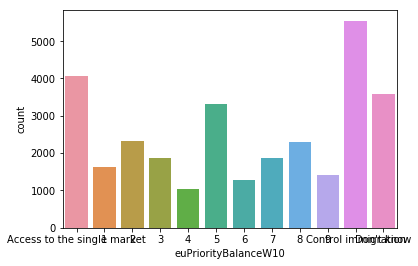

In [113]:
sns.countplot( BES_Panel[cat_vars[0]] );

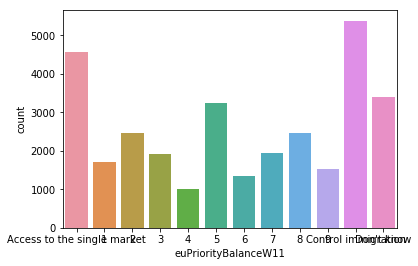

In [114]:
sns.countplot( BES_Panel[cat_vars[1]] );

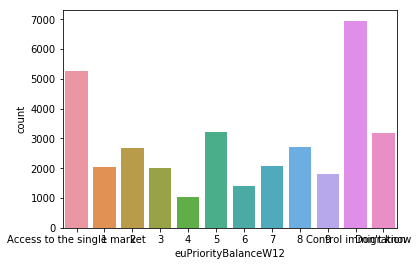

In [115]:
sns.countplot( BES_Panel[cat_vars[2]] );

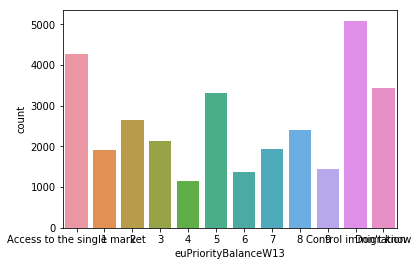

In [116]:
sns.countplot( BES_Panel[cat_vars[3]] );

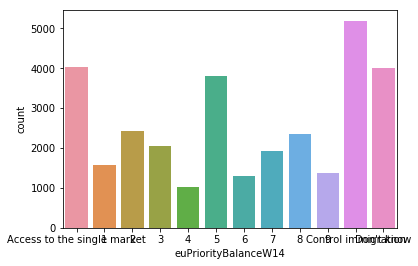

In [117]:
sns.countplot( BES_Panel[cat_vars[4]] );

In [ ]:
BES_[cat_vars[0]]

In [119]:
BES_reduced_with_na[ search(BES_reduced_with_na,"Balance") ].mean()

euPriorityBalanceW10__Control immigration    5.256230
euPriorityBalanceW11__Control immigration    5.133679
euPriorityBalanceW12__Control immigration    5.262494
euPriorityBalanceW13__Control immigration    5.044045
euPriorityBalanceW14__Control immigration    5.178358
dtype: float32

In [121]:
BES_reduced_with_na[ search(BES_reduced_with_na,"Balance")[0] ].value_counts()

10.0    5548
0.0     4061
5.0     3320
2.0     2321
8.0     2311
3.0     1869
7.0     1862
1.0     1618
9.0     1418
6.0     1276
4.0     1040
Name: euPriorityBalanceW10__Control immigration, dtype: int64

In [126]:
# weights[num_to_weight[14]]

In [156]:
var1 ="profile_eurefvote"
# var2 ="profile_gross_household"
var2 ="euPriorityBalanceW14"

mask = BES_Panel[var1].notnull() & BES_Panel[var2].notnull()
ct = pd.crosstab( BES_Panel[var1], BES_Panel[var2],
                  values= weights[num_to_weight[14]], aggfunc=sum, normalize='all')*100
sorted_labels = list(BES_Panel[var2].cat.categories)
# sorted_labels = list(BES_Panel[var2].value_counts().index)
# sorted_labels = list(cat_dictionary[var2]) + ["Prefer not to answer", "Don't know"]

In [157]:
treatment = var2 +" by " + var1
output_subfolder = create_subdir(BES_output_folder, treatment)

Warning, filename truncated because it was over 30. Filenames may no longer be unique


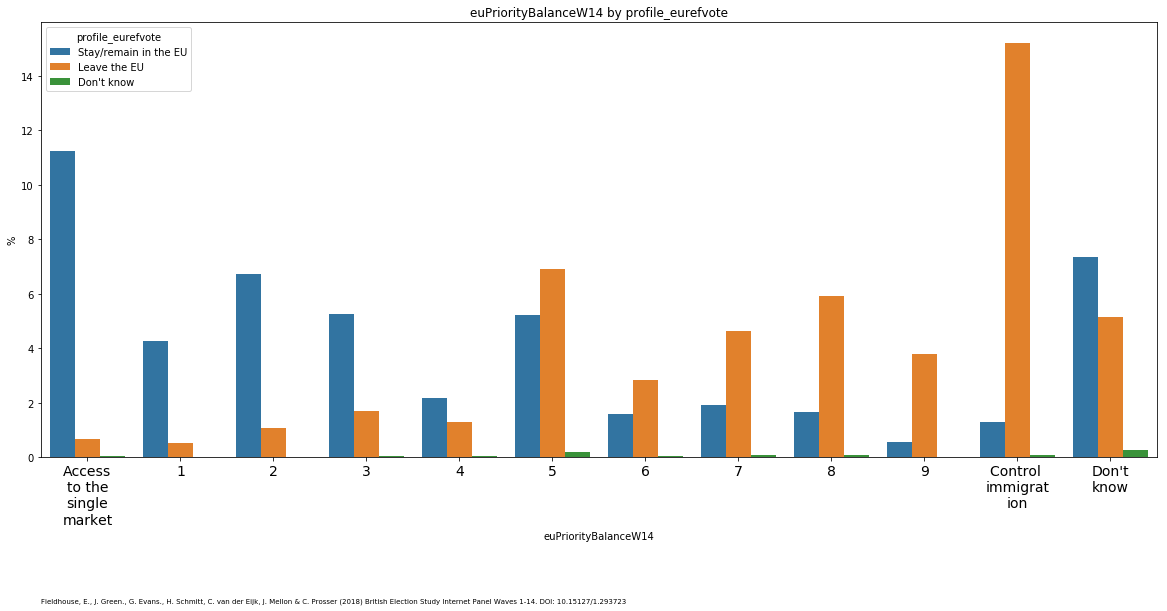

In [158]:
import textwrap 
  
wrapper = textwrap.TextWrapper(width=8) 

stacked = ct.stack().reset_index().rename(columns={0:'%',"level_1":var2})
fig = plt.figure(figsize=(20, 8))
ax = fig.subplots()

sns.barplot(x=stacked[var2],
            y=stacked['%'],
            hue=stacked[var1],
            ax=ax, order = sorted_labels);
# plt.xticks(rotation=90);

title = var2 +" by " + var1
plt.title(title)
ax.set_xticklabels([ wrapper.fill(text=x) for x in sorted_labels], rotation=0, fontsize=14);

ax.annotate(dataset_citation, (0,0), (0, -140),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
fname = output_subfolder + title.replace(" ","_") + ".png"
fig.savefig( fname, bbox_inches='tight' )

In [155]:
mask = BES_Panel[var1].notnull() & BES_Panel[var2].notnull()
ct = pd.crosstab( BES_Panel[var1], BES_Panel[var2],
                  values= weights[num_to_weight[14]], aggfunc=sum, normalize='all')*100
ct

euPriorityBalanceW14,Access to the single market,1,2,3,4,5,6,7,8,9,Control immigration,Don't know
profile_eurefvote,,,,,,,,,,,,
Stay/remain in the EU,11.253633,4.282175,6.727471,5.269200,2.180838,5.215113,1.570612,1.920141,1.675070,0.570826,1.307212,7.332316
Leave the EU,0.675973,0.535886,1.063216,1.686248,1.312646,6.909171,2.825169,4.640321,5.906121,3.802632,15.197557,5.164931
Don't know,0.056227,0.012057,0.024434,0.032838,0.032557,0.209970,0.056713,0.085977,0.098324,0.010806,0.102398,0.253222


In [159]:
var1 ="profile_eurefvote_Leave the EU"
var2 ="euPriorityBalanceW10__Control immigration"

mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
ct = pd.crosstab( BES_reduced_with_na[var1], BES_reduced_with_na[var2],
                  values= weights[num_to_weight[10]], aggfunc=sum, normalize='all')*100
ct

euPriorityBalanceW10__Control immigration,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
profile_eurefvote_Leave the EU,,,,,,,,,,,
0.0,12.400811,4.621622,7.522222,5.251658,2.670894,6.129749,2.040170,2.537421,2.173357,0.920651,1.906599
1.0,0.919985,0.592108,1.121696,1.539805,1.302337,6.541407,2.881303,5.109639,7.005040,4.505930,20.305599


In [161]:
(BES_reduced_with_na[var2]*weights[num_to_weight[10]]).mean()

5.235685055023459

In [142]:
search(BES_reduced_with_na,"Balance")

['euPriorityBalanceW10__Control immigration',
 'euPriorityBalanceW11__Control immigration',
 'euPriorityBalanceW12__Control immigration',
 'euPriorityBalanceW13__Control immigration',
 'euPriorityBalanceW14__Control immigration']

In [15]:
search(BES_reduced_with_na,"euRefVoteW7")

['euRefVoteW7_Leave the EU']

In [7]:
search(BES_reduced_with_na,"harkBack")

['harkBackW7__Strongly agree',
 'harkBackW10__Strongly agree',
 'harkBackW11__Strongly agree']

In [16]:
a,b,c = corr_simple_spearmanr( BES_reduced_with_na['euRefVoteW7_Leave the EU'] , BES_reduced_with_na['harkBackW11__Strongly agree'] )
a,b,c

(0.30130410558907555, 0.0, 16130)

(0.4107867106497102, 0.0, 24870)